In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [2]:
def import_VCF42_to_pandas(vcf_file, sep='\t'):
    header_lines = 0
    with open(vcf_file) as f:
        first_line = f.readline().strip()
        next_line = f.readline().strip()
        while next_line.startswith("##"):
            header_lines = header_lines + 1
            #print(next_line)
            next_line = f.readline()
    
    if first_line.endswith('VCFv4.2'):
        
        #Use first line as header
        dataframe = pd.read_csv(vcf_file, sep=sep, skiprows=[header_lines], header=header_lines)
        sample = dataframe.columns[-1]
        dataframe.rename(columns={sample:'sample'}, inplace=True)
        
        for index in dataframe.index:
            info_fields = re.findall(r';*([a-zA-Z]{1,20})=', dataframe.loc[index,'INFO'])
            info_values = re.findall(r'-?\d+\.?\d*e?[+-]?\d{0,2}', dataframe.loc[index,'INFO'])
            
            format_fields = dataframe.loc[index,'FORMAT'].split(":")
            format_values = dataframe.loc[index,'sample'].split(":")
                                    
            for ifield, ivalue in zip(info_fields,info_values):
                dataframe.loc[index,ifield] = ivalue
                
            for ffield, fvalue in zip(format_fields,format_values):
                dataframe.loc[index,ffield] = fvalue
            #if len(format_values[1].split(",")) != 2:
            #    print(format_values[1].split(","), index)
            #    print(dataframe.iloc[index])
        dataframe.rename(columns={'AF':'af'}, inplace=True)
        dataframe['REF_AD'] = dataframe['AD'].str.split(",").str[-2:].str[0]
        dataframe['ALT_AD'] = dataframe['AD'].str.split(",").str[-2:].str[1]
        
        to_float = ['QUAL', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR','GQ','ALT_AD', 'REF_AD']
        
        to_int = ['POS']
        
        for column in dataframe.columns:
            if column in to_float:
                dataframe[column] = dataframe[column].astype(float)
                
        for column in dataframe.columns:
            if column in to_int:
                dataframe[column] = dataframe[column].astype(int)
        
        dataframe['aF'] = dataframe['REF_AD']/dataframe['DP']
        dataframe['AF'] = dataframe['ALT_AD']/dataframe['DP']

                
    else:
        print("This vcf file is not v4.2")
        sys.exit(1)
           
    return dataframe

In [3]:
sample_list = []
vcf_files = []
directory = "test"

for file in os.listdir(directory):
    if file.endswith(".final.snp.hf.pass.vcf"):
        name = file.split(".")[0]
        sample_list.append(name)
        file_path = os.path.join(directory, file)
        vcf_files.append(file_path)
        
sample_list.sort()
vcf_files.sort()

print(sample_list)
print(vcf_files)

['1008298', 'AL-20243', 'AL-2350209', 'AL-51757', 'AL-6263', 'AL-8634', 'AL-93627', 'AL10336108', 'AL94235']
['test/1008298.final.snp.hf.pass.vcf', 'test/AL-20243.final.snp.hf.pass.vcf', 'test/AL-2350209.final.snp.hf.pass.vcf', 'test/AL-51757.final.snp.hf.pass.vcf', 'test/AL-6263.final.snp.hf.pass.vcf', 'test/AL-8634.final.snp.hf.pass.vcf', 'test/AL-93627.final.snp.hf.pass.vcf', 'test/AL10336108.final.snp.hf.pass.vcf', 'test/AL94235.final.snp.hf.pass.vcf']


In [4]:
dict_vcf = {}
for vcf, df_name in zip(vcf_files, sample_list):
    dict_vcf[df_name] = import_VCF42_to_pandas(vcf)

In [62]:
dict_vcf["1008298"].head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,MQRankSum,ReadPosRankSum,PGT,PID,PS,REF_AD,ALT_AD,aF,AF,Is_repeat
0,MTB_anc,1701,.,T,C,32647.95,PASS,AC=2;AF=1.00;AN=2;DP=201;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,201:201:99:5721,601,0",...,NaN,NaN,NaN,NaN,NaN,0.0,201.0,0.0,1.0,False
1,MTB_anc,2532,.,C,T,10081.95,PASS,AC=2;AF=1.00;AN=2;DP=84;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,84:84:99:2421,251,0",...,NaN,NaN,NaN,NaN,NaN,0.0,84.0,0.0,1.0,False
2,MTB_anc,8040,.,G,A,31778.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=-1.728e+00;DP=2...,GT:AD:DP:GQ:PL,"1/1:0,223:223:99:6572,666,0",...,0.0,-0.516,NaN,NaN,NaN,0.0,223.0,0.0,1.0,False
3,MTB_anc,9143,.,C,T,36066.95,PASS,AC=2;AF=1.00;AN=2;DP=210;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,210:210:99:6353,628,0",...,NaN,NaN,NaN,NaN,NaN,0.0,210.0,0.0,1.0,False
4,MTB_anc,13460,.,G,A,30127.95,PASS,AC=2;AF=1.00;AN=2;DP=195;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,195:195:99:5704,580,0",...,NaN,NaN,NaN,NaN,NaN,0.0,195.0,0.0,1.0,False


In [6]:
def scatter_vcf_pos_vcf_test(vcf_df, name):
    filter_homoz_top = 0.96
    filter_homoz_bottom = (1 - filter_homoz_top)
    
    y = vcf_df['AF']
    x = vcf_df['POS']
    plt.figure(figsize=(50,15))
    plt.margins(x=0.01, y=0.01, tight=True)
    
    mean = vcf_df['AF'][(vcf_df['AF'] < filter_homoz_top) & (vcf_df['AF'] > filter_homoz_bottom)].mean(axis = 0)
    
    #col_mean = np.where(vcf_df['AF'][(vcf_df['AF'] < filter_homoz_top) & (vcf_df['AF'] > filter_homoz_bottom)] > mean,'c','salmon')
    col_mean = 'c'
    label_fontsize = 30
    tick_fontsize = 20
    plt.ylabel('Allele Frequency', fontsize=label_fontsize)
    plt.xlabel('Genome Position', fontsize=label_fontsize)
    plt.title(name, fontsize=label_fontsize)
    
    plt.ylim(0, 1)
    
    plt.yticks(fontsize=tick_fontsize)
    plt.xticks(fontsize=tick_fontsize) #rotation=90
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()
    
    """
    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='1', color='k')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='1', color='k')
    
    # Turn on/off the display of all ticks.
    plt.tick_params(which='minor', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='on') # turn on bottom ticks
    """
    plt.grid(True)
    
    plt.scatter(x, y, color=col_mean, alpha=0.8, s=50)
    
    plt.show()

In [30]:
#def filter_repeats_1(row):
#    if ((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] >= 399535 ) & (row['POS'] <=  400050))|((row['POS'] >= 400192 ) & (row['POS'] <=  401703))|((row['POS'] >= 424269 ) & (row['POS'] <=  424694))|((row['POS'] >= 424777 ) & (row['POS'] <=  434679))|((row['POS'] >= 466672 ) & (row['POS'] <=  467406))|((row['POS'] >= 467459 ) & (row['POS'] <=  468001))|((row['POS'] >= 472781 ) & (row['POS'] <=  474106))|((row['POS'] >= 475816 ) & (row['POS'] <=  476184))|((row['POS'] >= 530751 ) & (row['POS'] <=  532214))|((row['POS'] >= 543174 ) & (row['POS'] <=  544730))|((row['POS'] >= 606551 ) & (row['POS'] <=  608062))|((row['POS'] >= 622793 ) & (row['POS'] <=  624577))|((row['POS'] >= 671996 ) & (row['POS'] <=  675916))|((row['POS'] >= 832534 ) & (row['POS'] <=  832848))|((row['POS'] >= 832981 ) & (row['POS'] <=  833508))|((row['POS'] >= 835701 ) & (row['POS'] <=  838052))|((row['POS'] >= 838451 ) & (row['POS'] <=  840856))|((row['POS'] >= 846159 ) & (row['POS'] <=  847913))|((row['POS'] >= 848103 ) & (row['POS'] <=  850040))|((row['POS'] >= 850342 ) & (row['POS'] <=  850527))|((row['POS'] >= 889072 ) & (row['POS'] <=  889398))|((row['POS'] >= 889395 ) & (row['POS'] <=  890333))|((row['POS'] >= 890388 ) & (row['POS'] <=  891482))|((row['POS'] >= 924951 ) & (row['POS'] <=  925364))|((row['POS'] >= 925361 ) & (row['POS'] <=  927610))|((row['POS'] >= 927837 ) & (row['POS'] <=  930485))|((row['POS'] >= 947312 ) & (row['POS'] <=  947644))|((row['POS'] >= 968424 ) & (row['POS'] <=  970244))|((row['POS'] >= 976872 ) & (row['POS'] <=  978203))|((row['POS'] >= 1020058 ) & (row['POS'] <=  1021329))|((row['POS'] >= 1021344 ) & (row['POS'] <=  1021643))|((row['POS'] >= 1025497 ) & (row['POS'] <=  1026816))|((row['POS'] >= 1027104 ) & (row['POS'] <=  1027685))|((row['POS'] >= 1027685 ) & (row['POS'] <=  1029337))|((row['POS'] >= 1090373 ) & (row['POS'] <=  1093144))|((row['POS'] >= 1093361 ) & (row['POS'] <=  1094356))|((row['POS'] >= 1095078 ) & (row['POS'] <=  1096451))|((row['POS'] >= 1158918 ) & (row['POS'] <=  1159307))|((row['POS'] >= 1159375 ) & (row['POS'] <=  1160061))|((row['POS'] >= 1161297 ) & (row['POS'] <=  1162472))|((row['POS'] >= 1162549 ) & (row['POS'] <=  1163376))|((row['POS'] >= 1164572 ) & (row['POS'] <=  1165435))|((row['POS'] >= 1165092 ) & (row['POS'] <=  1165499))|((row['POS'] >= 1169423 ) & (row['POS'] <=  1170670))|((row['POS'] >= 1176928 ) & (row['POS'] <=  1177242))|((row['POS'] >= 1188421 ) & (row['POS'] <=  1190424))|((row['POS'] >= 1190757 ) & (row['POS'] <=  1192148))|((row['POS'] >= 1211560 ) & (row['POS'] <=  1213863))|((row['POS'] >= 1214513 ) & (row['POS'] <=  1214947))|((row['POS'] >= 1214769 ) & (row['POS'] <=  1215131))|((row['POS'] >= 1216469 ) & (row['POS'] <=  1219030))|((row['POS'] >= 1251617 ) & (row['POS'] <=  1252972))|((row['POS'] >= 1262272 ) & (row['POS'] <=  1264128))|((row['POS'] >= 1276300 ) & (row['POS'] <=  1277748))|((row['POS'] >= 1277893 ) & (row['POS'] <=  1278300))|((row['POS'] >= 1298764 ) & (row['POS'] <=  1299804))|((row['POS'] >= 1299822 ) & (row['POS'] <=  1300124))|((row['POS'] >= 1301755 ) & (row['POS'] <=  1302681))|((row['POS'] >= 1339003 ) & (row['POS'] <=  1339302))|((row['POS'] >= 1339349 ) & (row['POS'] <=  1340524))|((row['POS'] >= 1341358 ) & (row['POS'] <=  1342605))|((row['POS'] >= 1357293 ) & (row['POS'] <=  1357625))|((row['POS'] >= 1384989 ) & (row['POS'] <=  1386677))|((row['POS'] >= 1468171 ) & (row['POS'] <=  1469505))|((row['POS'] >= 1488154 ) & (row['POS'] <=  1489965))|((row['POS'] >= 1532443 ) & (row['POS'] <=  1533633))|((row['POS'] >= 1541994 ) & (row['POS'] <=  1542878))|((row['POS'] >= 1542929 ) & (row['POS'] <=  1543255))|((row['POS'] >= 1561464 ) & (row['POS'] <=  1561772))|((row['POS'] >= 1561769 ) & (row['POS'] <=  1563388))|((row['POS'] >= 1572127 ) & (row['POS'] <=  1573857))|((row['POS'] >= 1606386 ) & (row['POS'] <=  1607972))|((row['POS'] >= 1618209 ) & (row['POS'] <=  1619684))|((row['POS'] >= 1630638 ) & (row['POS'] <=  1634627))|((row['POS'] >= 1636004 ) & (row['POS'] <=  1638229))|((row['POS'] >= 1655609 ) & (row['POS'] <=  1656721))|((row['POS'] >= 1751297 ) & (row['POS'] <=  1753333))|((row['POS'] >= 1779194 ) & (row['POS'] <=  1779298))|((row['POS'] >= 1779314 ) & (row['POS'] <=  1779724))|((row['POS'] >= 1779930 ) & (row['POS'] <=  1780241))|((row['POS'] >= 1780199 ) & (row['POS'] <=  1780699))|((row['POS'] >= 1780643 ) & (row['POS'] <=  1782064))|((row['POS'] >= 1782072 ) & (row['POS'] <=  1782584))|((row['POS'] >= 1782758 ) & (row['POS'] <=  1783228))|((row['POS'] >= 1783309 ) & (row['POS'] <=  1783623))|((row['POS'] >= 1783620 ) & (row['POS'] <=  1783892))|((row['POS'] >= 1783906 ) & (row['POS'] <=  1784301))|((row['POS'] >= 1784497 ) & (row['POS'] <=  1785912))|((row['POS'] >= 1785912 ) & (row['POS'] <=  1786310))|((row['POS'] >= 1786307 ) & (row['POS'] <=  1786528))|((row['POS'] >= 1786584 ) & (row['POS'] <=  1787099))|((row['POS'] >= 1787096 ) & (row['POS'] <=  1788505))|((row['POS'] >= 1788162 ) & (row['POS'] <=  1789163))|((row['POS'] >= 1789168 ) & (row['POS'] <=  1789836))|((row['POS'] >= 1855764 ) & (row['POS'] <=  1856696))|((row['POS'] >= 1862347 ) & (row['POS'] <=  1865382))|((row['POS'] >= 1931497 ) & (row['POS'] <=  1932654))|((row['POS'] >= 1932694 ) & (row['POS'] <=  1933878))|((row['POS'] >= 1981614 ) & (row['POS'] <=  1984775))|((row['POS'] >= 1987745 ) & (row['POS'] <=  1988629))|((row['POS'] >= 1988680 ) & (row['POS'] <=  1989006))|((row['POS'] >= 1989833 ) & (row['POS'] <=  1992577))|((row['POS'] >= 1996152 ) & (row['POS'] <=  1996478))|((row['POS'] >= 1996529 ) & (row['POS'] <=  1997413))|((row['POS'] >= 1999142 ) & (row['POS'] <=  1999357)):
#        return True
#    else:
#        return False
#def filter_repeats_2(row):
#    if ((row['POS'] >= 2000614 ) & (row['POS'] <=  2002470))|((row['POS'] >= 2025301 ) & (row['POS'] <=  2026398))|((row['POS'] >= 2026477 ) & (row['POS'] <=  2026776))|((row['POS'] >= 2026790 ) & (row['POS'] <=  2027971))|((row['POS'] >= 2028425 ) & (row['POS'] <=  2029477))|((row['POS'] >= 2029904 ) & (row['POS'] <=  2030203))|((row['POS'] >= 2039453 ) & (row['POS'] <=  2041420))|((row['POS'] >= 2042001 ) & (row['POS'] <=  2043272))|((row['POS'] >= 2043384 ) & (row['POS'] <=  2044775))|((row['POS'] >= 2044923 ) & (row['POS'] <=  2046842))|((row['POS'] >= 2048072 ) & (row['POS'] <=  2048371))|((row['POS'] >= 2048398 ) & (row['POS'] <=  2049597))|((row['POS'] >= 2049921 ) & (row['POS'] <=  2051150))|((row['POS'] >= 2051282 ) & (row['POS'] <=  2052688))|((row['POS'] >= 2061178 ) & (row['POS'] <=  2062674))|((row['POS'] >= 2087971 ) & (row['POS'] <=  2089518))|((row['POS'] >= 2162932 ) & (row['POS'] <=  2167311))|((row['POS'] >= 2167649 ) & (row['POS'] <=  2170612))|((row['POS'] >= 2195989 ) & (row['POS'] <=  2197353))|((row['POS'] >= 2226244 ) & (row['POS'] <=  2227920))|((row['POS'] >= 2260665 ) & (row['POS'] <=  2261144))|((row['POS'] >= 2261098 ) & (row['POS'] <=  2261688))|((row['POS'] >= 2358389 ) & (row['POS'] <=  2360041))|((row['POS'] >= 2365465 ) & (row['POS'] <=  2365791))|((row['POS'] >= 2365788 ) & (row['POS'] <=  2366726))|((row['POS'] >= 2367359 ) & (row['POS'] <=  2367655))|((row['POS'] >= 2367711 ) & (row['POS'] <=  2368442))|((row['POS'] >= 2381071 ) & (row['POS'] <=  2382492))|((row['POS'] >= 2387202 ) & (row['POS'] <=  2387972))|((row['POS'] >= 2423240 ) & (row['POS'] <=  2424838))|((row['POS'] >= 2430159 ) & (row['POS'] <=  2431199))|((row['POS'] >= 2431094 ) & (row['POS'] <=  2431420))|((row['POS'] >= 2439282 ) & (row['POS'] <=  2439947))|((row['POS'] >= 2550065 ) & (row['POS'] <=  2550391))|((row['POS'] >= 2550388 ) & (row['POS'] <=  2551326))|((row['POS'] >= 2600731 ) & (row['POS'] <=  2601879))|((row['POS'] >= 2617667 ) & (row['POS'] <=  2618908))|((row['POS'] >= 2632923 ) & (row['POS'] <=  2634098))|((row['POS'] >= 2634528 ) & (row['POS'] <=  2635592))|((row['POS'] >= 2635628 ) & (row['POS'] <=  2635954))|((row['POS'] >= 2635951 ) & (row['POS'] <=  2636889))|((row['POS'] >= 2637688 ) & (row['POS'] <=  2639535))|((row['POS'] >= 2651753 ) & (row['POS'] <=  2651938))|((row['POS'] >= 2692799 ) & (row['POS'] <=  2693884))|((row['POS'] >= 2706017 ) & (row['POS'] <=  2706736))|((row['POS'] >= 2720776 ) & (row['POS'] <=  2721777))|((row['POS'] >= 2727336 ) & (row['POS'] <=  2727920))|((row['POS'] >= 2727967 ) & (row['POS'] <=  2728266))|((row['POS'] >= 2784657 ) & (row['POS'] <=  2785697))|((row['POS'] >= 2785592 ) & (row['POS'] <=  2785918))|((row['POS'] >= 2795301 ) & (row['POS'] <=  2797385))|((row['POS'] >= 2801254 ) & (row['POS'] <=  2806236))|((row['POS'] >= 2828556 ) & (row['POS'] <=  2829803))|((row['POS'] >= 2835785 ) & (row['POS'] <=  2837263))|((row['POS'] >= 2921551 ) & (row['POS'] <=  2923182))|((row['POS'] >= 2935046 ) & (row['POS'] <=  2936788))|((row['POS'] >= 2943600 ) & (row['POS'] <=  2944985))|((row['POS'] >= 2960105 ) & (row['POS'] <=  2962441))|((row['POS'] >= 2970551 ) & (row['POS'] <=  2971549))|((row['POS'] >= 2972160 ) & (row['POS'] <=  2972486))|((row['POS'] >= 2972435 ) & (row['POS'] <=  2973421))|((row['POS'] >= 2973795 ) & (row['POS'] <=  2975234))|((row['POS'] >= 2975242 ) & (row['POS'] <=  2975775))|((row['POS'] >= 2975928 ) & (row['POS'] <=  2976554))|((row['POS'] >= 2976586 ) & (row['POS'] <=  2976909))|((row['POS'] >= 2976989 ) & (row['POS'] <=  2977234))|((row['POS'] >= 2977231 ) & (row['POS'] <=  2978658))|((row['POS'] >= 2978660 ) & (row['POS'] <=  2979052))|((row['POS'] >= 2979049 ) & (row['POS'] <=  2979309))|((row['POS'] >= 2979326 ) & (row['POS'] <=  2979688))|((row['POS'] >= 2979691 ) & (row['POS'] <=  2980818))|((row['POS'] >= 2983071 ) & (row['POS'] <=  2983874))|((row['POS'] >= 3053914 ) & (row['POS'] <=  3055491))|((row['POS'] >= 3076894 ) & (row['POS'] <=  3078078))|((row['POS'] >= 3078158 ) & (row['POS'] <=  3078985))|((row['POS'] >= 3079309 ) & (row['POS'] <=  3080457))|((row['POS'] >= 3100202 ) & (row['POS'] <=  3101581))|((row['POS'] >= 3115741 ) & (row['POS'] <=  3116142))|((row['POS'] >= 3116818 ) & (row['POS'] <=  3118227))|((row['POS'] >= 3120566 ) & (row['POS'] <=  3121504))|((row['POS'] >= 3121501 ) & (row['POS'] <=  3121827))|((row['POS'] >= 3162268 ) & (row['POS'] <=  3164115))|((row['POS'] >= 3194166 ) & (row['POS'] <=  3195548))|((row['POS'] >= 3200794 ) & (row['POS'] <=  3202020))|((row['POS'] >= 3288464 ) & (row['POS'] <=  3289705))|((row['POS'] >= 3289705 ) & (row['POS'] <=  3290235))|((row['POS'] >= 3289790 ) & (row['POS'] <=  3290506))|((row['POS'] >= 3313283 ) & (row['POS'] <=  3313672))|((row['POS'] >= 3333785 ) & (row['POS'] <=  3335164))|((row['POS'] >= 3376939 ) & (row['POS'] <=  3378243))|((row['POS'] >= 3378329 ) & (row['POS'] <=  3378415))|((row['POS'] >= 3379376 ) & (row['POS'] <=  3380452))|((row['POS'] >= 3380440 ) & (row['POS'] <=  3380682))|((row['POS'] >= 3380679 ) & (row['POS'] <=  3380993))|((row['POS'] >= 3381375 ) & (row['POS'] <=  3382622))|((row['POS'] >= 3465778 ) & (row['POS'] <=  3467091))|((row['POS'] >= 3481451 ) & (row['POS'] <=  3482698))|((row['POS'] >= 3490476 ) & (row['POS'] <=  3491651))|((row['POS'] >= 3501334 ) & (row['POS'] <=  3501732))|((row['POS'] >= 3501794 ) & (row['POS'] <=  3502936))|((row['POS'] >= 3510088 ) & (row['POS'] <=  3511317))|((row['POS'] >= 3527391 ) & (row['POS'] <=  3529163))|((row['POS'] >= 3551281 ) & (row['POS'] <=  3551607))|((row['POS'] >= 3551604 ) & (row['POS'] <=  3552542))|((row['POS'] >= 3552764 ) & (row['POS'] <=  3553090))|((row['POS'] >= 3553087 ) & (row['POS'] <=  3554025))|((row['POS'] >= 3557311 ) & (row['POS'] <=  3558345))|((row['POS'] >= 3710433 ) & (row['POS'] <=  3710759))|((row['POS'] >= 3710756 ) & (row['POS'] <=  3711694))|((row['POS'] >= 3711749 ) & (row['POS'] <=  3713461))|((row['POS'] >= 3729364 ) & (row['POS'] <=  3736935))|((row['POS'] >= 3736984 ) & (row['POS'] <=  3738438))|((row['POS'] >= 3738158 ) & (row['POS'] <=  3742774))|((row['POS'] >= 3743711 ) & (row['POS'] <=  3753184))|((row['POS'] >= 3753765 ) & (row['POS'] <=  3754256))|((row['POS'] >= 3754293 ) & (row['POS'] <=  3755033))|((row['POS'] >= 3755952 ) & (row['POS'] <=  3767102))|((row['POS'] >= 3778568 ) & (row['POS'] <=  3780334))|((row['POS'] >= 3795100 ) & (row['POS'] <=  3795984))|((row['POS'] >= 3796035 ) & (row['POS'] <=  3796361))|((row['POS'] >= 3800092 ) & (row['POS'] <=  3800796))|((row['POS'] >= 3800786 ) & (row['POS'] <=  3801463))|((row['POS'] >= 3801653 ) & (row['POS'] <=  3803848))|((row['POS'] >= 3842239 ) & (row['POS'] <=  3842769))|((row['POS'] >= 3843036 ) & (row['POS'] <=  3843734))|((row['POS'] >= 3843885 ) & (row['POS'] <=  3844640))|((row['POS'] >= 3844738 ) & (row['POS'] <=  3845970))|((row['POS'] >= 3847165 ) & (row['POS'] <=  3847701))|((row['POS'] >= 3883525 ) & (row['POS'] <=  3884193))|((row['POS'] >= 3883964 ) & (row['POS'] <=  3884917))|((row['POS'] >= 3890830 ) & (row['POS'] <=  3891156))|((row['POS'] >= 3891051 ) & (row['POS'] <=  3892091))|((row['POS'] >= 3894093 ) & (row['POS'] <=  3894389))|((row['POS'] >= 3894426 ) & (row['POS'] <=  3895607))|((row['POS'] >= 3926569 ) & (row['POS'] <=  3930714))|((row['POS'] >= 3931005 ) & (row['POS'] <=  3936710))|((row['POS'] >= 3939617 ) & (row['POS'] <=  3941761))|((row['POS'] >= 3941724 ) & (row['POS'] <=  3944963))|((row['POS'] >= 3945794 ) & (row['POS'] <=  3950263))|((row['POS'] >= 3969343 ) & (row['POS'] <=  3970563))|((row['POS'] >= 3970705 ) & (row['POS'] <=  3972453))|((row['POS'] >= 3978059 ) & (row['POS'] <=  3979498))|((row['POS'] >= 3997980 ) & (row['POS'] <=  3999638))|((row['POS'] >= 4031404 ) & (row['POS'] <=  4033158))|((row['POS'] >= 4036731 ) & (row['POS'] <=  4038050))|((row['POS'] >= 4060648 ) & (row['POS'] <=  4061889))|((row['POS'] >= 4061899 ) & (row['POS'] <=  4062198))|((row['POS'] >= 4075752 ) & (row['POS'] <=  4076099))|((row['POS'] >= 4076484 ) & (row['POS'] <=  4076984))|((row['POS'] >= 4076984 ) & (row['POS'] <=  4077730))|((row['POS'] >= 4091233 ) & (row['POS'] <=  4091517))|((row['POS'] >= 4093632 ) & (row['POS'] <=  4093946))|((row['POS'] >= 4093940 ) & (row['POS'] <=  4094527))|((row['POS'] >= 4189285 ) & (row['POS'] <=  4190232))|((row['POS'] >= 4190284 ) & (row['POS'] <=  4190517))|((row['POS'] >= 4196171 ) & (row['POS'] <=  4196506))|((row['POS'] >= 4198874 ) & (row['POS'] <=  4199089))|((row['POS'] >= 4252993 ) & (row['POS'] <=  4254327))|((row['POS'] >= 4276571 ) & (row['POS'] <=  4278085))|((row['POS'] >= 4301563 ) & (row['POS'] <=  4302789))|((row['POS'] >= 4318775 ) & (row['POS'] <=  4319266))|((row['POS'] >= 4350745 ) & (row['POS'] <=  4351044))|((row['POS'] >= 4351075 ) & (row['POS'] <=  4352181))|((row['POS'] >= 4374484 ) & (row['POS'] <=  4375683))|((row['POS'] >= 4375762 ) & (row['POS'] <=  4375995)):
#        return True
#    else:
#        return False

In [77]:
def filter_repeats(row):
    if (((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|
    ((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|
    ((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|
    ((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|
    ((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|
    ((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|
    ((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|
    ((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|
    ((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|
    ((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] >= 399535 ) & (row['POS'] <=  400050))|
    ((row['POS'] >= 400192 ) & (row['POS'] <=  401703))|((row['POS'] >= 424269 ) & (row['POS'] <=  424694))|
    ((row['POS'] >= 424777 ) & (row['POS'] <=  434679))|((row['POS'] >= 466672 ) & (row['POS'] <=  467406))|
    ((row['POS'] >= 467459 ) & (row['POS'] <=  468001))|((row['POS'] >= 472781 ) & (row['POS'] <=  474106))|
    ((row['POS'] >= 475816 ) & (row['POS'] <=  476184))|((row['POS'] >= 530751 ) & (row['POS'] <=  532214))|
    ((row['POS'] >= 543174 ) & (row['POS'] <=  544730))|((row['POS'] >= 606551 ) & (row['POS'] <=  608062))|
    ((row['POS'] >= 622793 ) & (row['POS'] <=  624577))|((row['POS'] >= 671996 ) & (row['POS'] <=  675916))|
    ((row['POS'] >= 832534 ) & (row['POS'] <=  832848))|((row['POS'] >= 832981 ) & (row['POS'] <=  833508))|
    ((row['POS'] >= 835701 ) & (row['POS'] <=  838052))|((row['POS'] >= 838451 ) & (row['POS'] <=  840856))|
    ((row['POS'] >= 846159 ) & (row['POS'] <=  847913))|((row['POS'] >= 848103 ) & (row['POS'] <=  850040))|
    ((row['POS'] >= 850342 ) & (row['POS'] <=  850527))|((row['POS'] >= 889072 ) & (row['POS'] <=  889398))|
    ((row['POS'] >= 889395 ) & (row['POS'] <=  890333))|((row['POS'] >= 890388 ) & (row['POS'] <=  891482))|
    ((row['POS'] >= 924951 ) & (row['POS'] <=  925364))|((row['POS'] >= 925361 ) & (row['POS'] <=  927610))|
    ((row['POS'] >= 927837 ) & (row['POS'] <=  930485))|((row['POS'] >= 947312 ) & (row['POS'] <=  947644))|
    ((row['POS'] >= 968424 ) & (row['POS'] <=  970244))|((row['POS'] >= 976872 ) & (row['POS'] <=  978203))|
    ((row['POS'] >= 1020058 ) & (row['POS'] <=  1021329))|((row['POS'] >= 1021344 ) & (row['POS'] <=  1021643))|
    ((row['POS'] >= 1025497 ) & (row['POS'] <=  1026816))|((row['POS'] >= 1027104 ) & (row['POS'] <=  1027685))|
    ((row['POS'] >= 1027685 ) & (row['POS'] <=  1029337))|((row['POS'] >= 1090373 ) & (row['POS'] <=  1093144))|
    ((row['POS'] >= 1093361 ) & (row['POS'] <=  1094356))|((row['POS'] >= 1095078 ) & (row['POS'] <=  1096451))|
    ((row['POS'] >= 1158918 ) & (row['POS'] <=  1159307))|((row['POS'] >= 1159375 ) & (row['POS'] <=  1160061))|
    ((row['POS'] >= 1161297 ) & (row['POS'] <=  1162472))|((row['POS'] >= 1162549 ) & (row['POS'] <=  1163376))|
    ((row['POS'] >= 1164572 ) & (row['POS'] <=  1165435))|((row['POS'] >= 1165092 ) & (row['POS'] <=  1165499))|
    ((row['POS'] >= 1169423 ) & (row['POS'] <=  1170670))|((row['POS'] >= 1176928 ) & (row['POS'] <=  1177242))|
    ((row['POS'] >= 1188421 ) & (row['POS'] <=  1190424))|((row['POS'] >= 1190757 ) & (row['POS'] <=  1192148))|
    ((row['POS'] >= 1211560 ) & (row['POS'] <=  1213863))|((row['POS'] >= 1214513 ) & (row['POS'] <=  1214947))|
    ((row['POS'] >= 1214769 ) & (row['POS'] <=  1215131))|((row['POS'] >= 1216469 ) & (row['POS'] <=  1219030))|
    ((row['POS'] >= 1251617 ) & (row['POS'] <=  1252972))|((row['POS'] >= 1262272 ) & (row['POS'] <=  1264128))|
    ((row['POS'] >= 1276300 ) & (row['POS'] <=  1277748))|((row['POS'] >= 1277893 ) & (row['POS'] <=  1278300))|
    ((row['POS'] >= 1298764 ) & (row['POS'] <=  1299804))|((row['POS'] >= 1299822 ) & (row['POS'] <=  1300124))|
    ((row['POS'] >= 1301755 ) & (row['POS'] <=  1302681))|((row['POS'] >= 1339003 ) & (row['POS'] <=  1339302))|
    ((row['POS'] >= 1339349 ) & (row['POS'] <=  1340524))|((row['POS'] >= 1341358 ) & (row['POS'] <=  1342605))|
    ((row['POS'] >= 1357293 ) & (row['POS'] <=  1357625))|((row['POS'] >= 1384989 ) & (row['POS'] <=  1386677))|
    ((row['POS'] >= 1468171 ) & (row['POS'] <=  1469505))|((row['POS'] >= 1488154 ) & (row['POS'] <=  1489965))|
    ((row['POS'] >= 1532443 ) & (row['POS'] <=  1533633))|((row['POS'] >= 1541994 ) & (row['POS'] <=  1542878))|
    ((row['POS'] >= 1542929 ) & (row['POS'] <=  1543255))|((row['POS'] >= 1561464 ) & (row['POS'] <=  1561772))|
    ((row['POS'] >= 1561769 ) & (row['POS'] <=  1563388))|((row['POS'] >= 1572127 ) & (row['POS'] <=  1573857))|
    ((row['POS'] >= 1606386 ) & (row['POS'] <=  1607972))|((row['POS'] >= 1618209 ) & (row['POS'] <=  1619684))|
    ((row['POS'] >= 1630638 ) & (row['POS'] <=  1634627))|((row['POS'] >= 1636004 ) & (row['POS'] <=  1638229))|
    ((row['POS'] >= 1655609 ) & (row['POS'] <=  1656721))|((row['POS'] >= 1751297 ) & (row['POS'] <=  1753333))|
    ((row['POS'] >= 1779194 ) & (row['POS'] <=  1779298))|((row['POS'] >= 1779314 ) & (row['POS'] <=  1779724))|
    ((row['POS'] >= 1779930 ) & (row['POS'] <=  1780241))|((row['POS'] >= 1780199 ) & (row['POS'] <=  1780699))|
    ((row['POS'] >= 1780643 ) & (row['POS'] <=  1782064))|((row['POS'] >= 1782072 ) & (row['POS'] <=  1782584))|
    ((row['POS'] >= 1782758 ) & (row['POS'] <=  1783228))|((row['POS'] >= 1783309 ) & (row['POS'] <=  1783623))|
    ((row['POS'] >= 1783620 ) & (row['POS'] <=  1783892))|((row['POS'] >= 1783906 ) & (row['POS'] <=  1784301))|
    ((row['POS'] >= 1784497 ) & (row['POS'] <=  1785912))|((row['POS'] >= 1785912 ) & (row['POS'] <=  1786310))|
    ((row['POS'] >= 1786307 ) & (row['POS'] <=  1786528))|((row['POS'] >= 1786584 ) & (row['POS'] <=  1787099))|
    ((row['POS'] >= 1787096 ) & (row['POS'] <=  1788505))|((row['POS'] >= 1788162 ) & (row['POS'] <=  1789163))|
    ((row['POS'] >= 1789168 ) & (row['POS'] <=  1789836))|((row['POS'] >= 1855764 ) & (row['POS'] <=  1856696))|
    ((row['POS'] >= 1862347 ) & (row['POS'] <=  1865382))|((row['POS'] >= 1931497 ) & (row['POS'] <=  1932654))|
    ((row['POS'] >= 1932694 ) & (row['POS'] <=  1933878))|((row['POS'] >= 1981614 ) & (row['POS'] <=  1984775))|
    ((row['POS'] >= 1987745 ) & (row['POS'] <=  1988629))|((row['POS'] >= 1988680 ) & (row['POS'] <=  1989006))|
    ((row['POS'] >= 1989833 ) & (row['POS'] <=  1992577))|((row['POS'] >= 1996152 ) & (row['POS'] <=  1996478))|
    ((row['POS'] >= 1996529 ) & (row['POS'] <=  1997413))|((row['POS'] >= 1999142 ) & (row['POS'] <=  1999357))):
        return True
    elif (((row['POS'] >= 2000614 ) & (row['POS'] <=  2002470))|
    ((row['POS'] >= 2025301 ) & (row['POS'] <=  2026398))|((row['POS'] >= 2026477 ) & (row['POS'] <=  2026776))|
    ((row['POS'] >= 2026790 ) & (row['POS'] <=  2027971))|((row['POS'] >= 2028425 ) & (row['POS'] <=  2029477))|
    ((row['POS'] >= 2029904 ) & (row['POS'] <=  2030203))|((row['POS'] >= 2039453 ) & (row['POS'] <=  2041420))|
    ((row['POS'] >= 2042001 ) & (row['POS'] <=  2043272))|((row['POS'] >= 2043384 ) & (row['POS'] <=  2044775))|
    ((row['POS'] >= 2044923 ) & (row['POS'] <=  2046842))|((row['POS'] >= 2048072 ) & (row['POS'] <=  2048371))|
    ((row['POS'] >= 2048398 ) & (row['POS'] <=  2049597))|((row['POS'] >= 2049921 ) & (row['POS'] <=  2051150))|
    ((row['POS'] >= 2051282 ) & (row['POS'] <=  2052688))|((row['POS'] >= 2061178 ) & (row['POS'] <=  2062674))|
    ((row['POS'] >= 2087971 ) & (row['POS'] <=  2089518))|((row['POS'] >= 2162932 ) & (row['POS'] <=  2167311))|
    ((row['POS'] >= 2167649 ) & (row['POS'] <=  2170612))|((row['POS'] >= 2195989 ) & (row['POS'] <=  2197353))|
    ((row['POS'] >= 2226244 ) & (row['POS'] <=  2227920))|((row['POS'] >= 2260665 ) & (row['POS'] <=  2261144))|
    ((row['POS'] >= 2261098 ) & (row['POS'] <=  2261688))|((row['POS'] >= 2358389 ) & (row['POS'] <=  2360041))|
    ((row['POS'] >= 2365465 ) & (row['POS'] <=  2365791))|((row['POS'] >= 2365788 ) & (row['POS'] <=  2366726))|
    ((row['POS'] >= 2367359 ) & (row['POS'] <=  2367655))|((row['POS'] >= 2367711 ) & (row['POS'] <=  2368442))|
    ((row['POS'] >= 2381071 ) & (row['POS'] <=  2382492))|((row['POS'] >= 2387202 ) & (row['POS'] <=  2387972))|
    ((row['POS'] >= 2423240 ) & (row['POS'] <=  2424838))|((row['POS'] >= 2430159 ) & (row['POS'] <=  2431199))|
    ((row['POS'] >= 2431094 ) & (row['POS'] <=  2431420))|((row['POS'] >= 2439282 ) & (row['POS'] <=  2439947))|
    ((row['POS'] >= 2550065 ) & (row['POS'] <=  2550391))|((row['POS'] >= 2550388 ) & (row['POS'] <=  2551326))|
    ((row['POS'] >= 2600731 ) & (row['POS'] <=  2601879))|((row['POS'] >= 2617667 ) & (row['POS'] <=  2618908))|
    ((row['POS'] >= 2632923 ) & (row['POS'] <=  2634098))|((row['POS'] >= 2634528 ) & (row['POS'] <=  2635592))|
    ((row['POS'] >= 2635628 ) & (row['POS'] <=  2635954))|((row['POS'] >= 2635951 ) & (row['POS'] <=  2636889))|
    ((row['POS'] >= 2637688 ) & (row['POS'] <=  2639535))|((row['POS'] >= 2651753 ) & (row['POS'] <=  2651938))|
    ((row['POS'] >= 2692799 ) & (row['POS'] <=  2693884))|((row['POS'] >= 2706017 ) & (row['POS'] <=  2706736))|
    ((row['POS'] >= 2720776 ) & (row['POS'] <=  2721777))|((row['POS'] >= 2727336 ) & (row['POS'] <=  2727920))|
    ((row['POS'] >= 2727967 ) & (row['POS'] <=  2728266))|((row['POS'] >= 2784657 ) & (row['POS'] <=  2785697))|
    ((row['POS'] >= 2785592 ) & (row['POS'] <=  2785918))|((row['POS'] >= 2795301 ) & (row['POS'] <=  2797385))|
    ((row['POS'] >= 2801254 ) & (row['POS'] <=  2806236))|((row['POS'] >= 2828556 ) & (row['POS'] <=  2829803))|
    ((row['POS'] >= 2835785 ) & (row['POS'] <=  2837263))|((row['POS'] >= 2921551 ) & (row['POS'] <=  2923182))|
    ((row['POS'] >= 2935046 ) & (row['POS'] <=  2936788))|((row['POS'] >= 2943600 ) & (row['POS'] <=  2944985))|
    ((row['POS'] >= 2960105 ) & (row['POS'] <=  2962441))|((row['POS'] >= 2970551 ) & (row['POS'] <=  2971549))|
    ((row['POS'] >= 2972160 ) & (row['POS'] <=  2972486))|((row['POS'] >= 2972435 ) & (row['POS'] <=  2973421))|
    ((row['POS'] >= 2973795 ) & (row['POS'] <=  2975234))|((row['POS'] >= 2975242 ) & (row['POS'] <=  2975775))|
    ((row['POS'] >= 2975928 ) & (row['POS'] <=  2976554))|((row['POS'] >= 2976586 ) & (row['POS'] <=  2976909))|
    ((row['POS'] >= 2976989 ) & (row['POS'] <=  2977234))|((row['POS'] >= 2977231 ) & (row['POS'] <=  2978658))|
    ((row['POS'] >= 2978660 ) & (row['POS'] <=  2979052))|((row['POS'] >= 2979049 ) & (row['POS'] <=  2979309))|
    ((row['POS'] >= 2979326 ) & (row['POS'] <=  2979688))|((row['POS'] >= 2979691 ) & (row['POS'] <=  2980818))|
    ((row['POS'] >= 2983071 ) & (row['POS'] <=  2983874))|((row['POS'] >= 3053914 ) & (row['POS'] <=  3055491))|
    ((row['POS'] >= 3076894 ) & (row['POS'] <=  3078078))|((row['POS'] >= 3078158 ) & (row['POS'] <=  3078985))|
    ((row['POS'] >= 3079309 ) & (row['POS'] <=  3080457))|((row['POS'] >= 3100202 ) & (row['POS'] <=  3101581))|
    ((row['POS'] >= 3115741 ) & (row['POS'] <=  3116142))|((row['POS'] >= 3116818 ) & (row['POS'] <=  3118227))|
    ((row['POS'] >= 3120566 ) & (row['POS'] <=  3121504))|((row['POS'] >= 3121501 ) & (row['POS'] <=  3121827))|
    ((row['POS'] >= 3162268 ) & (row['POS'] <=  3164115))|((row['POS'] >= 3194166 ) & (row['POS'] <=  3195548))|
    ((row['POS'] >= 3200794 ) & (row['POS'] <=  3202020))|((row['POS'] >= 3288464 ) & (row['POS'] <=  3289705))|
    ((row['POS'] >= 3289705 ) & (row['POS'] <=  3290235))|((row['POS'] >= 3289790 ) & (row['POS'] <=  3290506))|
    ((row['POS'] >= 3313283 ) & (row['POS'] <=  3313672))|((row['POS'] >= 3333785 ) & (row['POS'] <=  3335164))|
    ((row['POS'] >= 3376939 ) & (row['POS'] <=  3378243))|((row['POS'] >= 3378329 ) & (row['POS'] <=  3378415))|
    ((row['POS'] >= 3379376 ) & (row['POS'] <=  3380452))|((row['POS'] >= 3380440 ) & (row['POS'] <=  3380682))|
    ((row['POS'] >= 3380679 ) & (row['POS'] <=  3380993))|((row['POS'] >= 3381375 ) & (row['POS'] <=  3382622))|
    ((row['POS'] >= 3465778 ) & (row['POS'] <=  3467091))|((row['POS'] >= 3481451 ) & (row['POS'] <=  3482698))|
    ((row['POS'] >= 3490476 ) & (row['POS'] <=  3491651))|((row['POS'] >= 3501334 ) & (row['POS'] <=  3501732))|
    ((row['POS'] >= 3501794 ) & (row['POS'] <=  3502936))|((row['POS'] >= 3510088 ) & (row['POS'] <=  3511317))|
    ((row['POS'] >= 3527391 ) & (row['POS'] <=  3529163))|((row['POS'] >= 3551281 ) & (row['POS'] <=  3551607))|
    ((row['POS'] >= 3551604 ) & (row['POS'] <=  3552542))|((row['POS'] >= 3552764 ) & (row['POS'] <=  3553090))|
    ((row['POS'] >= 3553087 ) & (row['POS'] <=  3554025))|((row['POS'] >= 3557311 ) & (row['POS'] <=  3558345))|
    ((row['POS'] >= 3710433 ) & (row['POS'] <=  3710759))|((row['POS'] >= 3710756 ) & (row['POS'] <=  3711694))|
    ((row['POS'] >= 3711749 ) & (row['POS'] <=  3713461))|((row['POS'] >= 3729364 ) & (row['POS'] <=  3736935))|
    ((row['POS'] >= 3736984 ) & (row['POS'] <=  3738438))|((row['POS'] >= 3738158 ) & (row['POS'] <=  3742774))|
    ((row['POS'] >= 3743711 ) & (row['POS'] <=  3753184))|((row['POS'] >= 3753765 ) & (row['POS'] <=  3754256))|
    ((row['POS'] >= 3754293 ) & (row['POS'] <=  3755033))|((row['POS'] >= 3755952 ) & (row['POS'] <=  3767102))|
    ((row['POS'] >= 3778568 ) & (row['POS'] <=  3780334))|((row['POS'] >= 3795100 ) & (row['POS'] <=  3795984))|
    ((row['POS'] >= 3796035 ) & (row['POS'] <=  3796361))|((row['POS'] >= 3800092 ) & (row['POS'] <=  3800796))|
    ((row['POS'] >= 3800786 ) & (row['POS'] <=  3801463))|((row['POS'] >= 3801653 ) & (row['POS'] <=  3803848))|
    ((row['POS'] >= 3842239 ) & (row['POS'] <=  3842769))|((row['POS'] >= 3843036 ) & (row['POS'] <=  3843734))|
    ((row['POS'] >= 3843885 ) & (row['POS'] <=  3844640))|((row['POS'] >= 3844738 ) & (row['POS'] <=  3845970))|
    ((row['POS'] >= 3847165 ) & (row['POS'] <=  3847701))|((row['POS'] >= 3883525 ) & (row['POS'] <=  3884193))|
    ((row['POS'] >= 3883964 ) & (row['POS'] <=  3884917))|((row['POS'] >= 3890830 ) & (row['POS'] <=  3891156))|
    ((row['POS'] >= 3891051 ) & (row['POS'] <=  3892091))|((row['POS'] >= 3894093 ) & (row['POS'] <=  3894389))|
    ((row['POS'] >= 3894426 ) & (row['POS'] <=  3895607))|((row['POS'] >= 3926569 ) & (row['POS'] <=  3930714))|
    ((row['POS'] >= 3931005 ) & (row['POS'] <=  3936710))|((row['POS'] >= 3939617 ) & (row['POS'] <=  3941761))|
    ((row['POS'] >= 3941724 ) & (row['POS'] <=  3944963))|((row['POS'] >= 3945794 ) & (row['POS'] <=  3950263))|
    ((row['POS'] >= 3969343 ) & (row['POS'] <=  3970563))|((row['POS'] >= 3970705 ) & (row['POS'] <=  3972453))|
    ((row['POS'] >= 3978059 ) & (row['POS'] <=  3979498))|((row['POS'] >= 3997980 ) & (row['POS'] <=  3999638))|
    ((row['POS'] >= 4031404 ) & (row['POS'] <=  4033158))|((row['POS'] >= 4036731 ) & (row['POS'] <=  4038050))|
    ((row['POS'] >= 4060648 ) & (row['POS'] <=  4061889))|((row['POS'] >= 4061899 ) & (row['POS'] <=  4062198))|
    ((row['POS'] >= 4075752 ) & (row['POS'] <=  4076099))|((row['POS'] >= 4076484 ) & (row['POS'] <=  4076984))|
    ((row['POS'] >= 4076984 ) & (row['POS'] <=  4077730))|((row['POS'] >= 4091233 ) & (row['POS'] <=  4091517))|
    ((row['POS'] >= 4093632 ) & (row['POS'] <=  4093946))|((row['POS'] >= 4093940 ) & (row['POS'] <=  4094527))|
    ((row['POS'] >= 4189285 ) & (row['POS'] <=  4190232))|((row['POS'] >= 4190284 ) & (row['POS'] <=  4190517))|
    ((row['POS'] >= 4196171 ) & (row['POS'] <=  4196506))|((row['POS'] >= 4198874 ) & (row['POS'] <=  4199089))|
    ((row['POS'] >= 4252993 ) & (row['POS'] <=  4254327))|((row['POS'] >= 4276571 ) & (row['POS'] <=  4278085))|
    ((row['POS'] >= 4301563 ) & (row['POS'] <=  4302789))|((row['POS'] >= 4318775 ) & (row['POS'] <=  4319266))|
    ((row['POS'] >= 4350745 ) & (row['POS'] <=  4351044))|((row['POS'] >= 4351075 ) & (row['POS'] <=  4352181))|
    ((row['POS'] >= 4374484 ) & (row['POS'] <=  4375683))|((row['POS'] >= 4375762 ) & (row['POS'] <=  4375995))):
        return True
    else:
        return False

In [33]:
for df_name, df in dict_vcf.items():
    df['Is_repeat'] = df.apply(filter_repeats, axis=1)


In [34]:
dict_vcf_nr = {}
for vcf_name, df in dict_vcf.items():
    name = vcf_name + "_nr"
    dict_vcf_nr[name] = df[df['Is_repeat'] == False].reset_index(drop=True)

In [35]:
dict_vcf_nr["1008298_nr"].head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,MQRankSum,ReadPosRankSum,PGT,PID,PS,REF_AD,ALT_AD,aF,AF,Is_repeat
0,MTB_anc,1701,.,T,C,32647.95,PASS,AC=2;AF=1.00;AN=2;DP=201;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,201:201:99:5721,601,0",...,NaN,NaN,NaN,NaN,NaN,0.0,201.0,0.0,1.0,False
1,MTB_anc,2532,.,C,T,10081.95,PASS,AC=2;AF=1.00;AN=2;DP=84;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,84:84:99:2421,251,0",...,NaN,NaN,NaN,NaN,NaN,0.0,84.0,0.0,1.0,False
2,MTB_anc,8040,.,G,A,31778.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=-1.728e+00;DP=2...,GT:AD:DP:GQ:PL,"1/1:0,223:223:99:6572,666,0",...,0.0,-0.516,NaN,NaN,NaN,0.0,223.0,0.0,1.0,False
3,MTB_anc,9143,.,C,T,36066.95,PASS,AC=2;AF=1.00;AN=2;DP=210;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,210:210:99:6353,628,0",...,NaN,NaN,NaN,NaN,NaN,0.0,210.0,0.0,1.0,False
4,MTB_anc,13460,.,G,A,30127.95,PASS,AC=2;AF=1.00;AN=2;DP=195;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,195:195:99:5704,580,0",...,NaN,NaN,NaN,NaN,NaN,0.0,195.0,0.0,1.0,False


In [40]:
dict_vcf["1008298"][dict_vcf["1008298"].Is_repeat == True].head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,MQRankSum,ReadPosRankSum,PGT,PID,PS,REF_AD,ALT_AD,aF,AF,Is_repeat
33,MTB_anc,104915,.,T,C,13117.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=3.45;DP=143;Ex...,GT:AD:DP:GQ:PL,"0/1:65,78:143:99:2297,0,1197",...,1.810,-0.928,NaN,NaN,NaN,65.0,78.0,0.454545,0.545455,True
34,MTB_anc,104962,.,G,A,24196.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.923;DP=180;Ex...,GT:AD:DP:GQ:PL,"1/1:2,178:180:99:4924,499,0",...,0.885,1.060,NaN,NaN,NaN,2.0,178.0,0.011111,0.988889,True
44,MTB_anc,178941,.,G,T,22867.95,PASS,AC=2;AF=1.00;AN=2;DP=211;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,211:211:99:6229,630,0",...,NaN,NaN,NaN,NaN,NaN,0.0,211.0,0.000000,1.000000,True
45,MTB_anc,180025,.,C,T,27878.95,PASS,AC=2;AF=1.00;AN=2;DP=207;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,207:207:99:6195,619,0",...,NaN,NaN,NaN,NaN,NaN,0.0,207.0,0.000000,1.000000,True
74,MTB_anc,333680,.,C,G,9022.95,PASS,AC=2;AF=1.00;AN=2;DP=52;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,52:52:99:1903,156,0",...,NaN,NaN,NaN,NaN,NaN,0.0,52.0,0.000000,1.000000,True


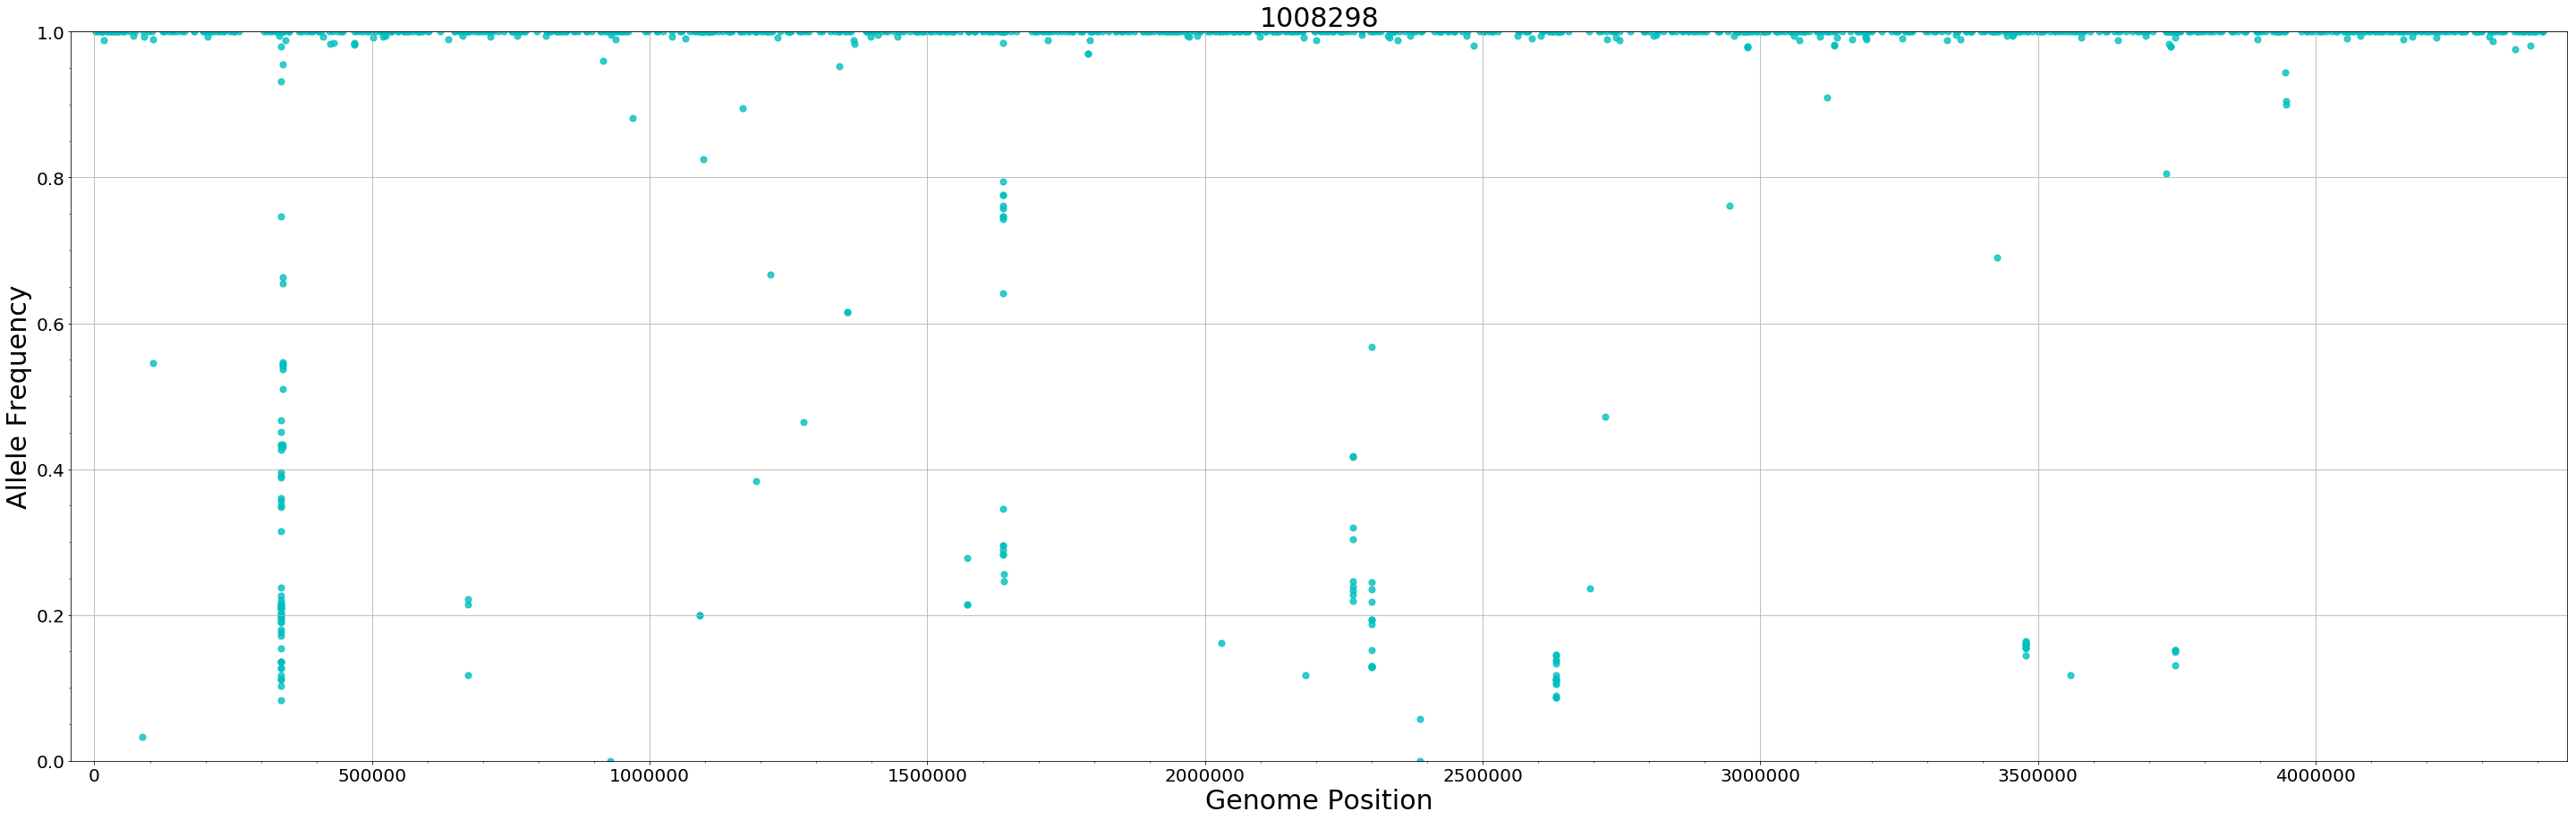

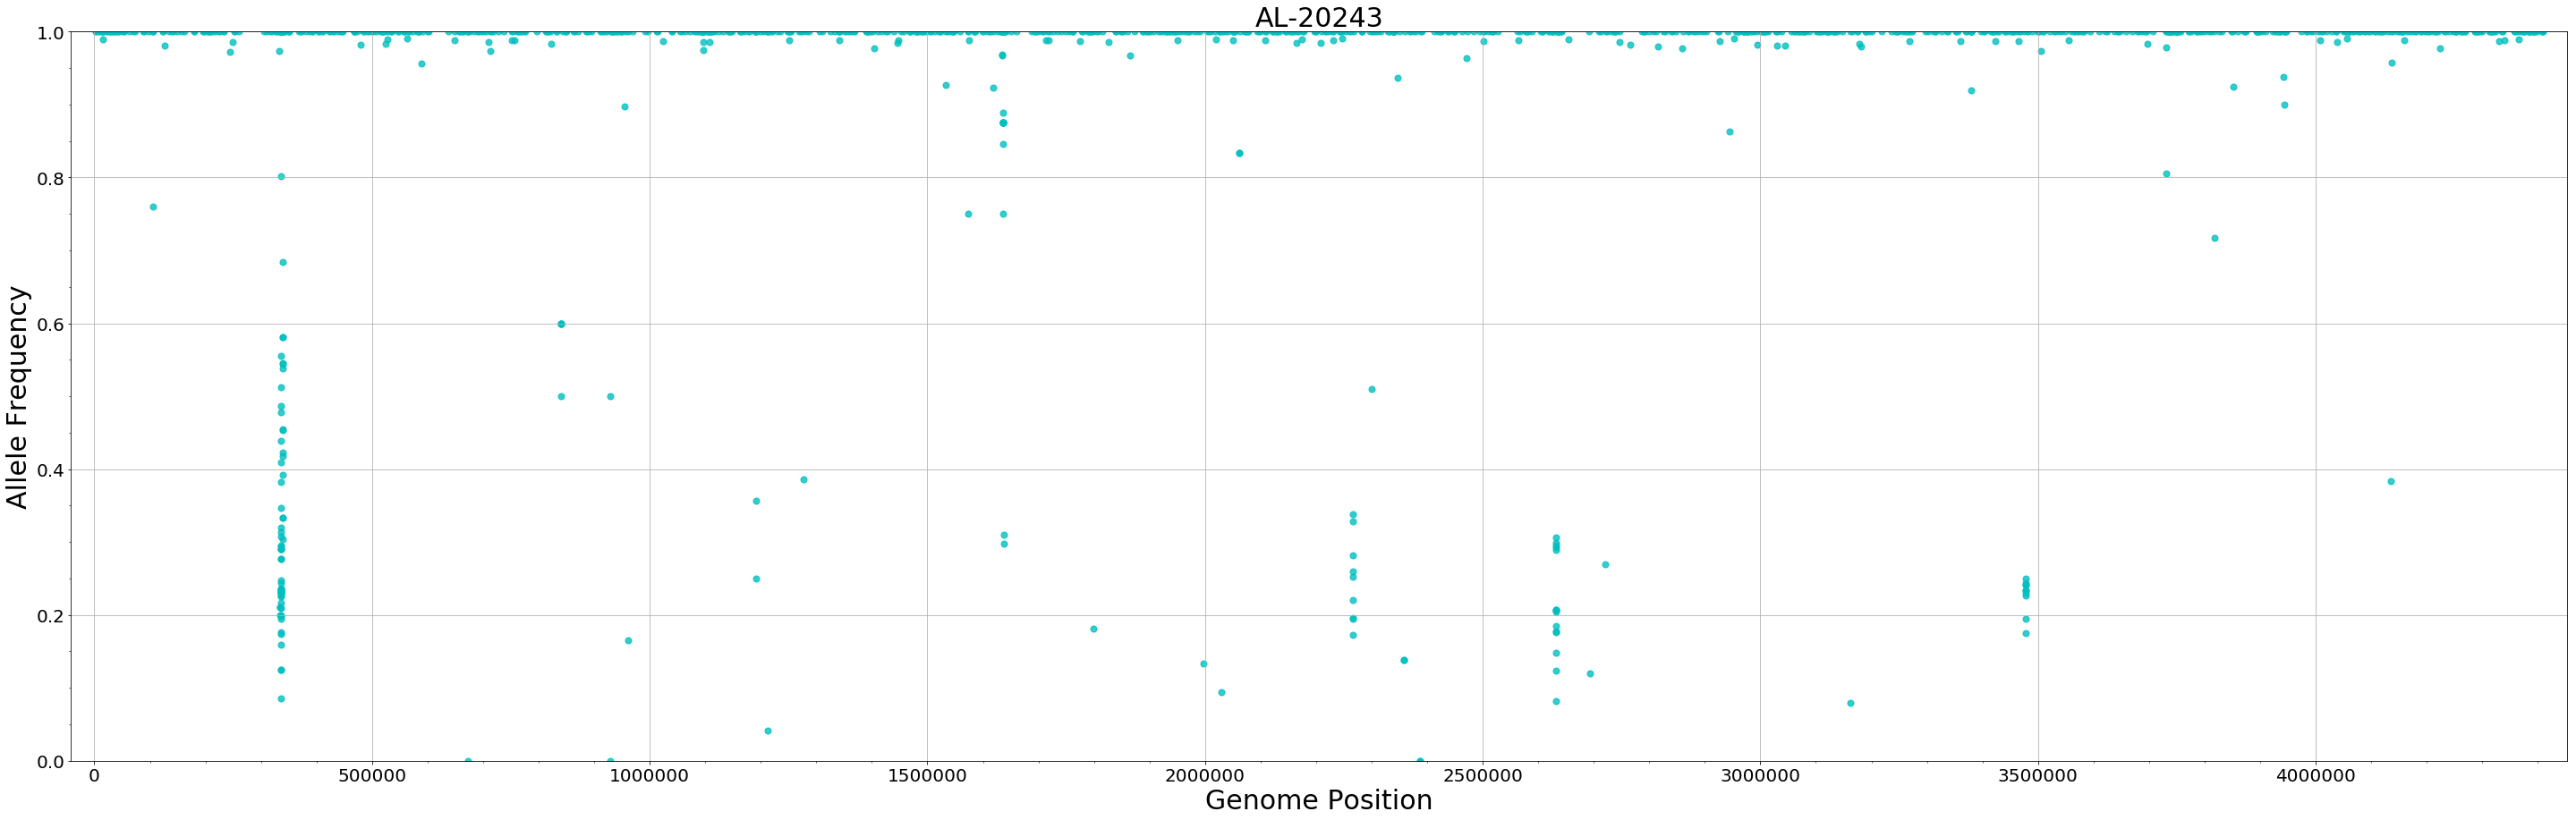

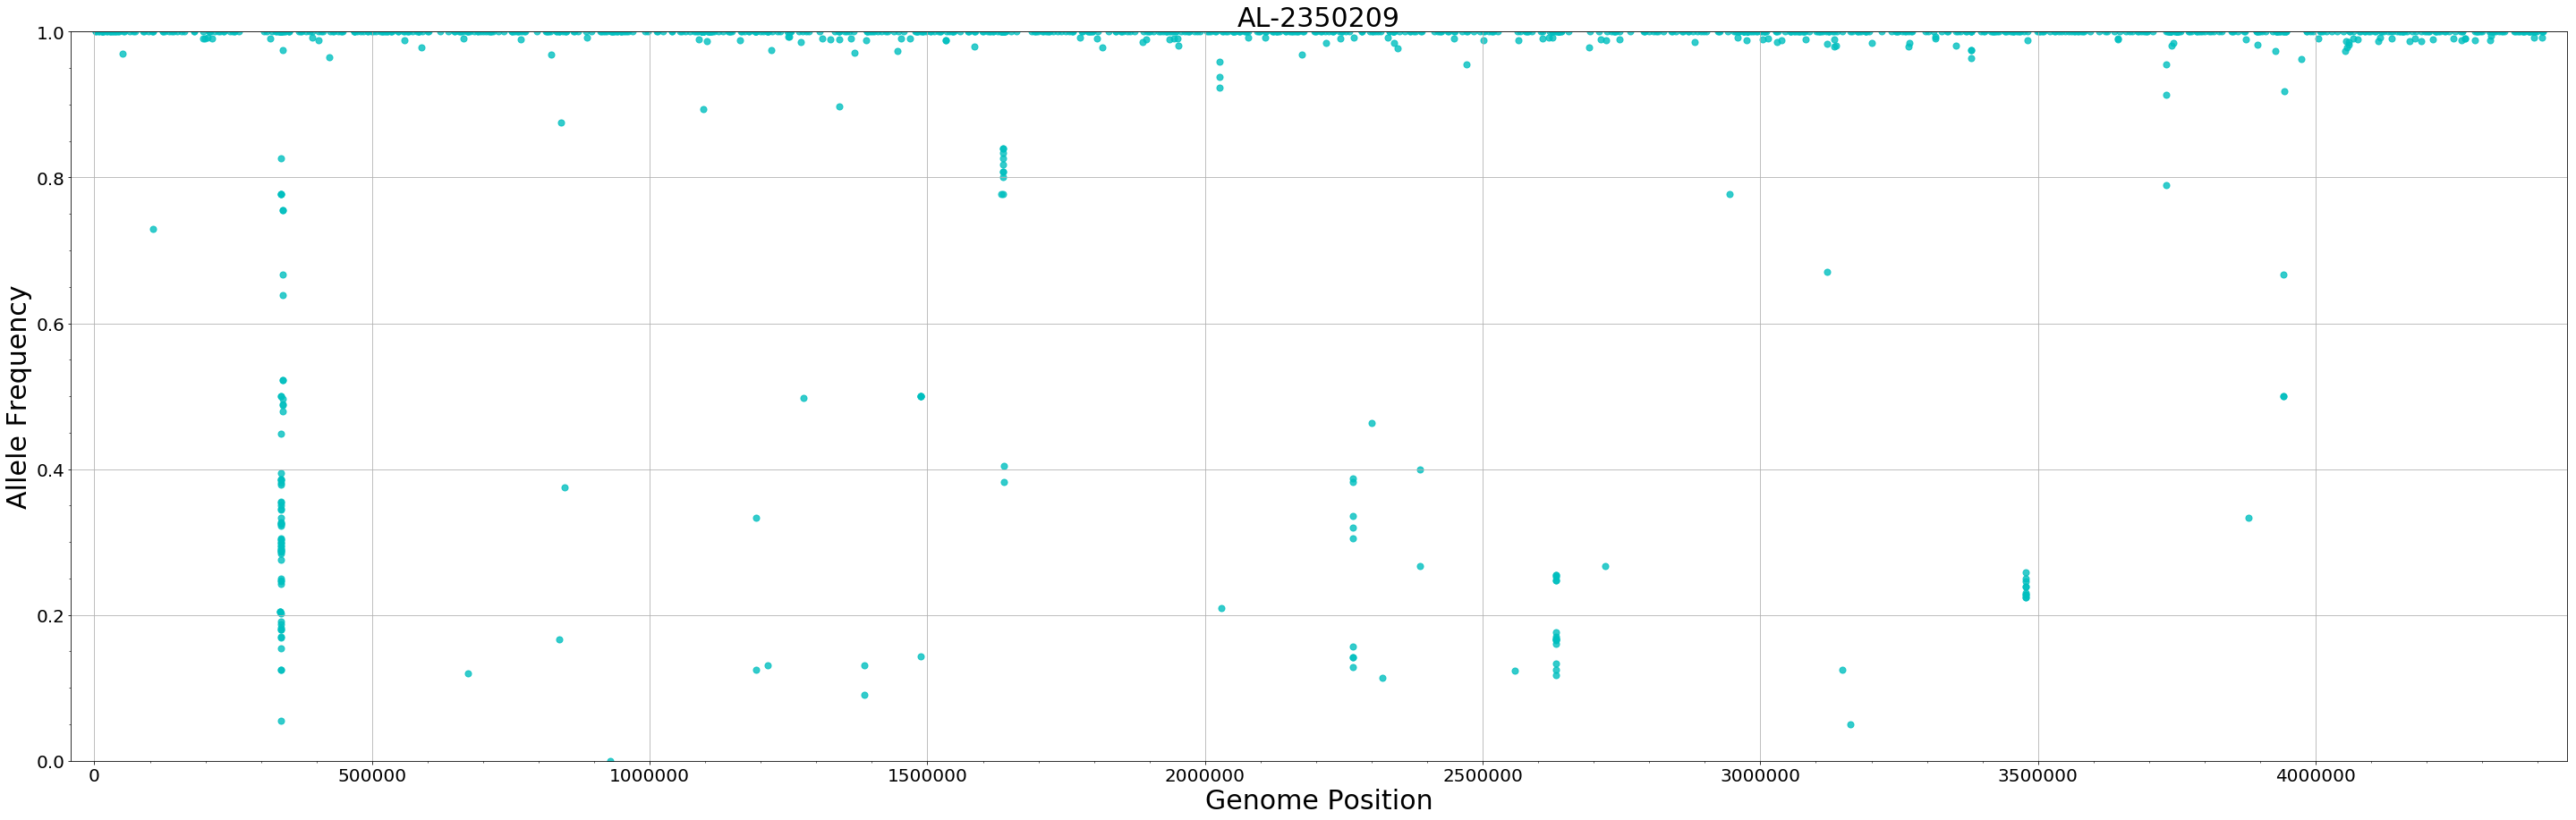

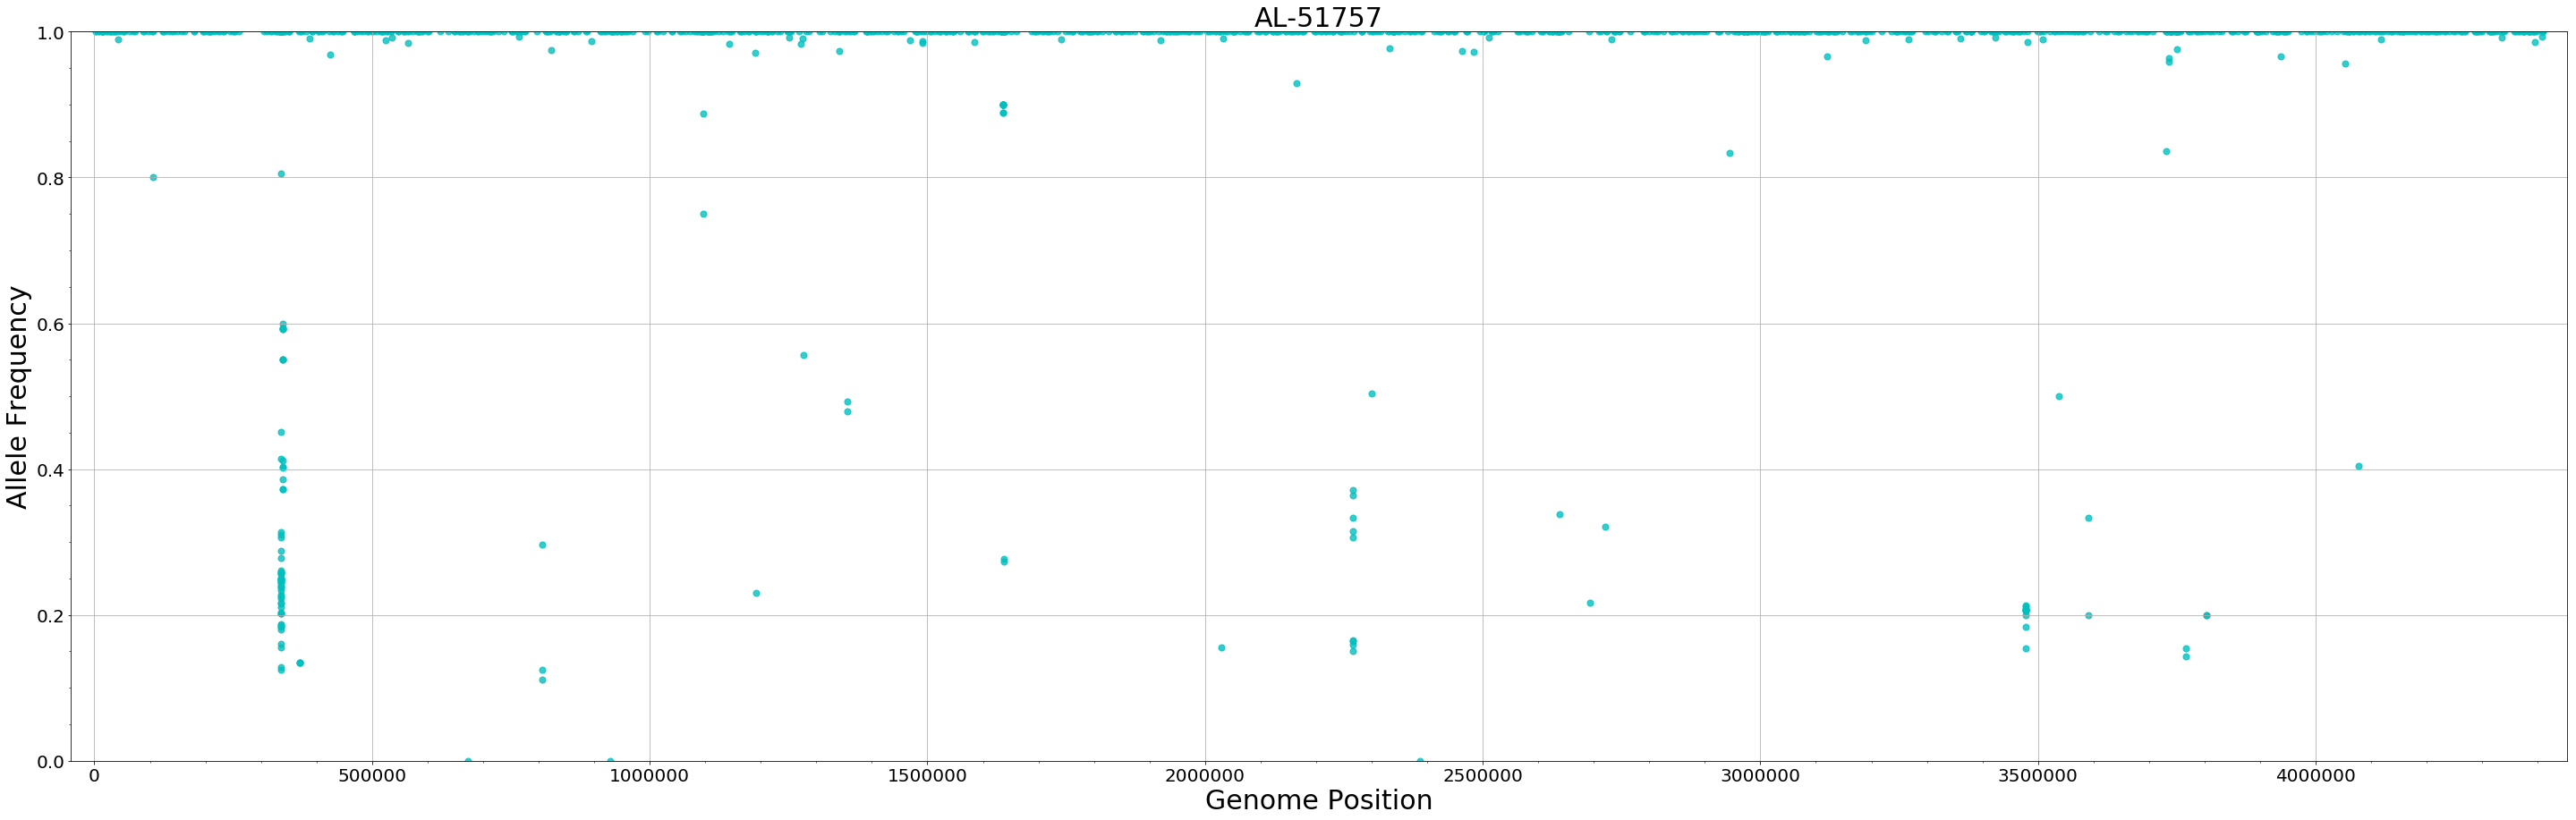

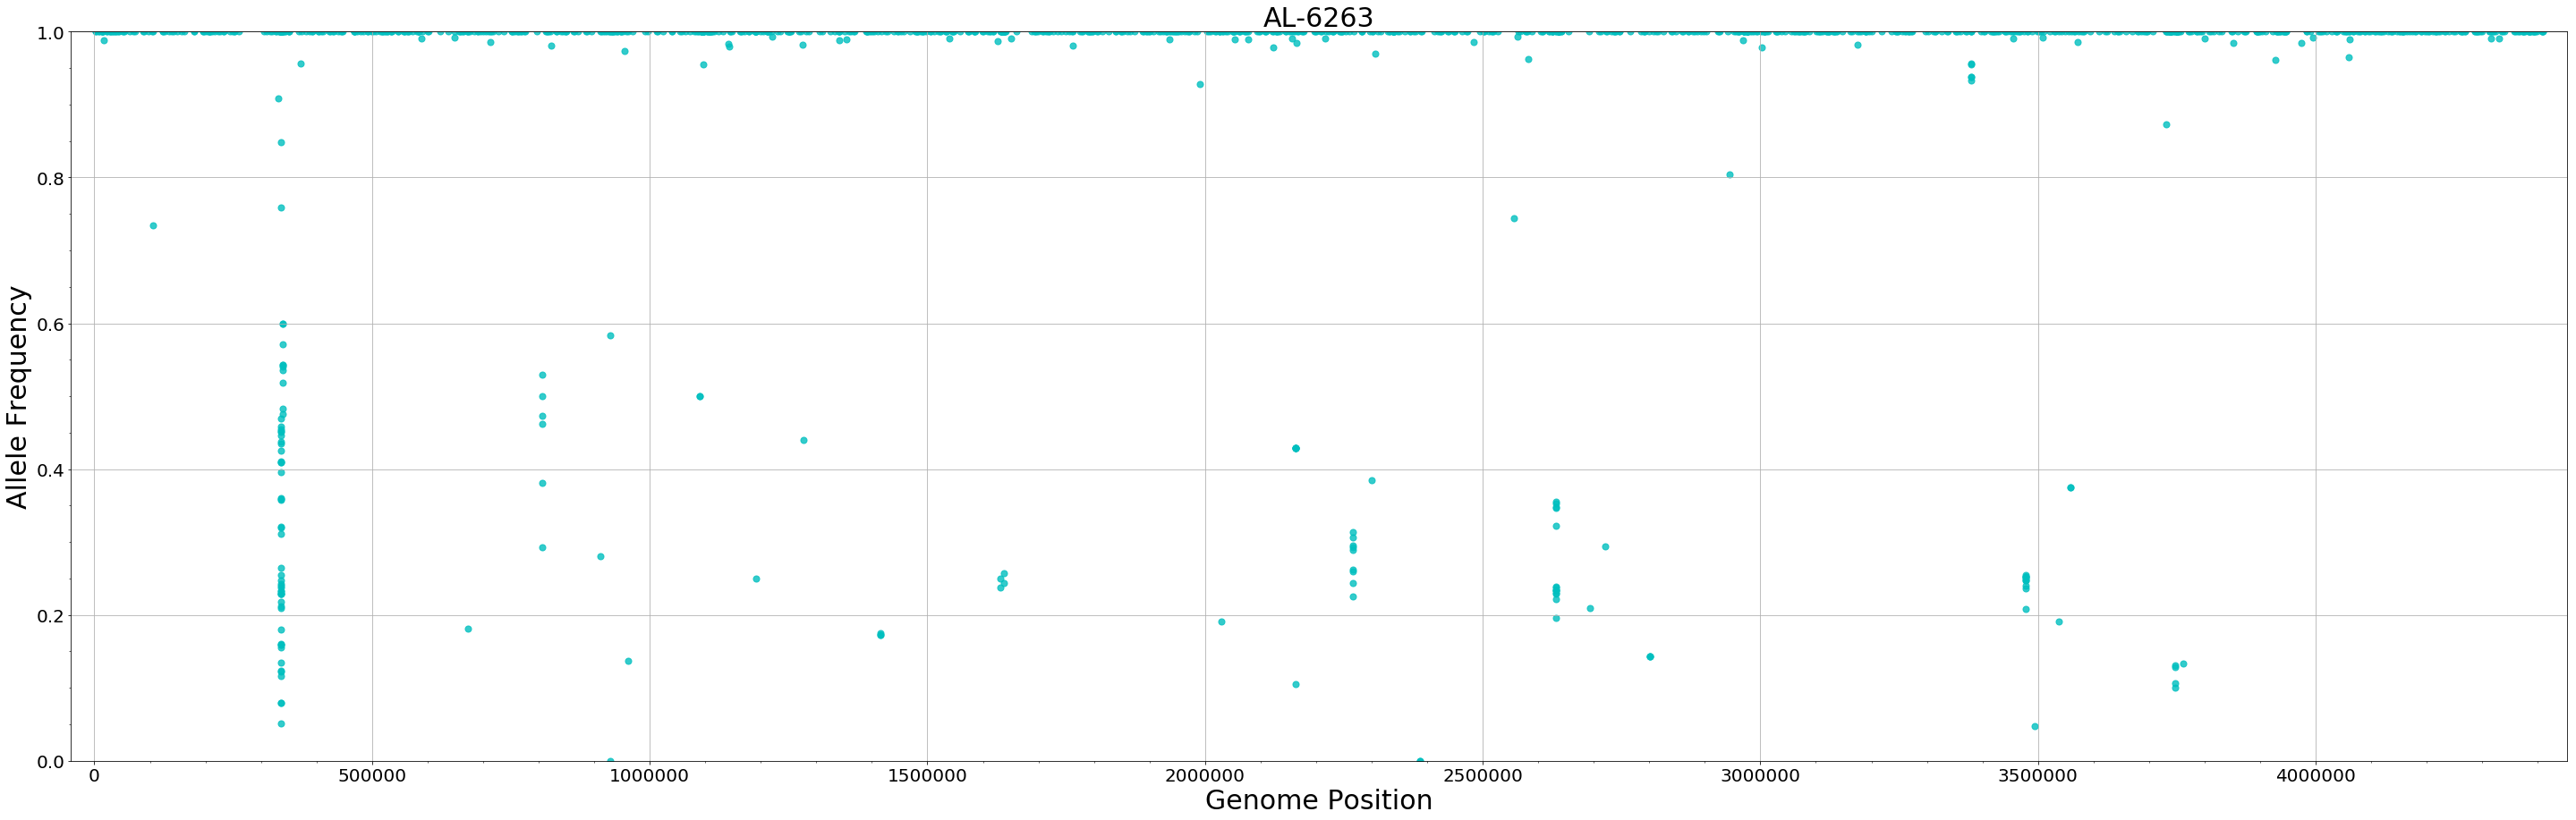

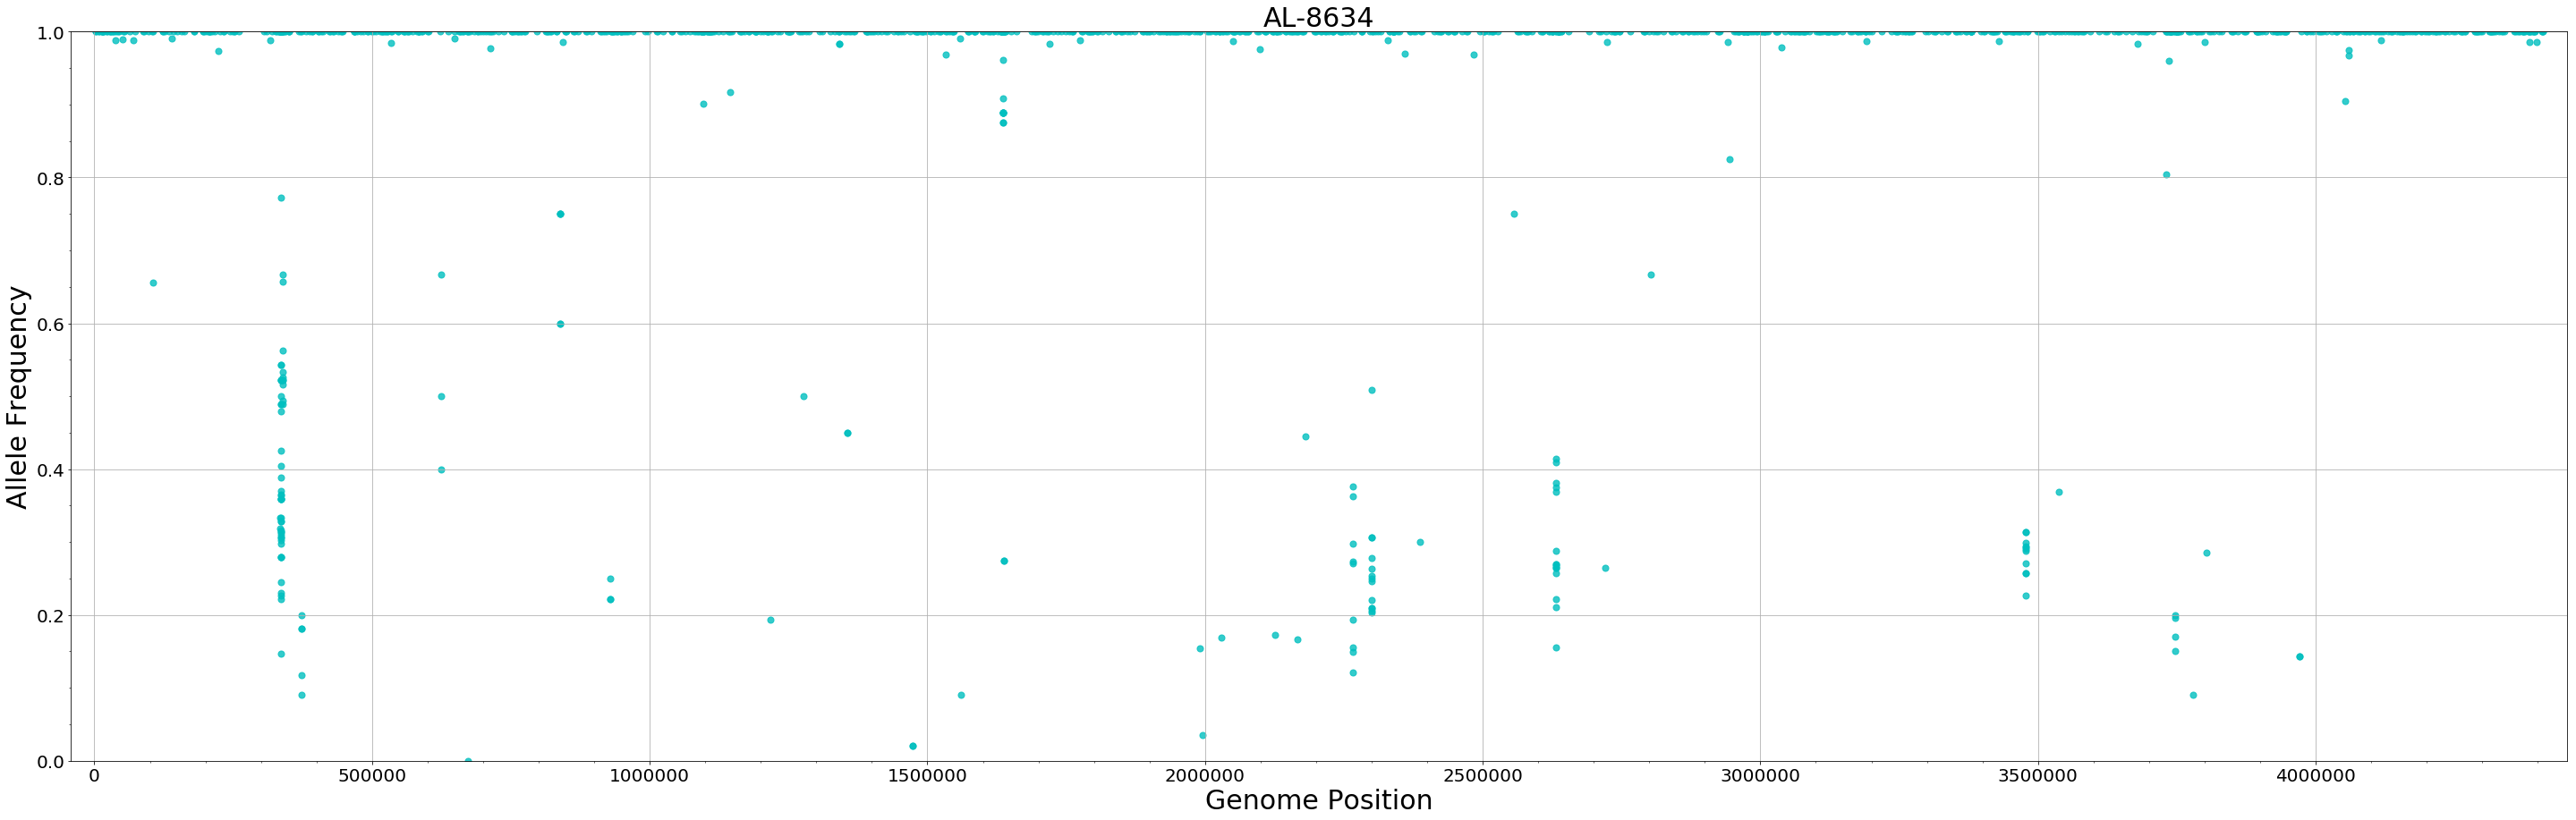

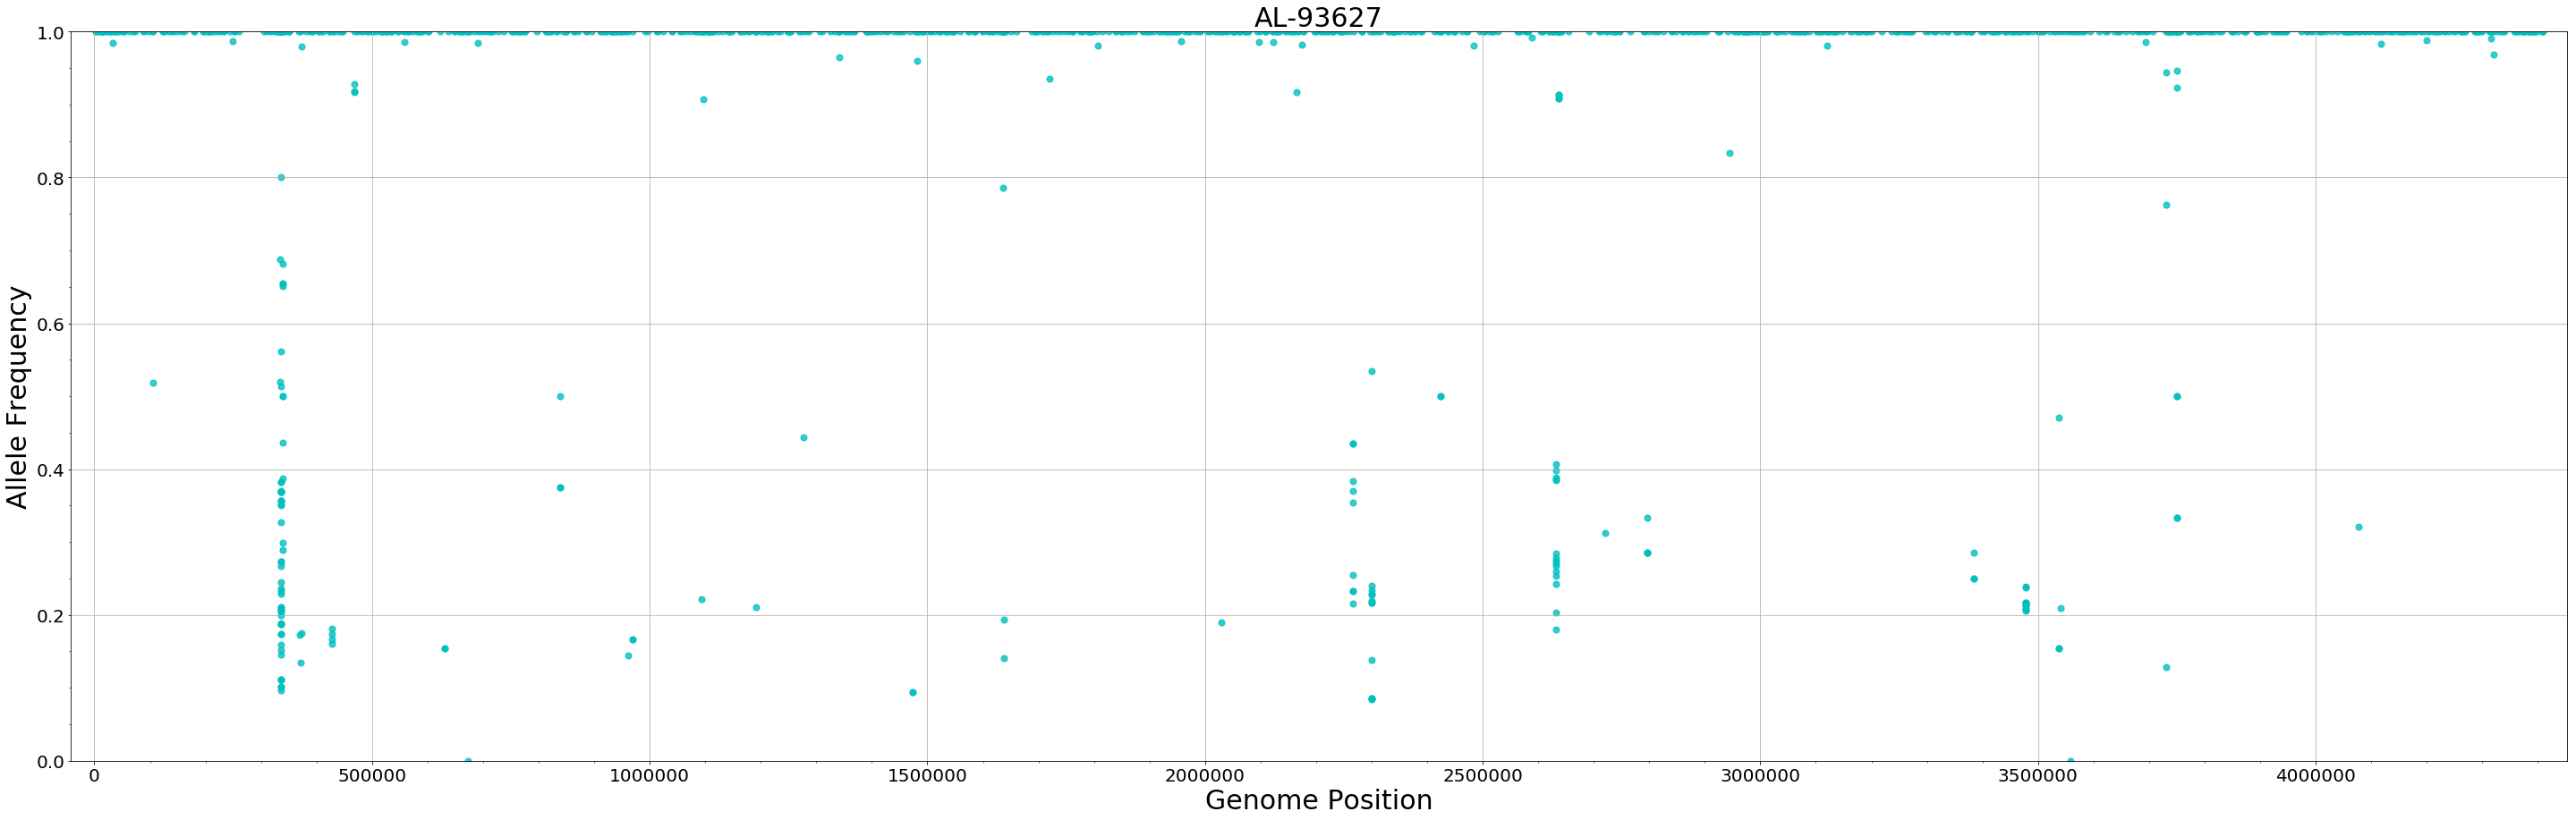

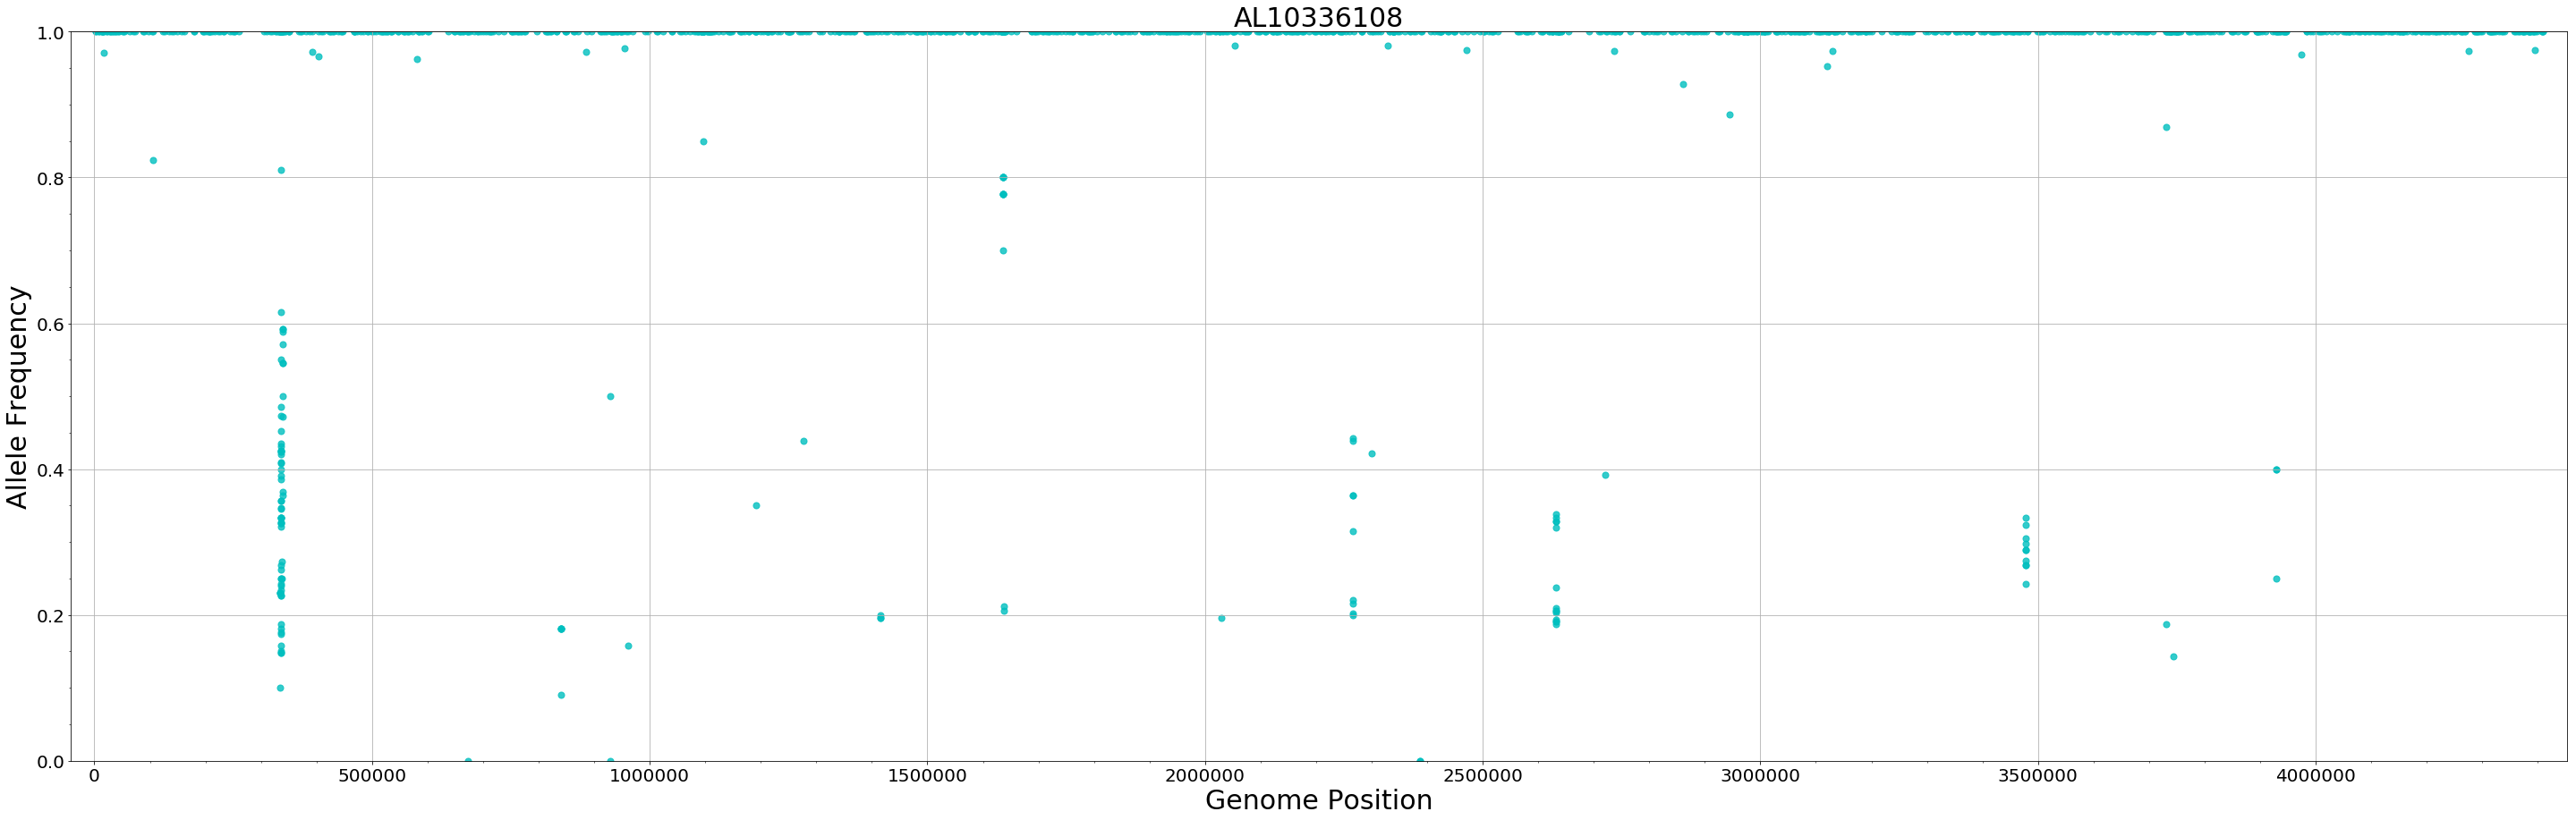

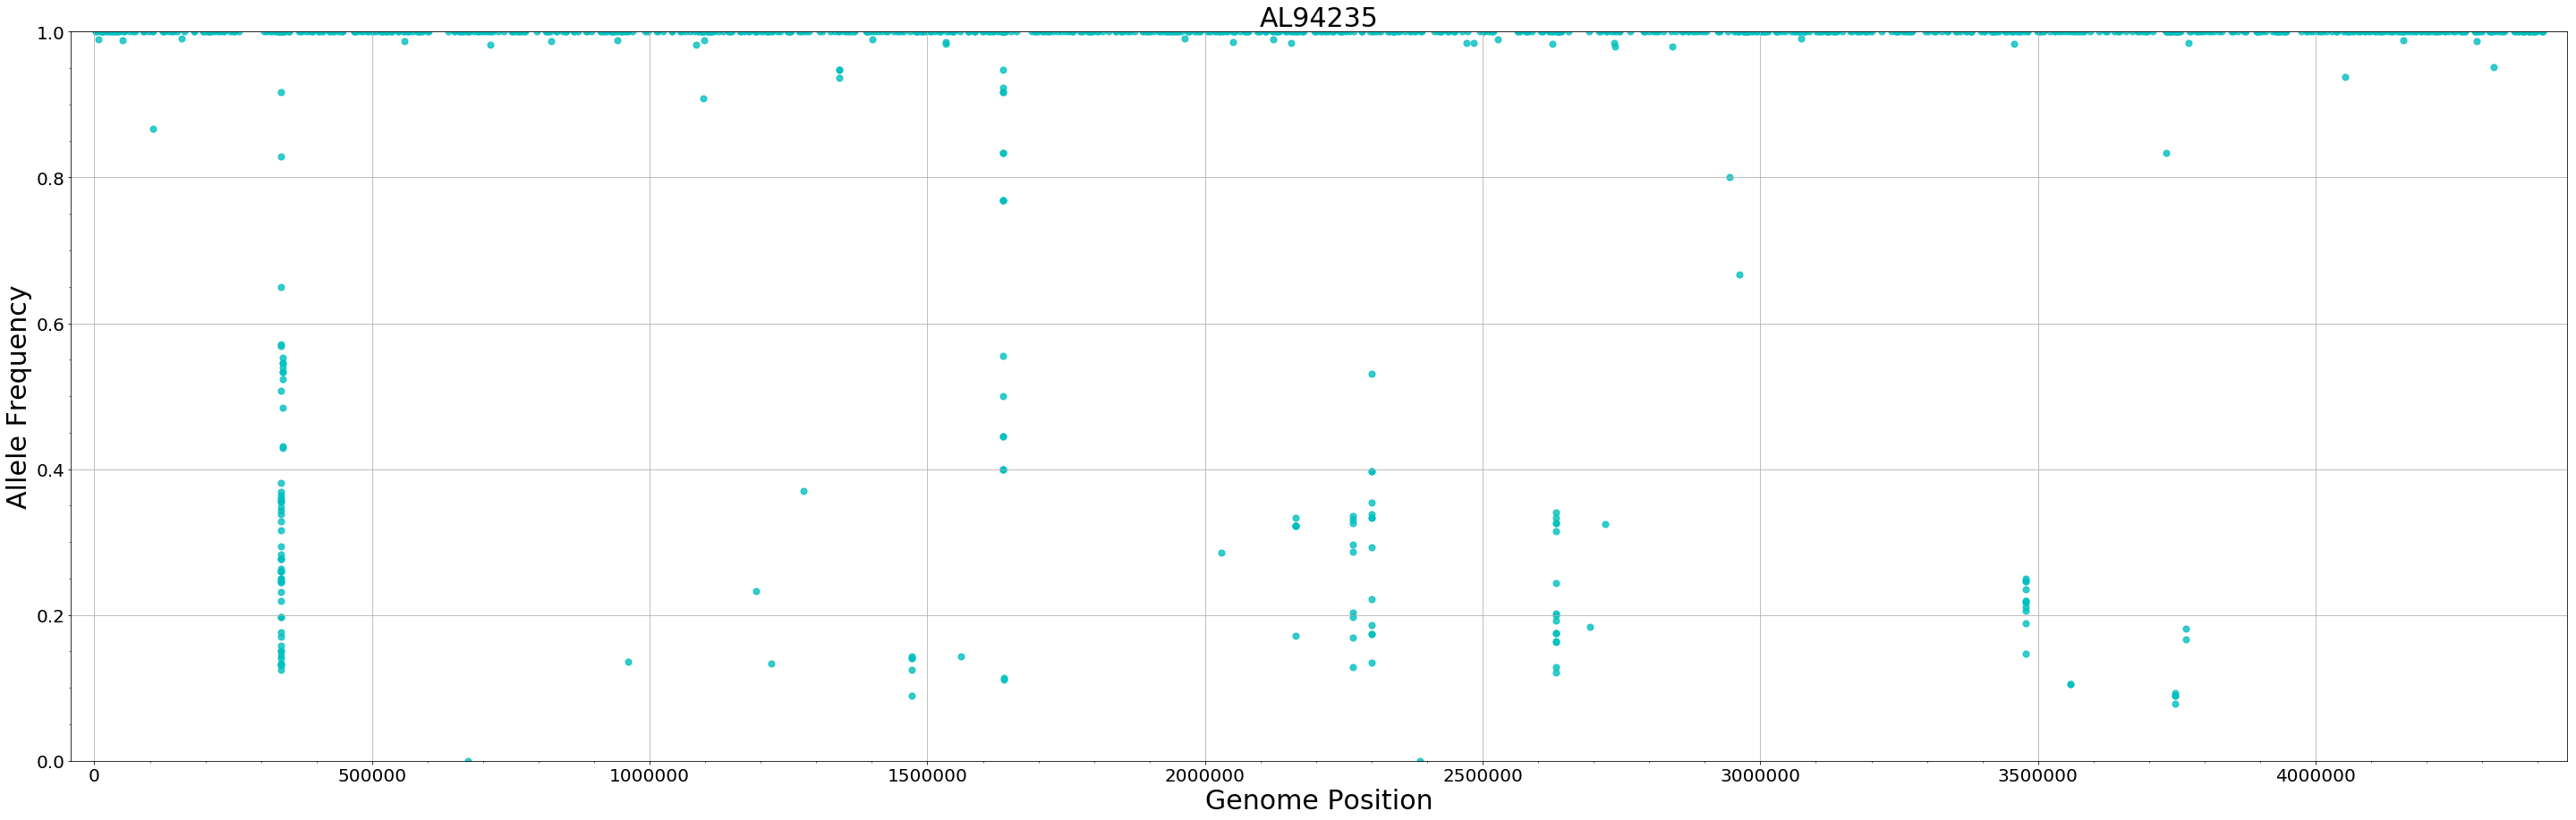

In [36]:
for name_df, df in dict_vcf.items():
    
    scatter_vcf_pos_vcf_test(df, name_df)

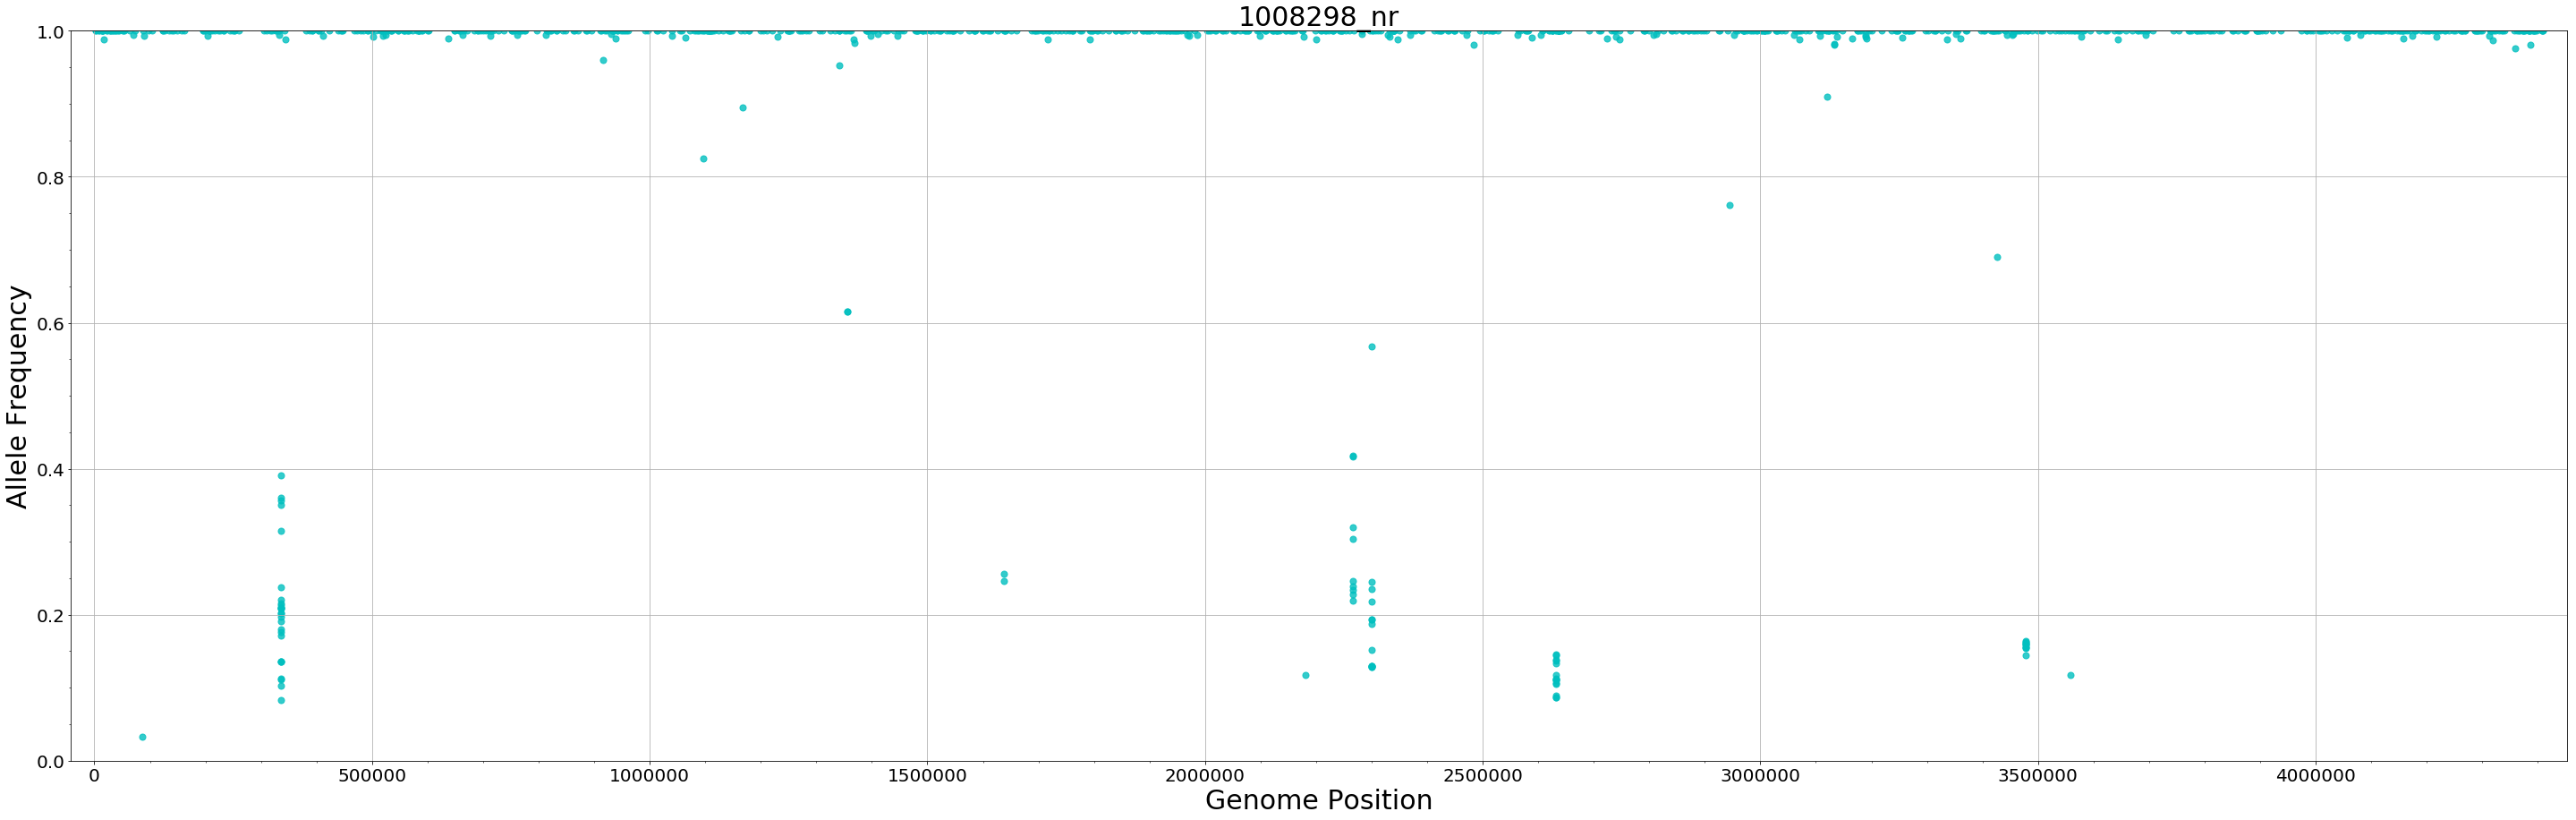

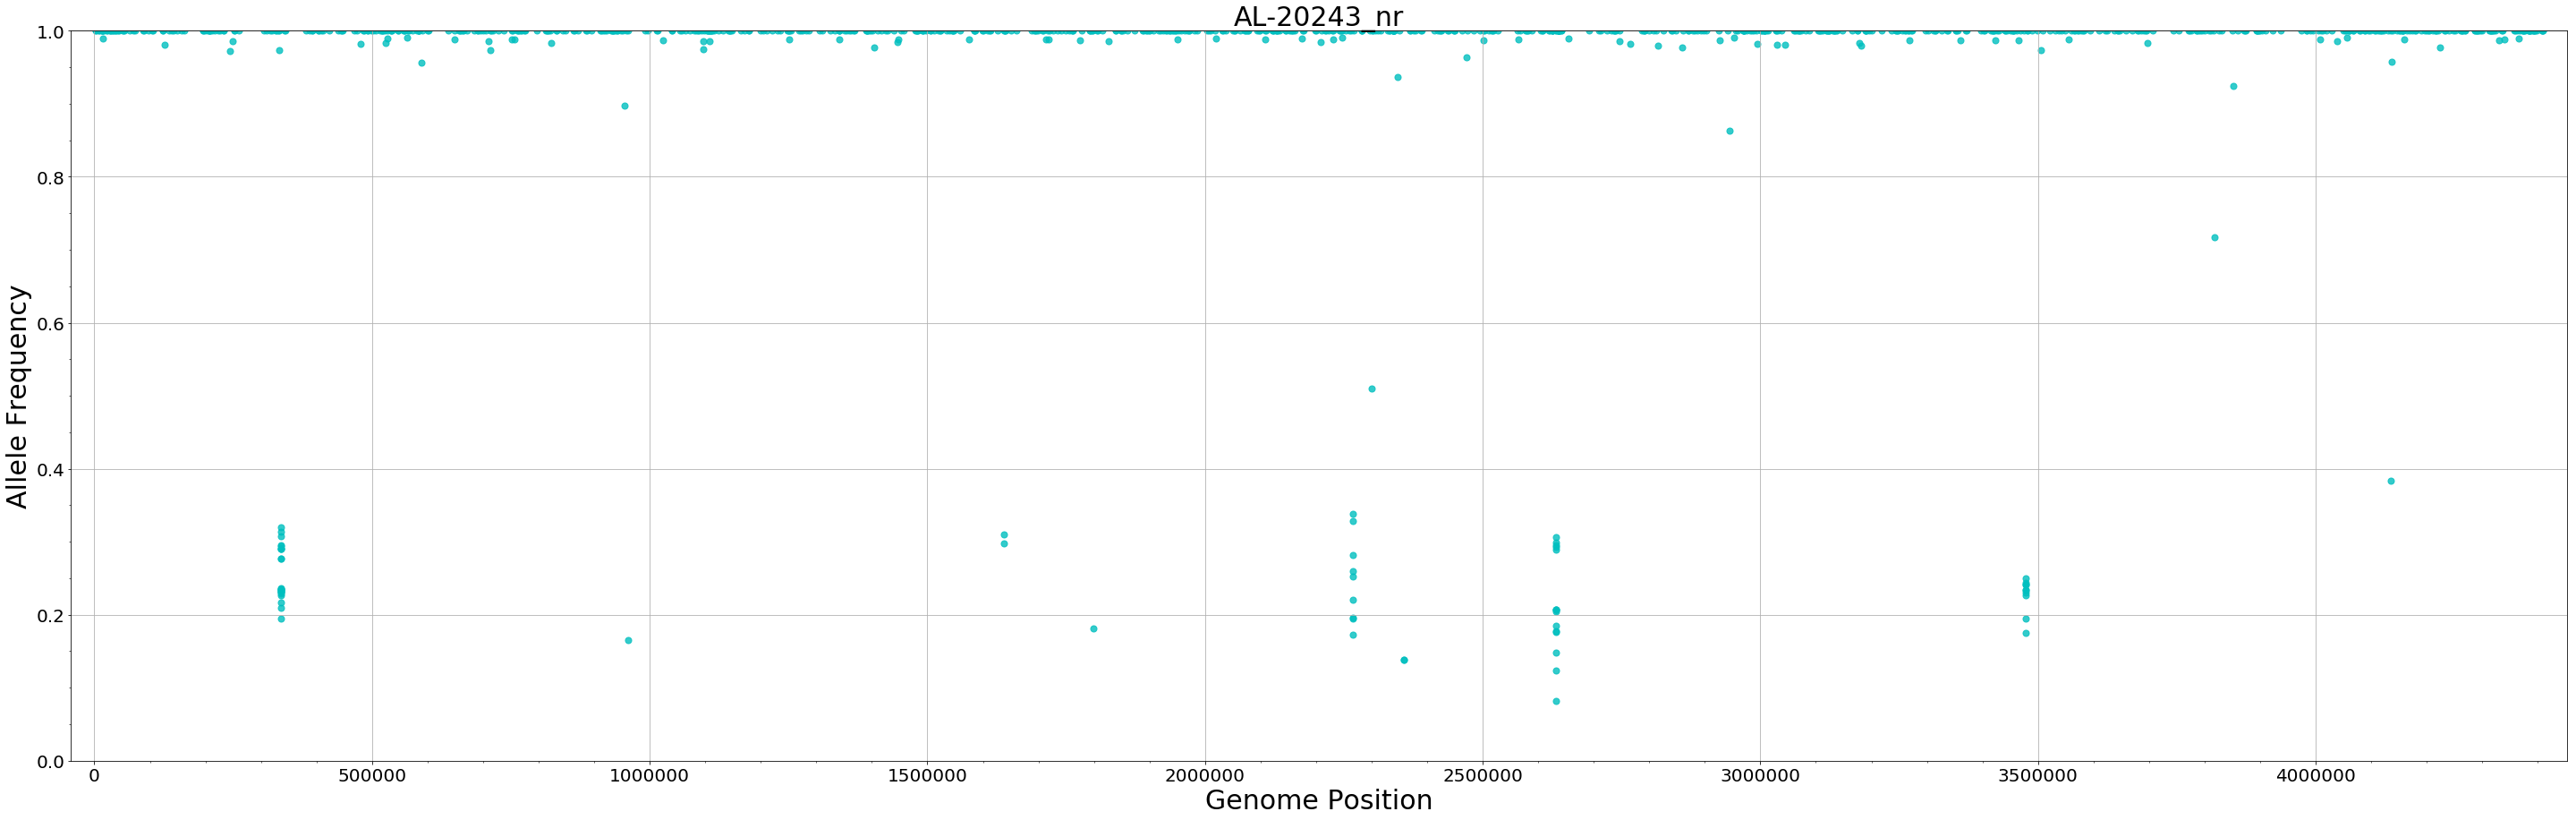

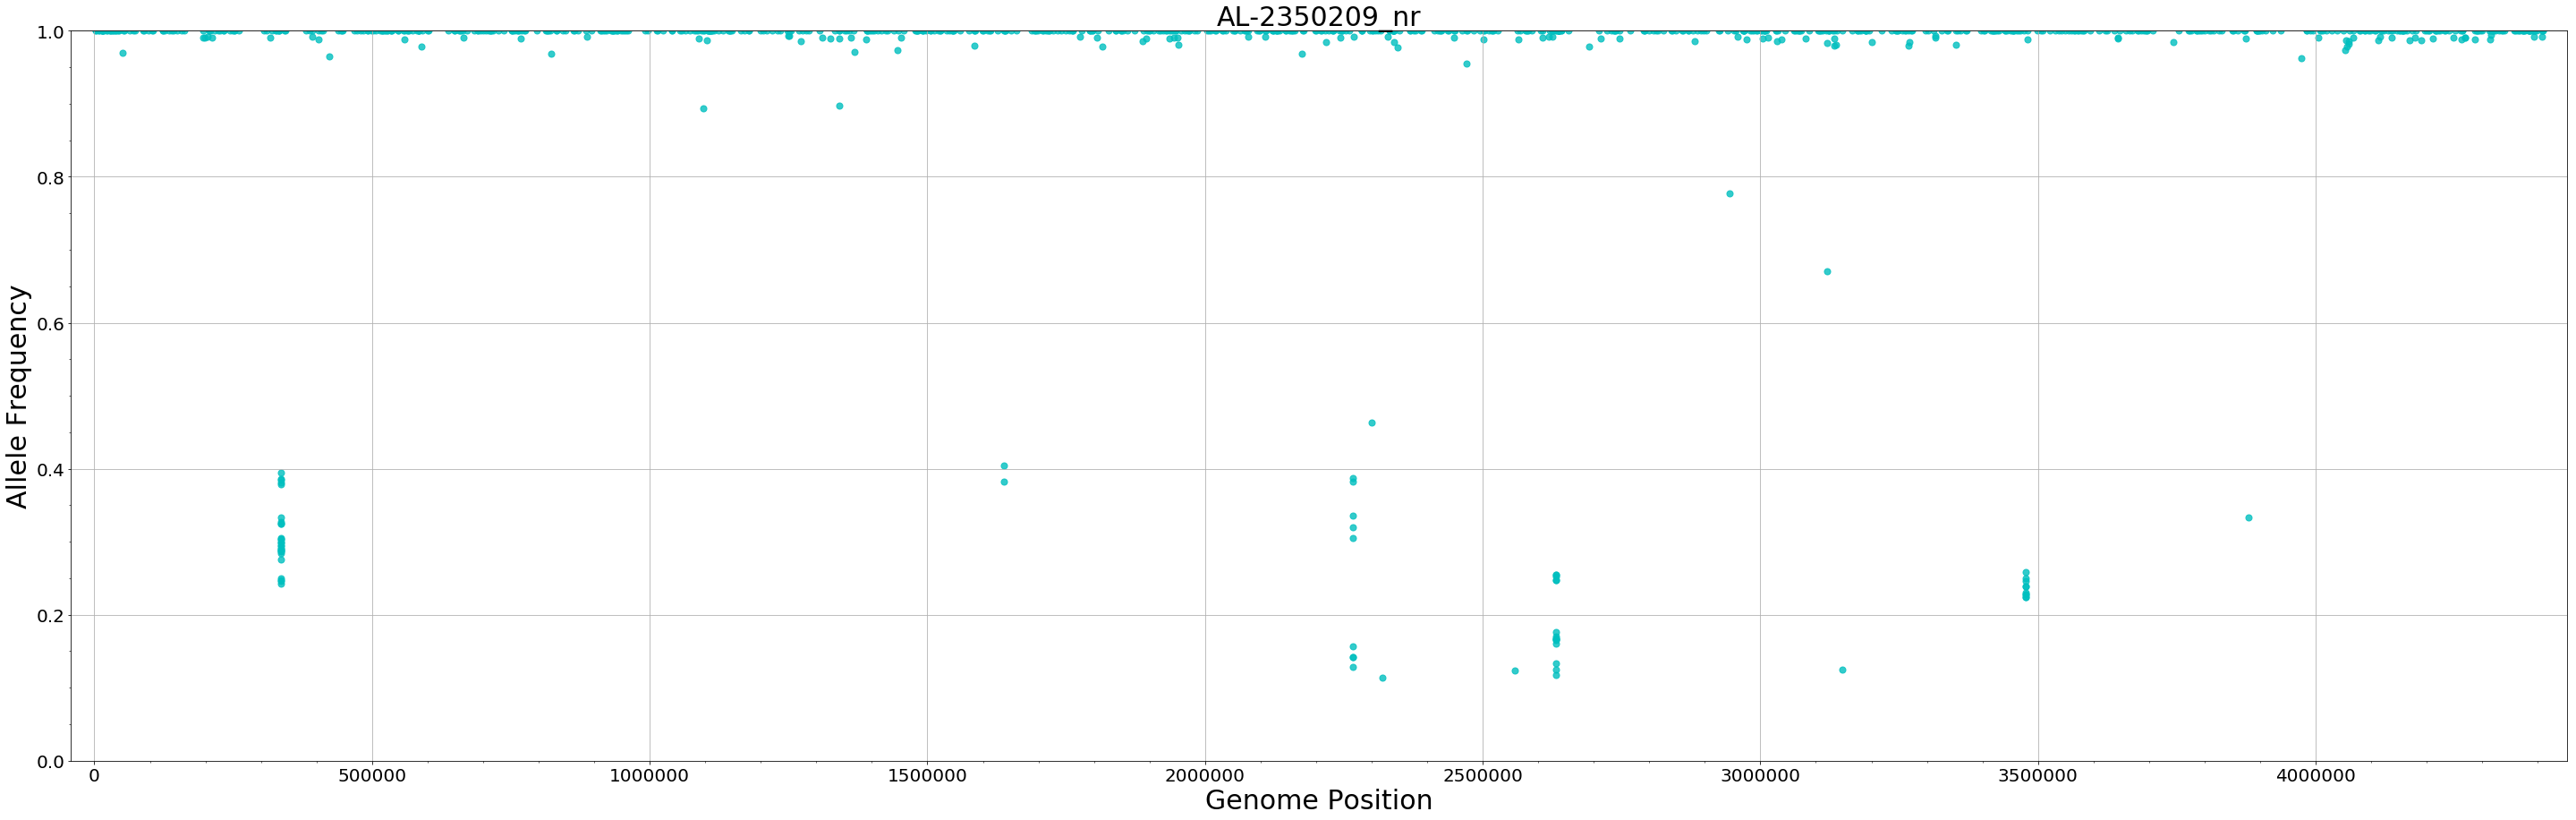

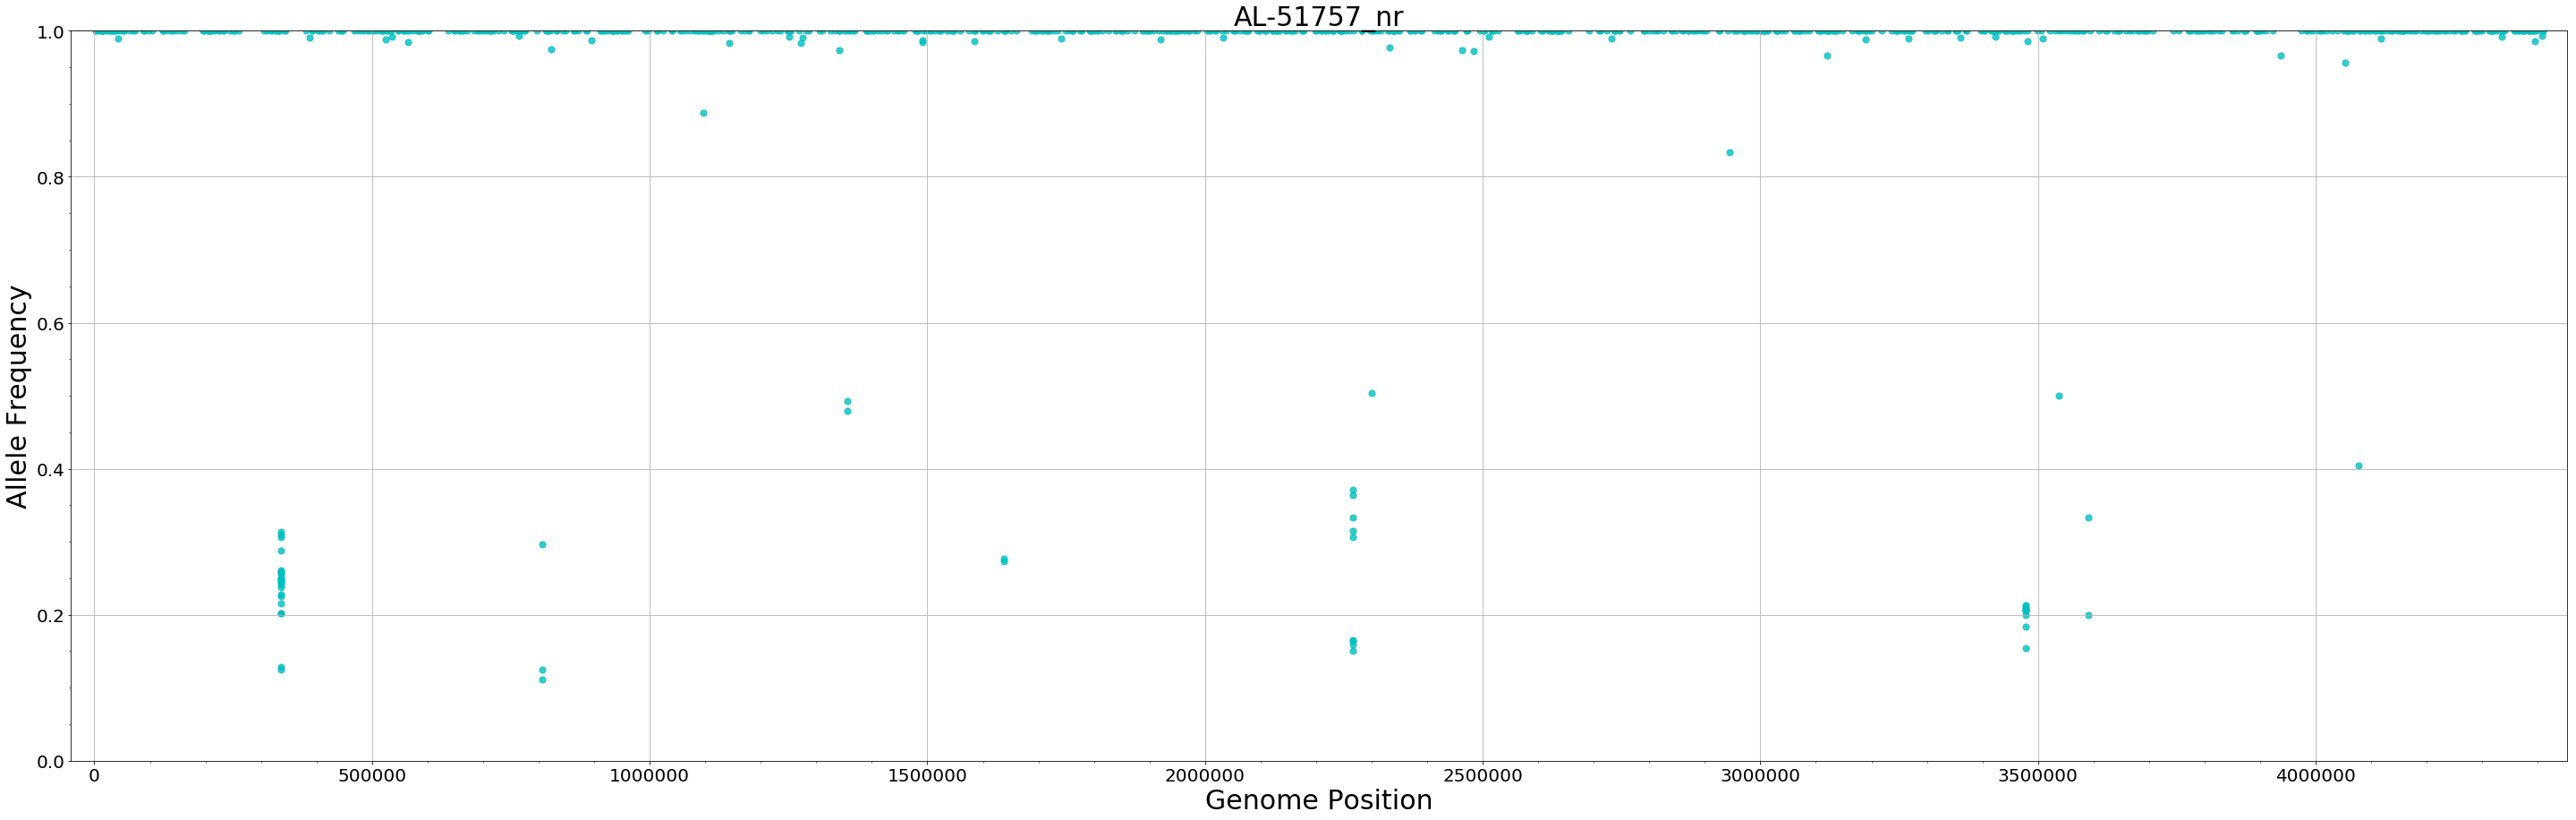

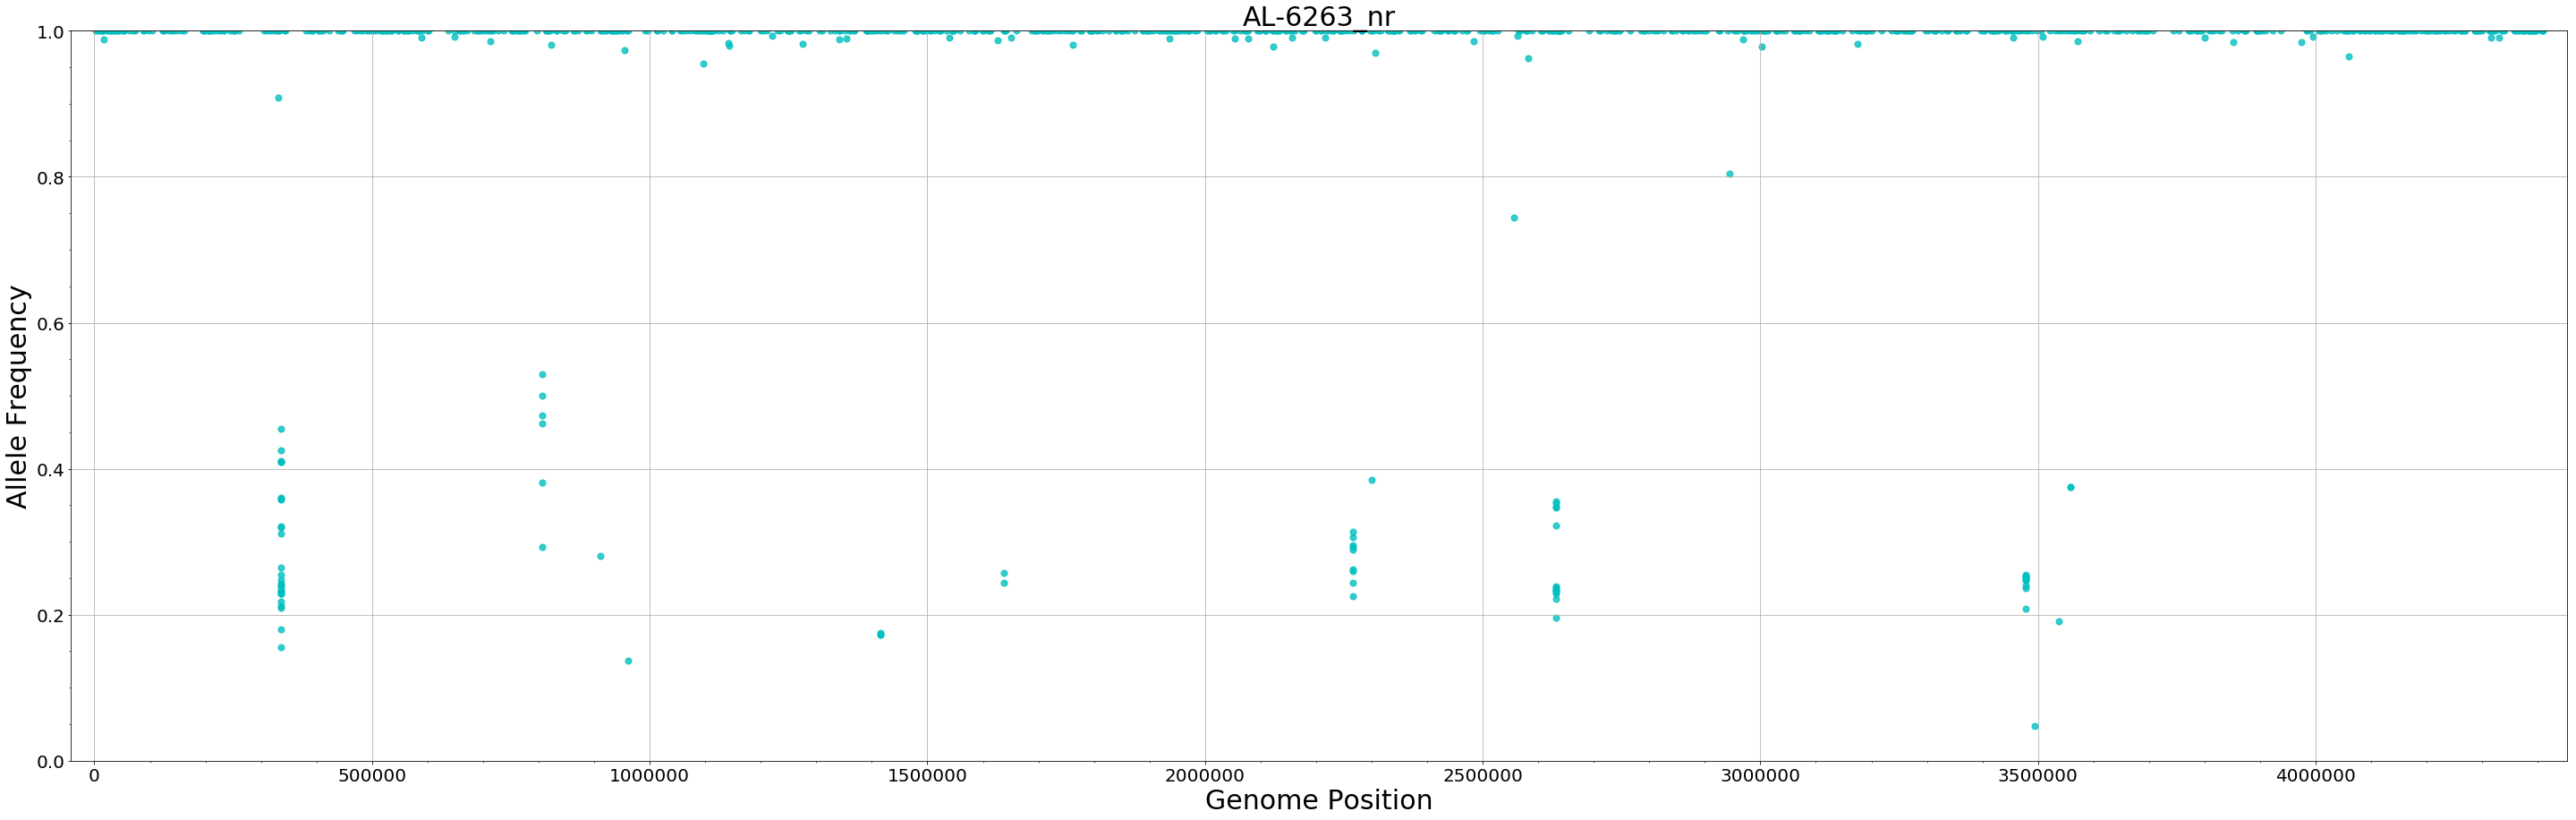

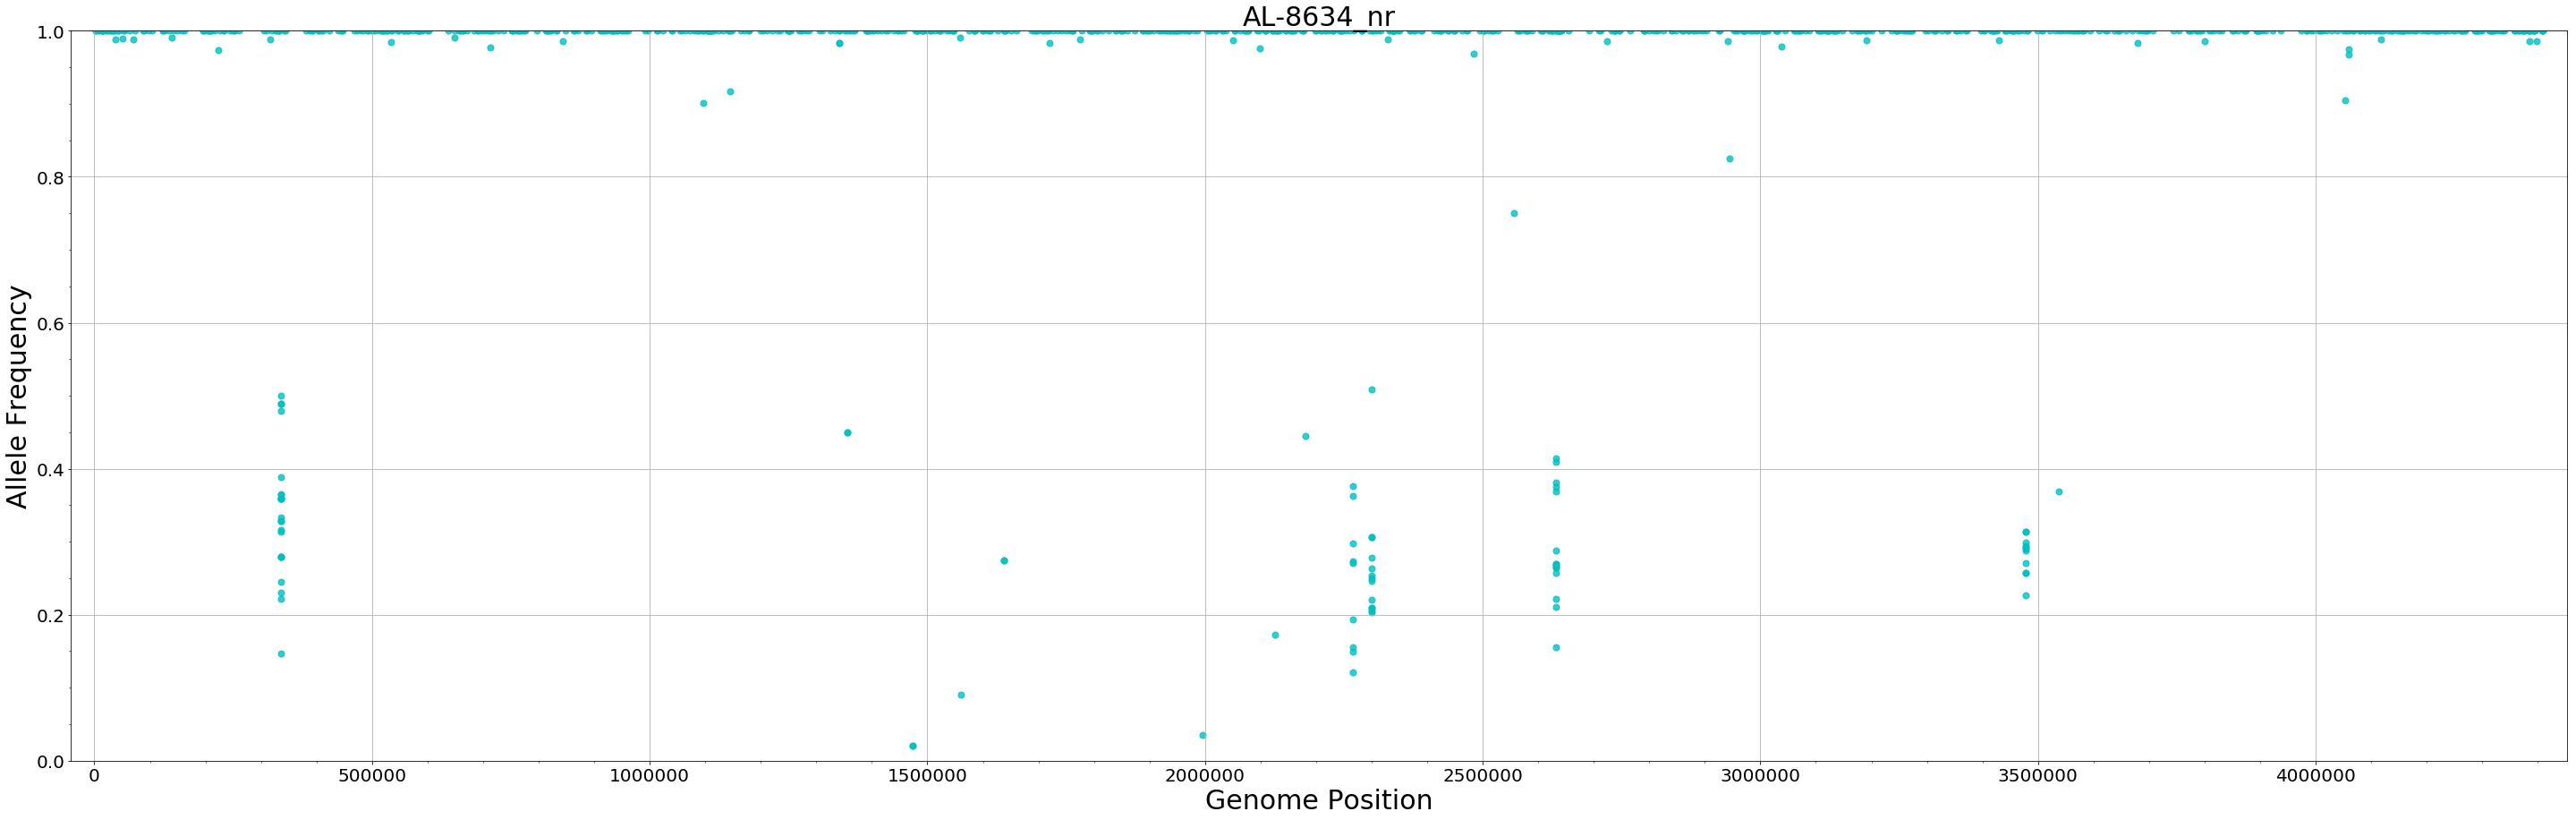

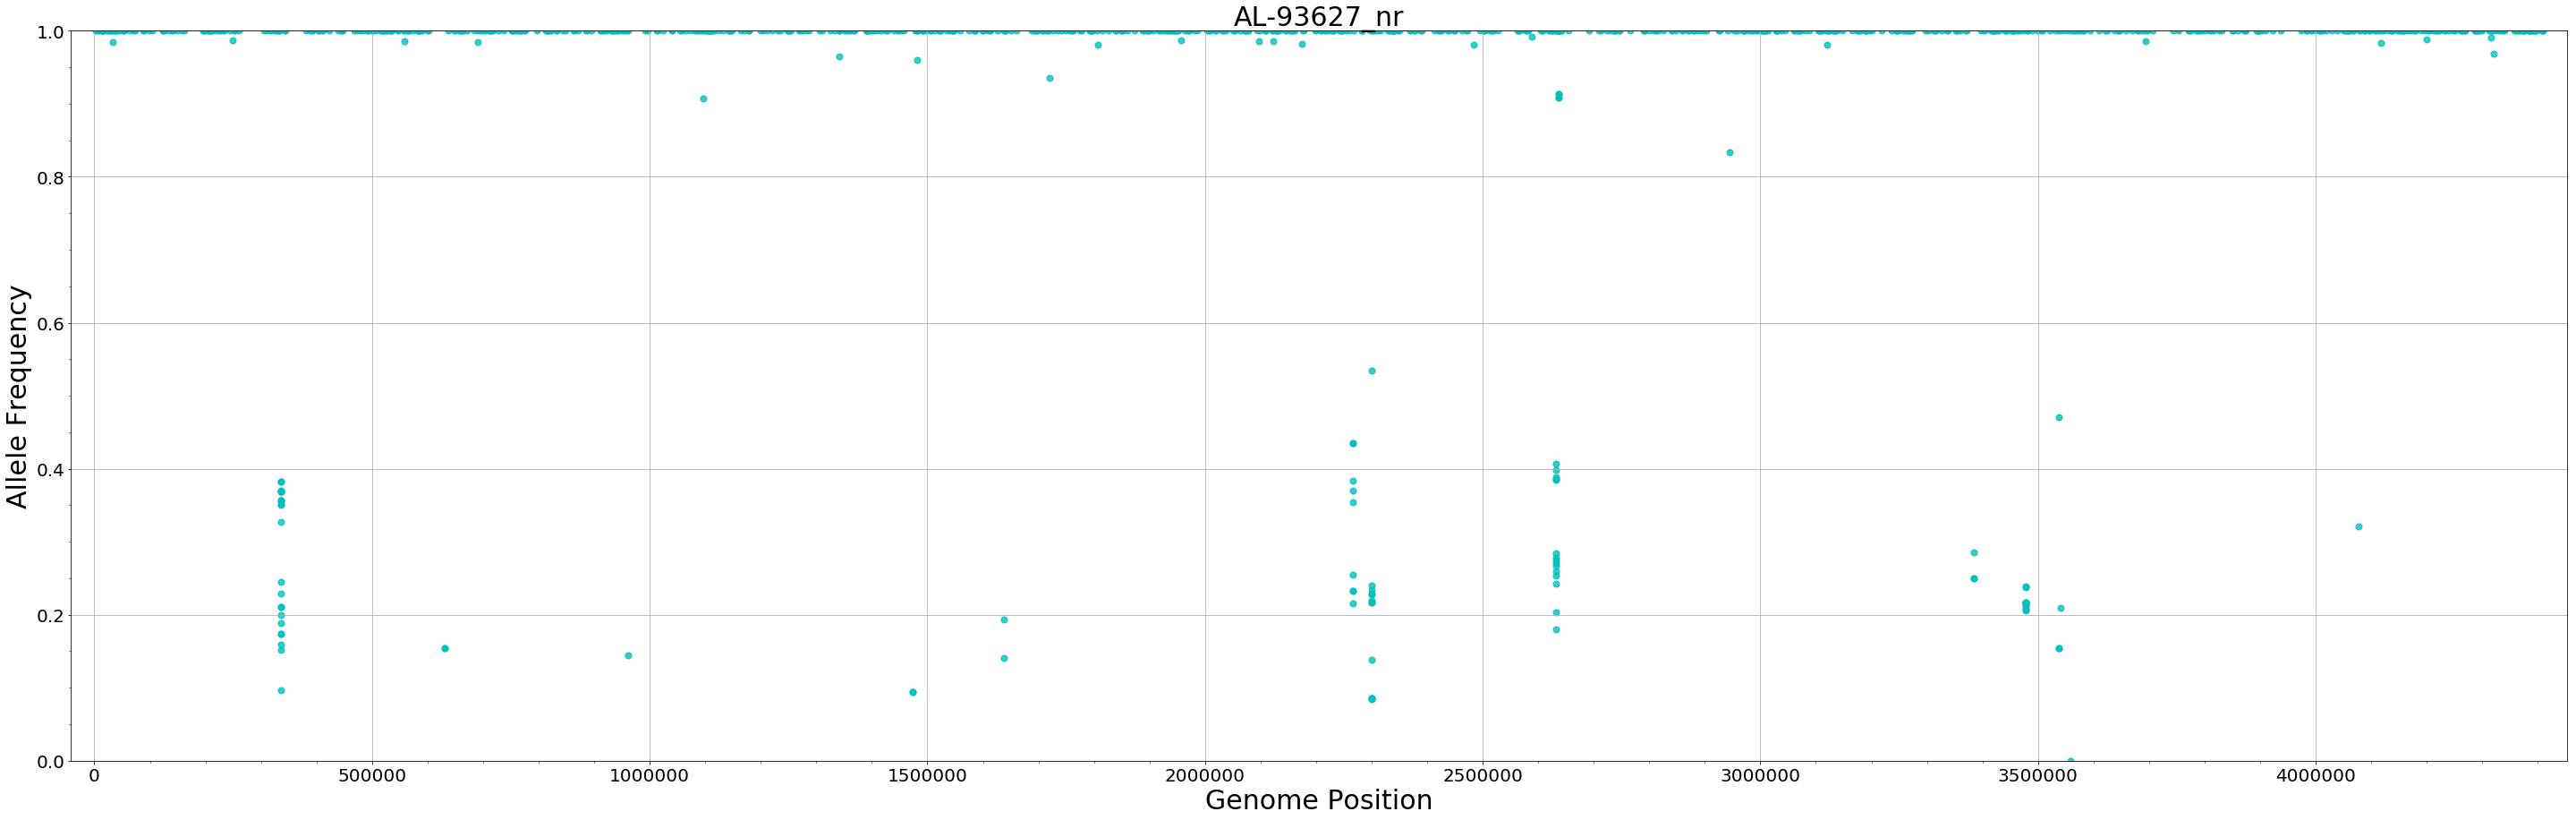

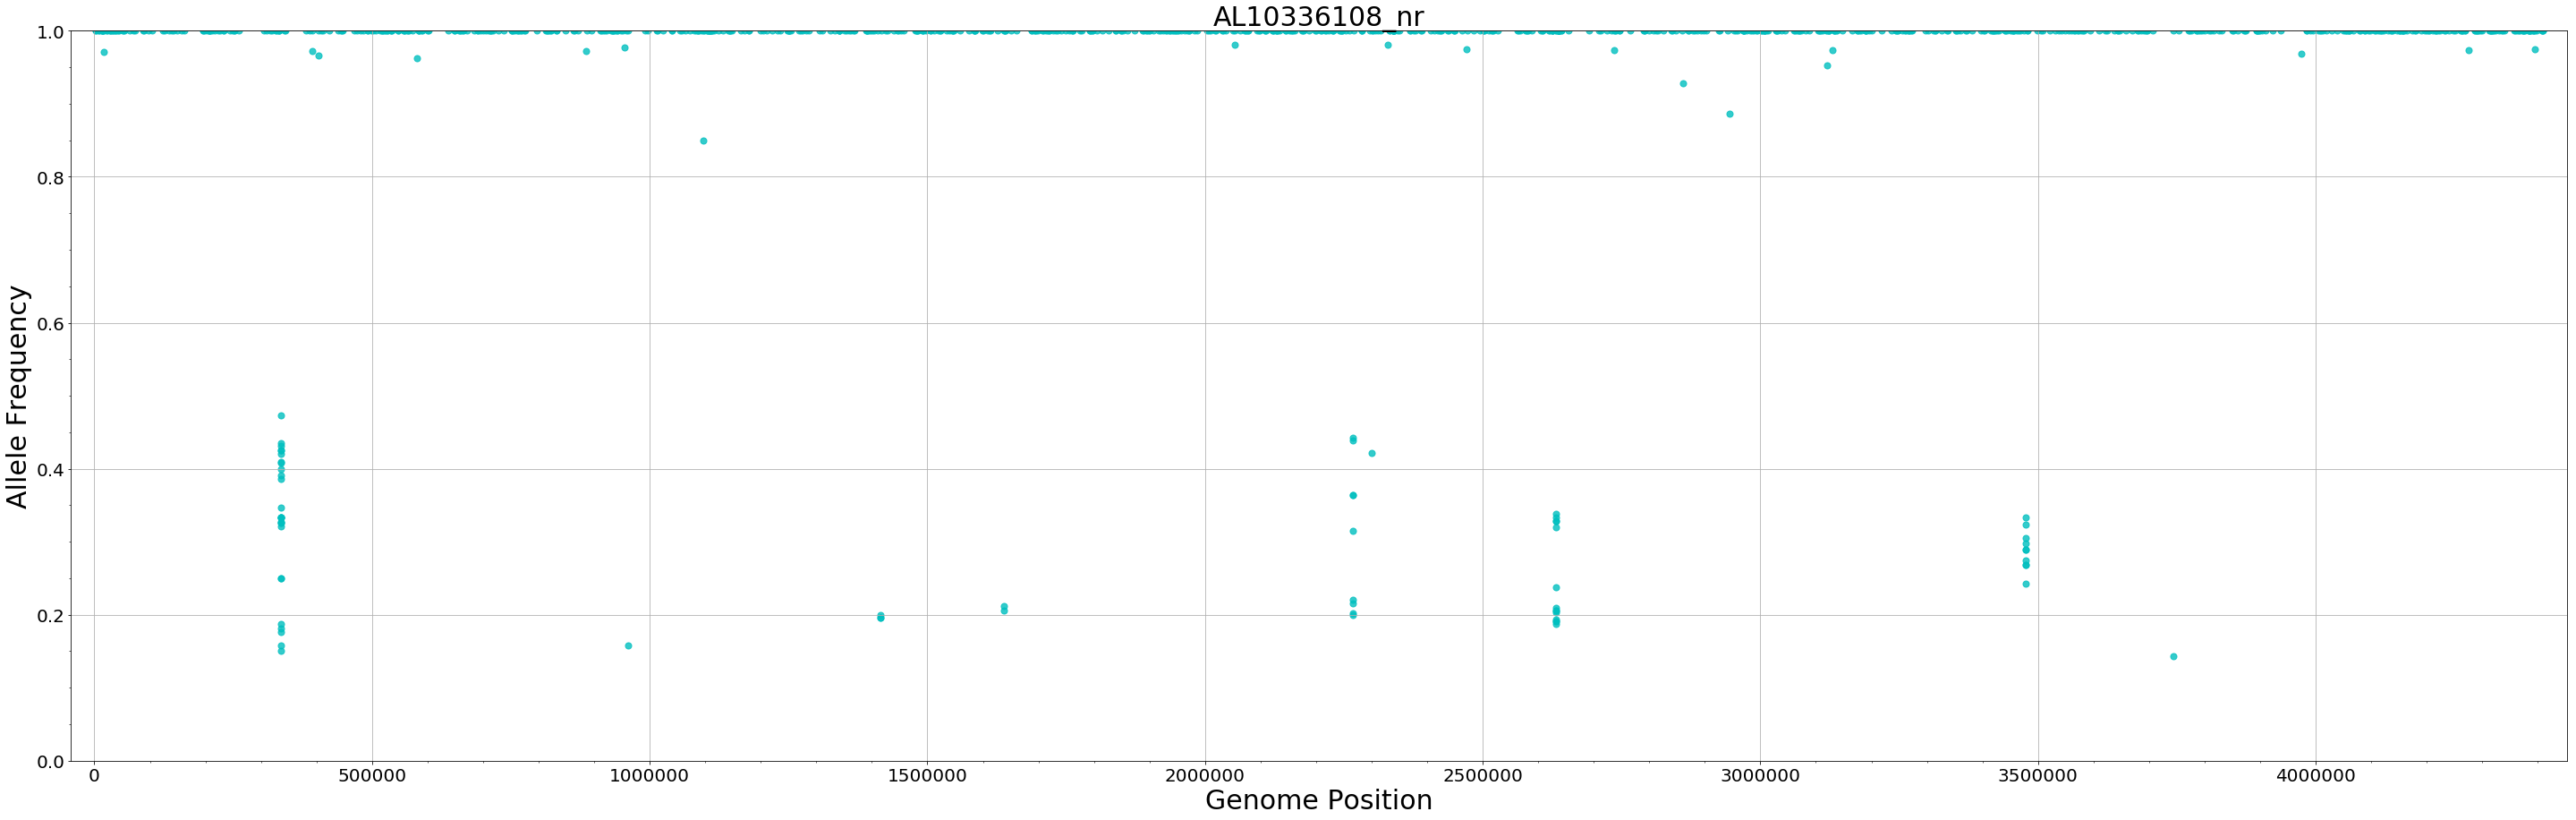

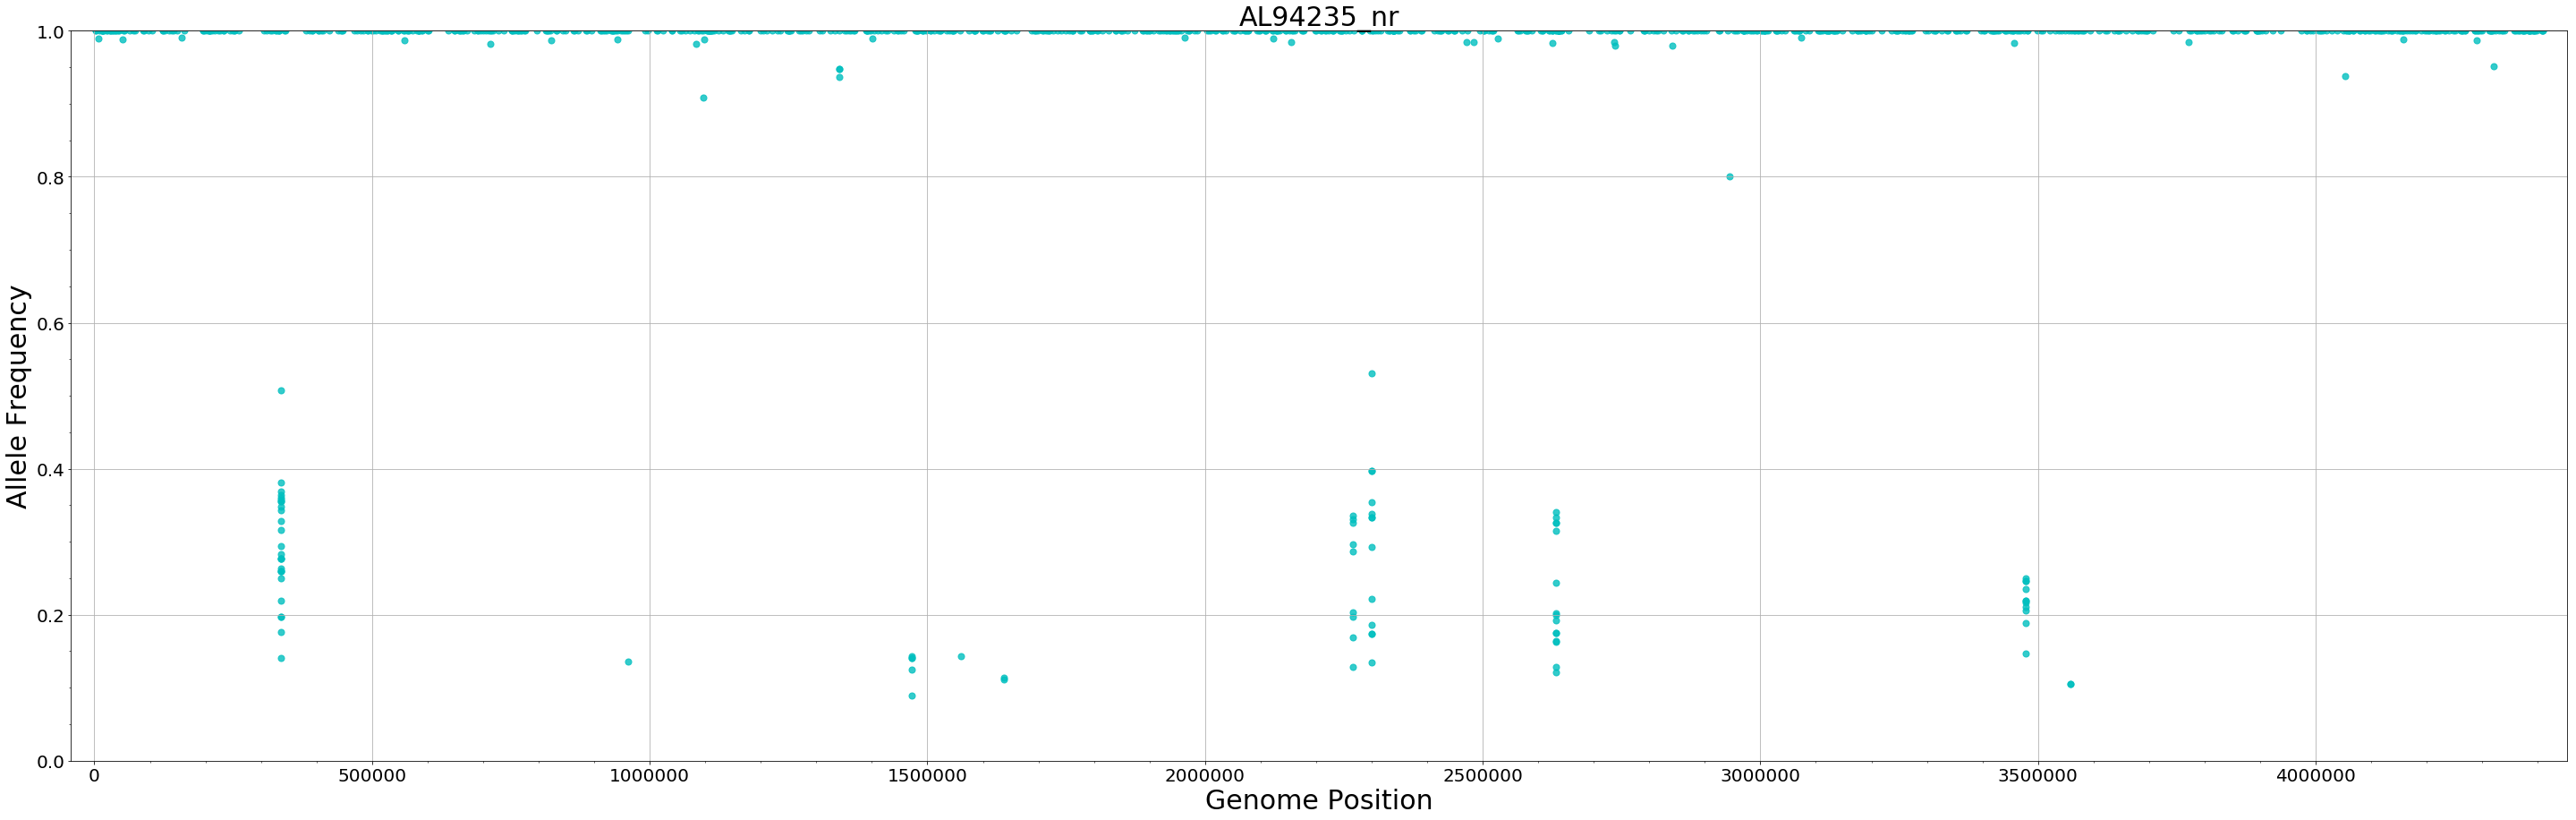

In [37]:
for name_nr, df_nr in dict_vcf_nr.items():
    scatter_vcf_pos_vcf_test(df_nr, name_nr)

# Add snp distance

In [48]:
def add_snp_distance(vcf_df):
    for index in vcf_df.index.values:
        if index == 0:
            vcf_df.loc[index,'snp_left_distance'] = vcf_df.loc[index,'POS'] - 0
        elif index > 0:
            vcf_df.loc[index,'snp_left_distance'] = vcf_df.loc[index,'POS'] - vcf_df.loc[index - 1,'POS']
        if index == (len(vcf_df.index.values) - 1):
            vcf_df.loc[index,'snp_right_distance'] = 4411532 - vcf_df.loc[index,'POS']
        elif index < (len(vcf_df.index.values) - 1):
            vcf_df.loc[index,'snp_right_distance'] = vcf_df.loc[index + 1,'POS'] - vcf_df.loc[index,'POS']
            
    return vcf_df

In [49]:
for name_nr, df_nr in dict_vcf_nr.items():
    #name = name_nr + "_ds"
    dict_vcf_nr[name_nr] = add_snp_distance(df_nr)

In [63]:
dict_vcf_nr["1008298_nr"][dict_vcf_nr["1008298_nr"].AF > 0.75]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,PGT,PID,PS,REF_AD,ALT_AD,aF,AF,Is_repeat,snp_right_distance,snp_left_distance
0,MTB_anc,1701,.,T,C,32647.95,PASS,AC=2;AF=1.00;AN=2;DP=201;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,201:201:99:5721,601,0",...,NaN,NaN,NaN,0.0,201.0,0.000000,1.000000,False,831.0,1701.0
1,MTB_anc,2532,.,C,T,10081.95,PASS,AC=2;AF=1.00;AN=2;DP=84;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,84:84:99:2421,251,0",...,NaN,NaN,NaN,0.0,84.0,0.000000,1.000000,False,5508.0,831.0
2,MTB_anc,8040,.,G,A,31778.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=-1.728e+00;DP=2...,GT:AD:DP:GQ:PL,"1/1:0,223:223:99:6572,666,0",...,NaN,NaN,NaN,0.0,223.0,0.000000,1.000000,False,1103.0,5508.0
3,MTB_anc,9143,.,C,T,36066.95,PASS,AC=2;AF=1.00;AN=2;DP=210;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,210:210:99:6353,628,0",...,NaN,NaN,NaN,0.0,210.0,0.000000,1.000000,False,4317.0,1103.0
4,MTB_anc,13460,.,G,A,30127.95,PASS,AC=2;AF=1.00;AN=2;DP=195;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,195:195:99:5704,580,0",...,NaN,NaN,NaN,0.0,195.0,0.000000,1.000000,False,791.0,4317.0
5,MTB_anc,14251,.,G,A,26426.95,PASS,AC=2;AF=1.00;AN=2;DP=205;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,205:205:99:5773,608,0",...,NaN,NaN,NaN,0.0,205.0,0.000000,1.000000,False,150.0,791.0
6,MTB_anc,14401,.,G,A,30943.95,PASS,AC=2;AF=1.00;AN=2;DP=206;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,206:206:99:6380,615,0",...,NaN,NaN,NaN,0.0,206.0,0.000000,1.000000,False,716.0,150.0
7,MTB_anc,15117,.,G,C,50652.95,PASS,AC=2;AF=1.00;AN=2;DP=219;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,219:219:99:7279,658,0",...,NaN,NaN,NaN,0.0,219.0,0.000000,1.000000,False,938.0,716.0
8,MTB_anc,16055,.,C,A,27519.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.72;DP=209;Exc...,GT:AD:DP:GQ:PL,"1/1:0,209:209:99:6677,625,0",...,NaN,NaN,NaN,0.0,209.0,0.000000,1.000000,False,1553.0,938.0
9,MTB_anc,17608,.,G,C,25435.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=2.60;DP=171;Exc...,GT:AD:DP:GQ:PL,"1/1:2,169:171:99:5108,488,0",...,NaN,NaN,NaN,2.0,169.0,0.011696,0.988304,False,4211.0,1553.0


In [74]:
dict_vcf_nr["1008298_nr"][((dict_vcf_nr["1008298_nr"].AF < 0.75) & 
                                  ((dict_vcf_nr["1008298_nr"].snp_left_distance <= 10)|
                                   (dict_vcf_nr["1008298_nr"].snp_right_distance <= 10)))]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,PGT,PID,PS,REF_AD,ALT_AD,aF,AF,Is_repeat,snp_right_distance,snp_left_distance
70,MTB_anc,336325,.,T,G,2452.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=3.86;DP=193;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:177,16:193:99:0|1:336322_CAA_C:109,0,7804:...",...,0|1,336322_CAA_C,336322,177.0,16.0,0.917098,0.082902,False,7.0,3033.0
71,MTB_anc,336332,.,G,C,3417.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=1.19;DP=185;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:166,19:185:99:0|1:336322_CAA_C:311,0,7037:...",...,0|1,336322_CAA_C,336322,166.0,19.0,0.897297,0.102703,False,12.0,7.0
72,MTB_anc,336344,.,A,G,4021.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=3.88;DP=189;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:168,21:189:99:0|1:336344_A_G:373,0,6979:33...",...,0|1,336344_A_G,336344,168.0,21.0,0.888889,0.111111,False,1.0,12.0
73,MTB_anc,336345,.,T,C,4024.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=4.67;DP=187;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:166,21:187:99:0|1:336344_A_G:373,0,6979:33...",...,0|1,336344_A_G,336344,166.0,21.0,0.887701,0.112299,False,8.0,1.0
74,MTB_anc,336353,.,C,T,4709.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.000e+00;DP=...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:159,25:184:99:0|1:336344_A_G:718,0,6883:33...",...,0|1,336344_A_G,336344,159.0,25.0,0.864130,0.135870,False,16.0,8.0
75,MTB_anc,336369,.,C,T,8874.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.477e+00;DP=...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:166,26:192:99:0|1:336344_A_G:1193,0,6829:3...",...,0|1,336344_A_G,336344,166.0,26.0,0.864583,0.135417,False,1.0,16.0
76,MTB_anc,336370,.,A,G,8943.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=4.58;DP=191;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:165,26:191:99:0|1:336344_A_G:1193,0,6829:3...",...,0|1,336344_A_G,336344,165.0,26.0,0.863874,0.136126,False,10.0,1.0
77,MTB_anc,336380,.,A,T,8700.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=1.66;DP=219;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:173,46:219:99:0|1:336344_A_G:1173,0,6948:3...",...,0|1,336344_A_G,336344,173.0,46.0,0.789954,0.210046,False,20.0,10.0
78,MTB_anc,336400,.,C,G,10526.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.553;DP=195;E...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:152,43:195:99:0|1:336400_C_G:1329,0,6154:3...",...,0|1,336400_C_G,336400,152.0,43.0,0.779487,0.220513,False,3.0,20.0
79,MTB_anc,336403,.,C,G,10419.89,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.320e+00;DP=...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:148,40:188:99:0|1:336400_C_G:1275,0,6283:3...",...,0|1,336400_C_G,336400,148.0,40.0,0.787234,0.212766,False,2.0,3.0


In [51]:
dict_vcf_nr["1008298_nr"].tail()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,PGT,PID,PS,REF_AD,ALT_AD,aF,AF,Is_repeat,snp_right_distance,snp_left_distance
953,MTB_anc,4397324,.,G,C,29828.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.71;DP=172;Exc...,GT:AD:DP:GQ:PL,"1/1:0,172:172:99:5435,514,0",...,NaN,NaN,NaN,0.0,172.0,0.0,1.0,False,10264.0,1937.0
954,MTB_anc,4407588,.,C,T,39262.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=-1.202e+00;DP=2...,GT:AD:DP:GQ:PL,"1/1:0,228:228:99:6745,680,0",...,NaN,NaN,NaN,0.0,228.0,0.0,1.0,False,568.0,10264.0
955,MTB_anc,4408156,.,A,C,43246.95,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.78;DP=212;Exc...,GT:AD:DP:GQ:PL,"1/1:0,212:212:99:6610,635,0",...,NaN,NaN,NaN,0.0,212.0,0.0,1.0,False,764.0,568.0
956,MTB_anc,4408920,.,G,A,32056.95,PASS,AC=2;AF=1.00;AN=2;DP=124;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,124:124:99:1|1:4408920_G_A:5528,376,0:44...",...,1|1,4408920_G_A,4408920,0.0,124.0,0.0,1.0,False,3.0,764.0
957,MTB_anc,4408923,.,T,C,32400.95,PASS,AC=2;AF=1.00;AN=2;DP=126;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,126:126:99:1|1:4408920_G_A:5662,388,0:44...",...,1|1,4408920_G_A,4408920,0.0,126.0,0.0,1.0,False,2609.0,3.0


# Apply distance filtering

In [52]:
def filter_by_distance(vcf_dist_df, distance):
    vcf_df_filtered_distance = vcf_dist_df[((vcf_dist_df['snp_right_distance'] > distance) | (vcf_dist_df['snp_left_distance'] > distance))]
    return vcf_df_filtered_distance

In [55]:
dict_vcf_dsf = {}
for name_nr, df_nr in dict_vcf_nr.items():
    name_dsf = name_nr + "_dsf"
    dict_vcf_dsf[name_dsf] = filter_by_distance(df_nr, 10)

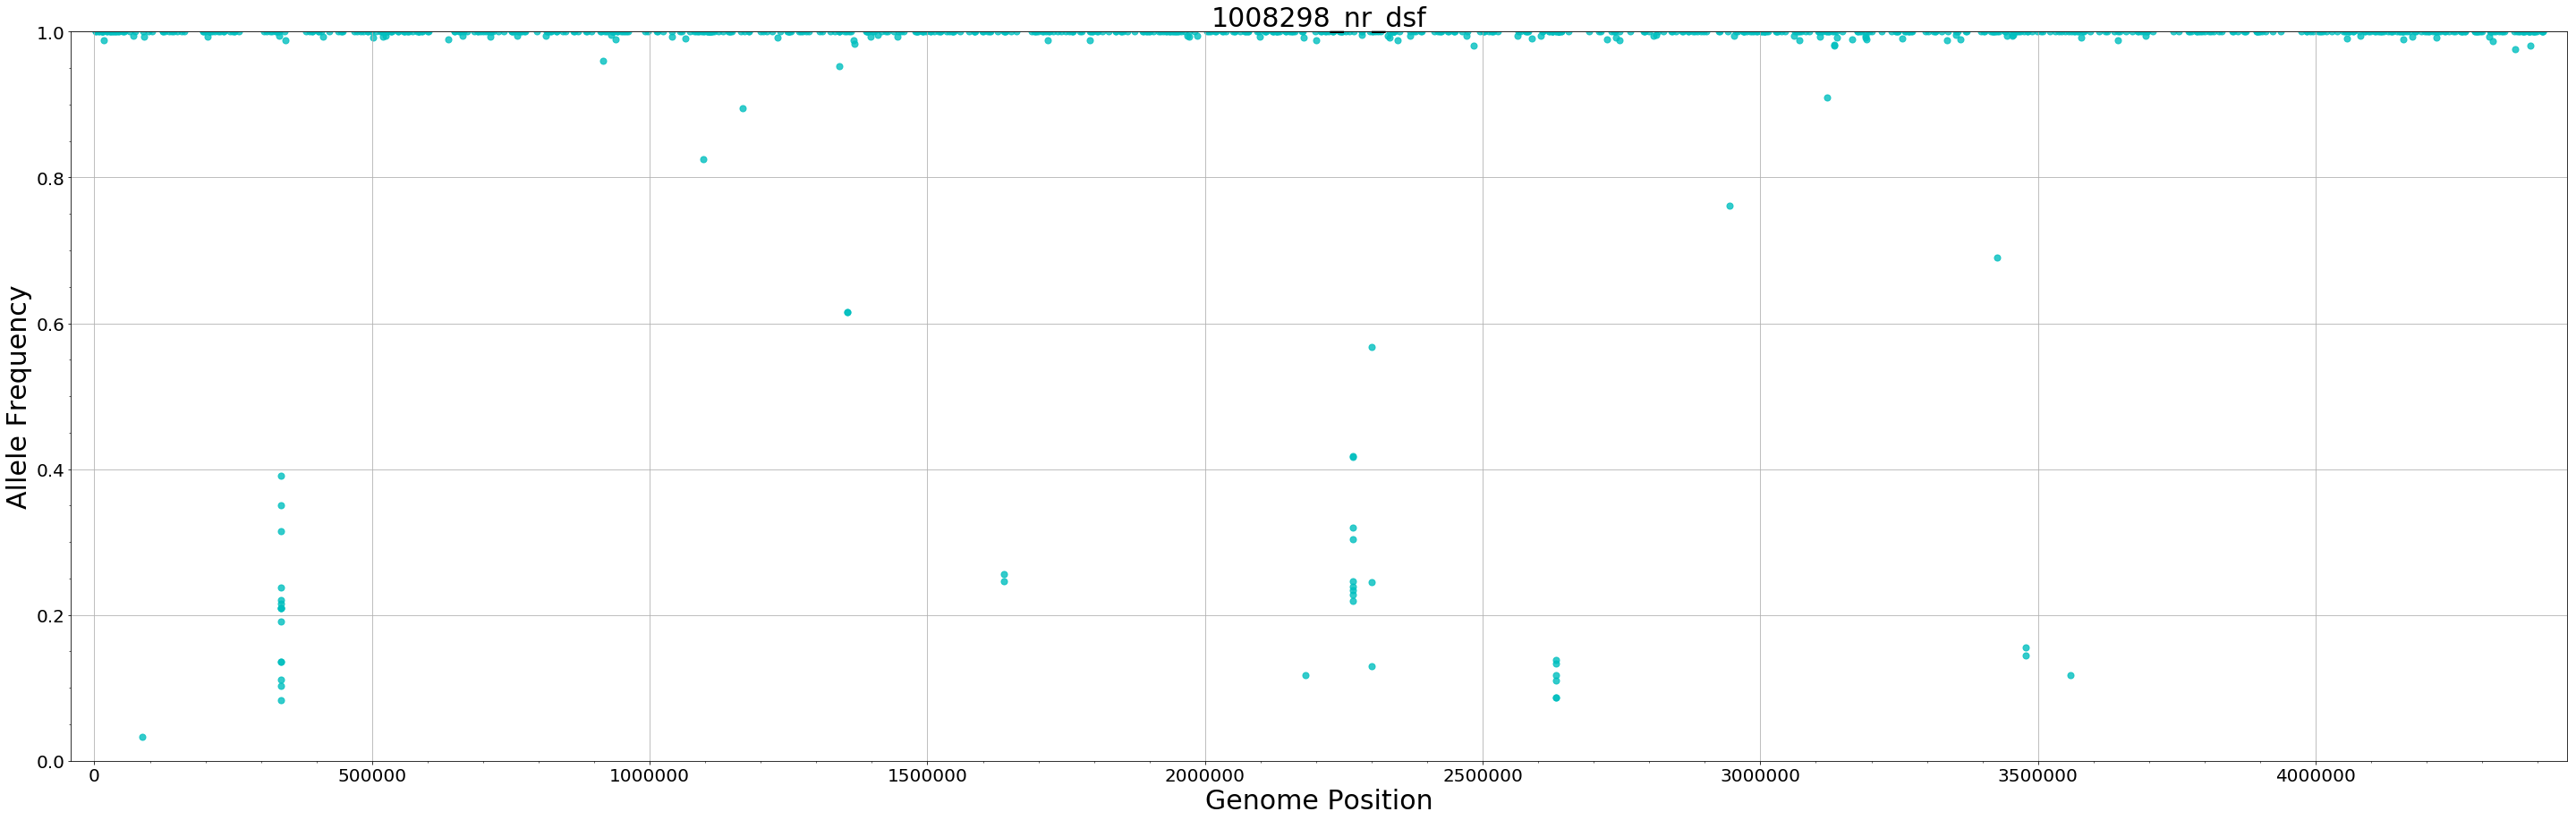

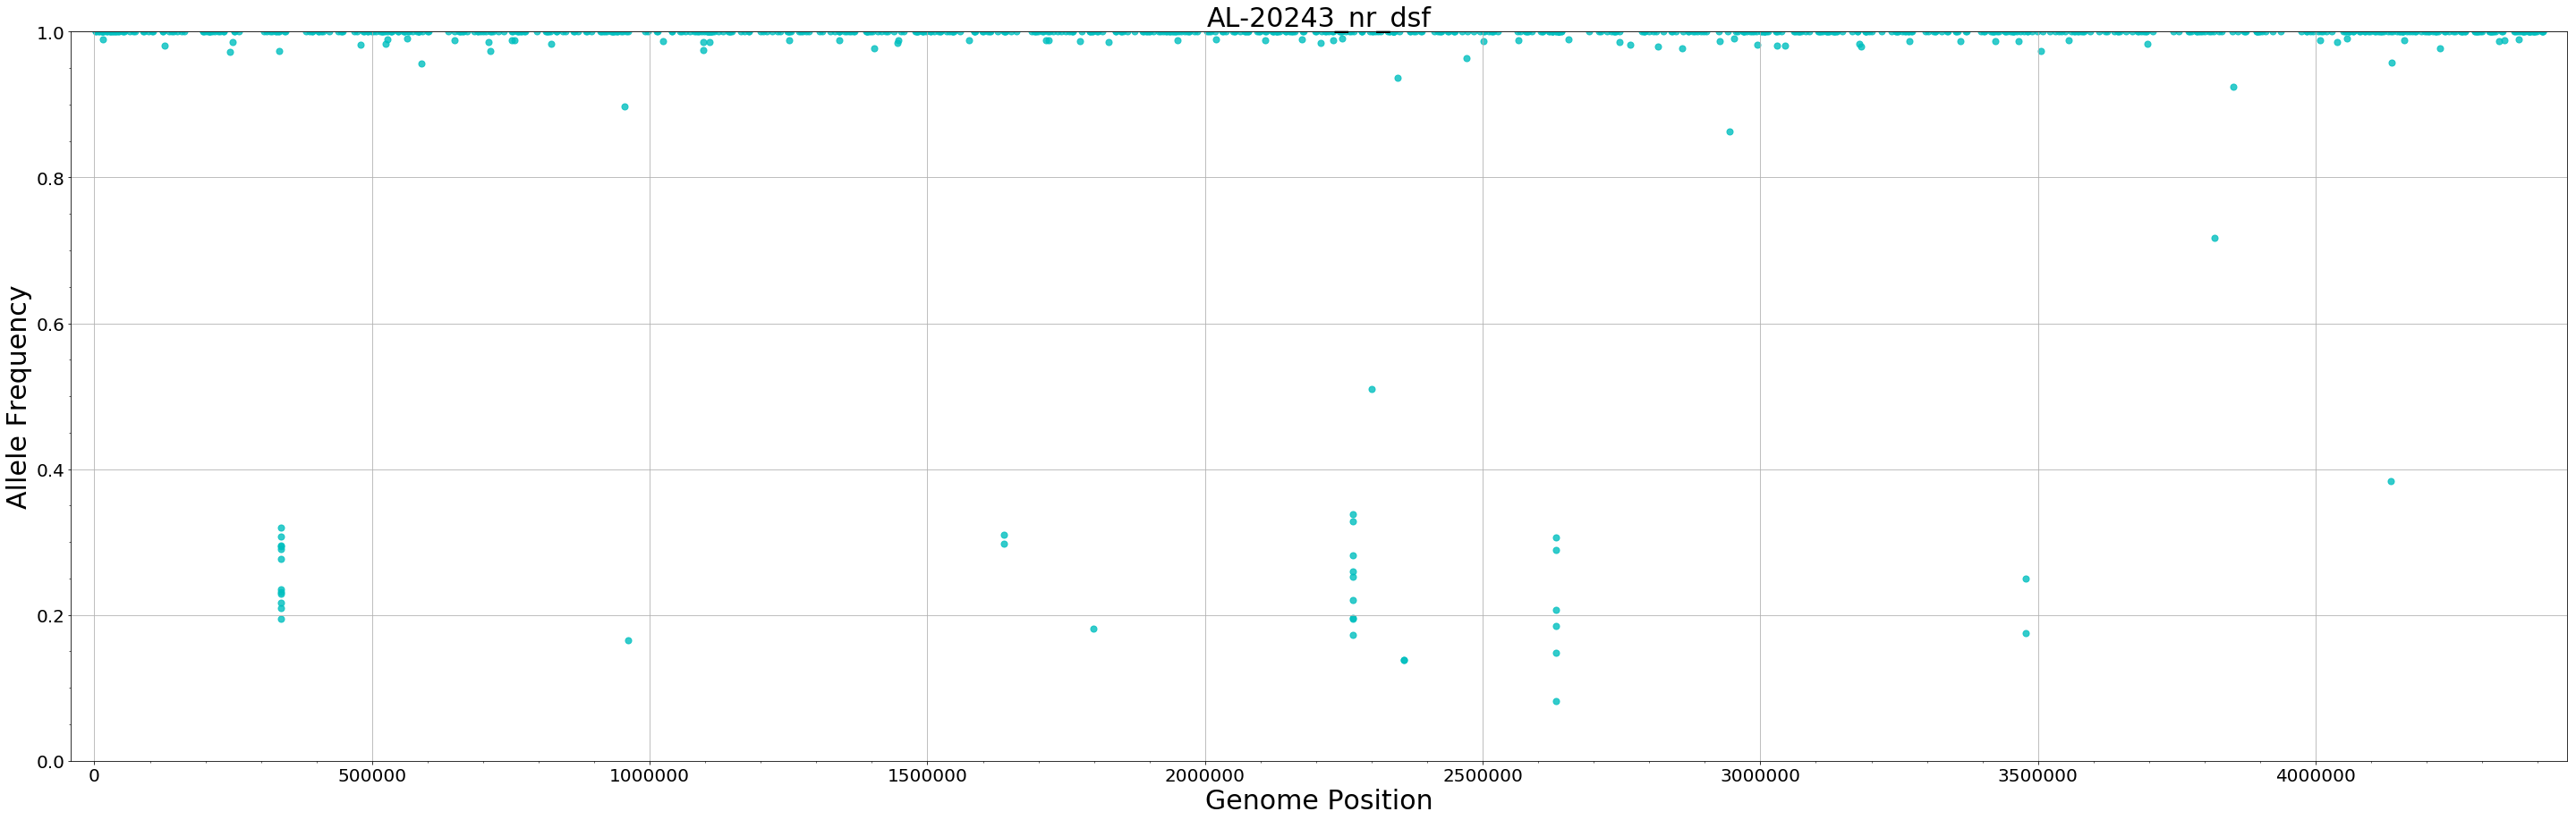

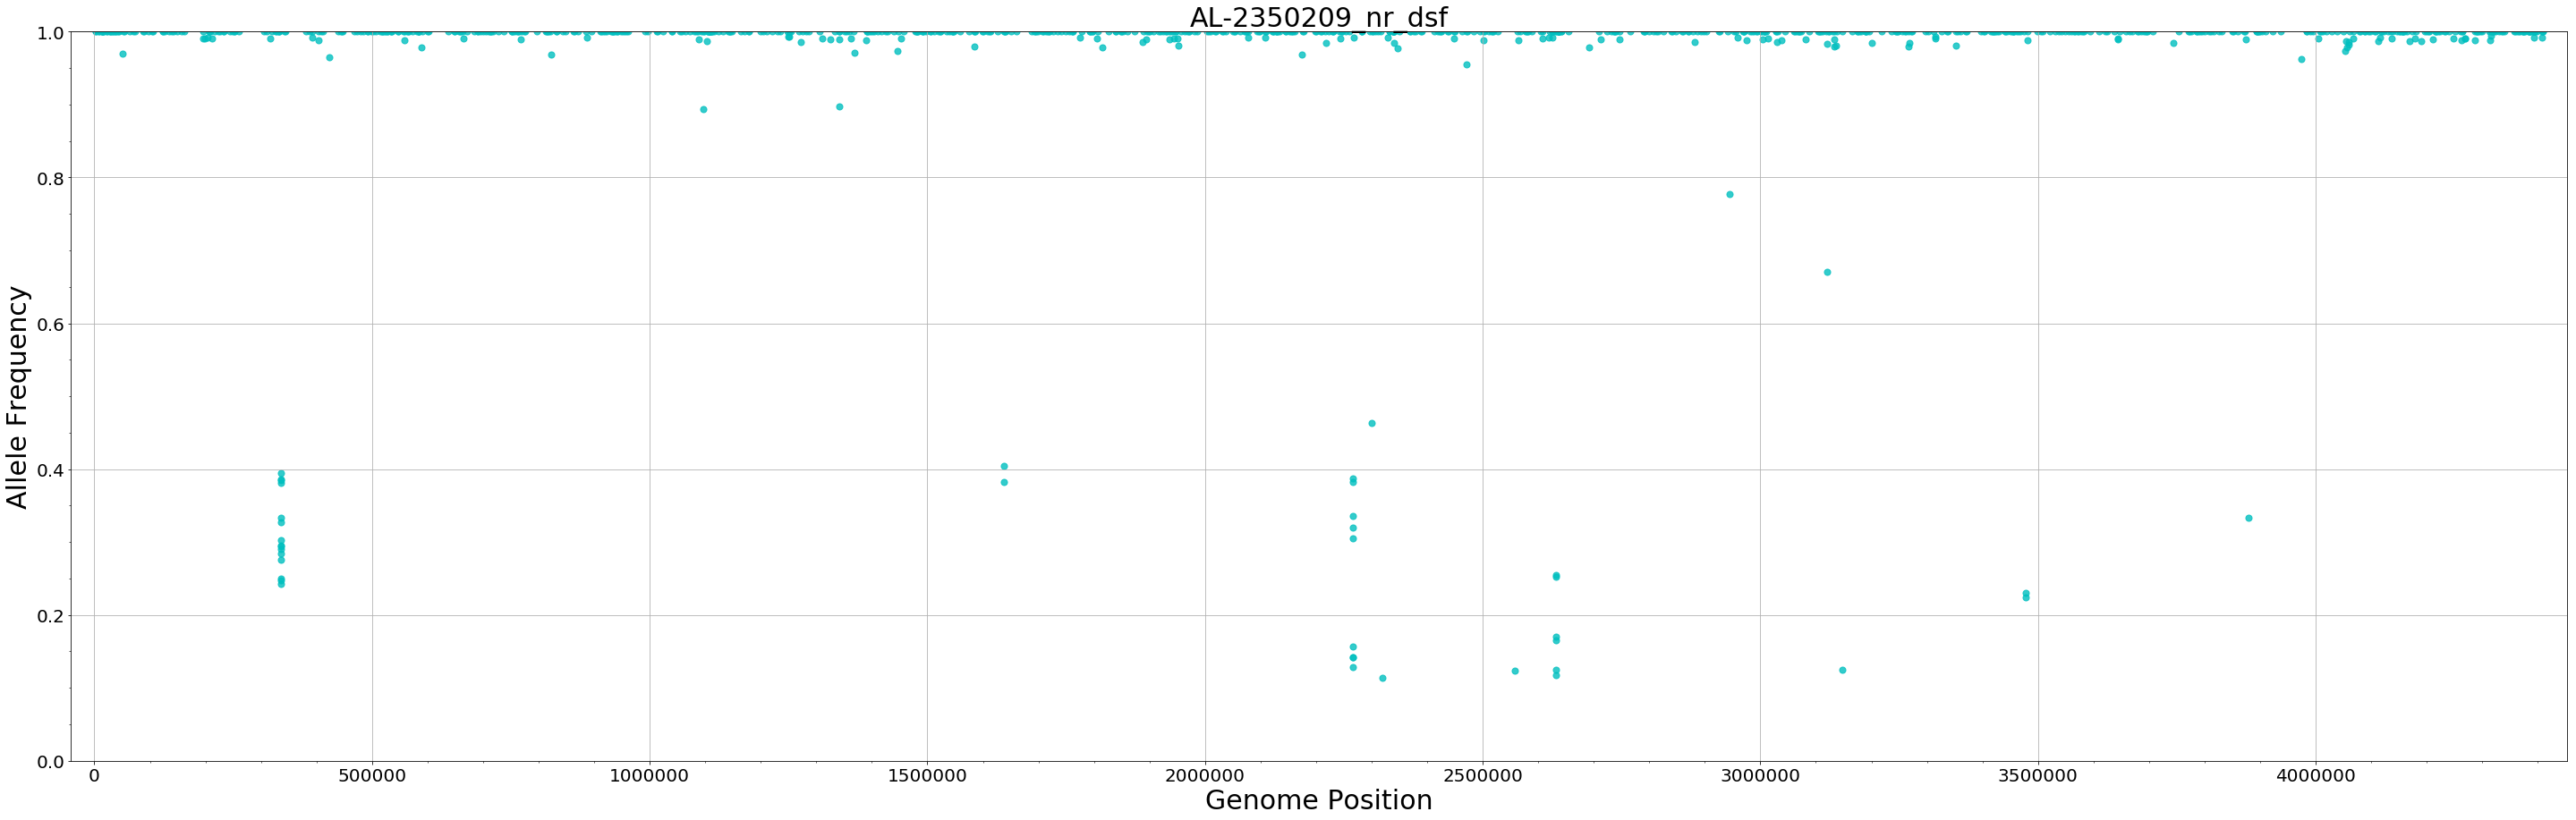

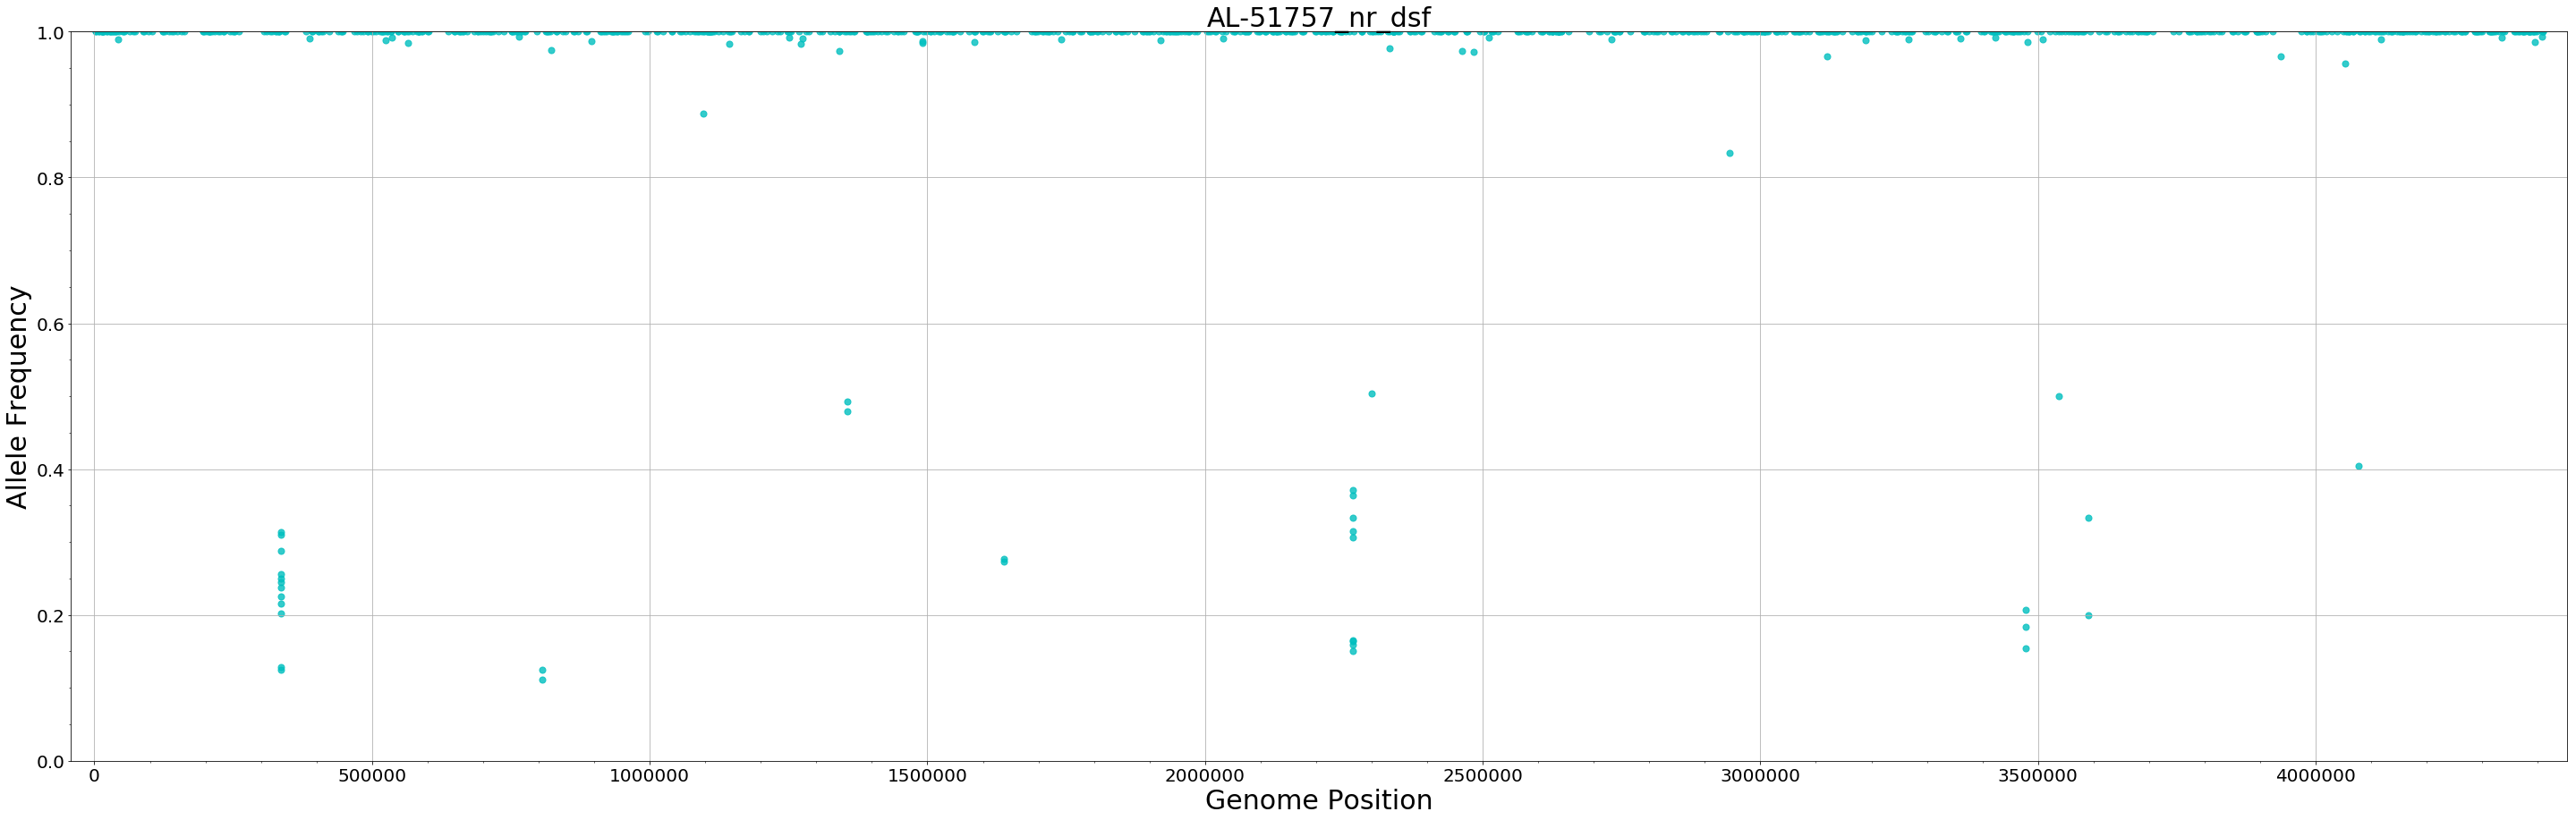

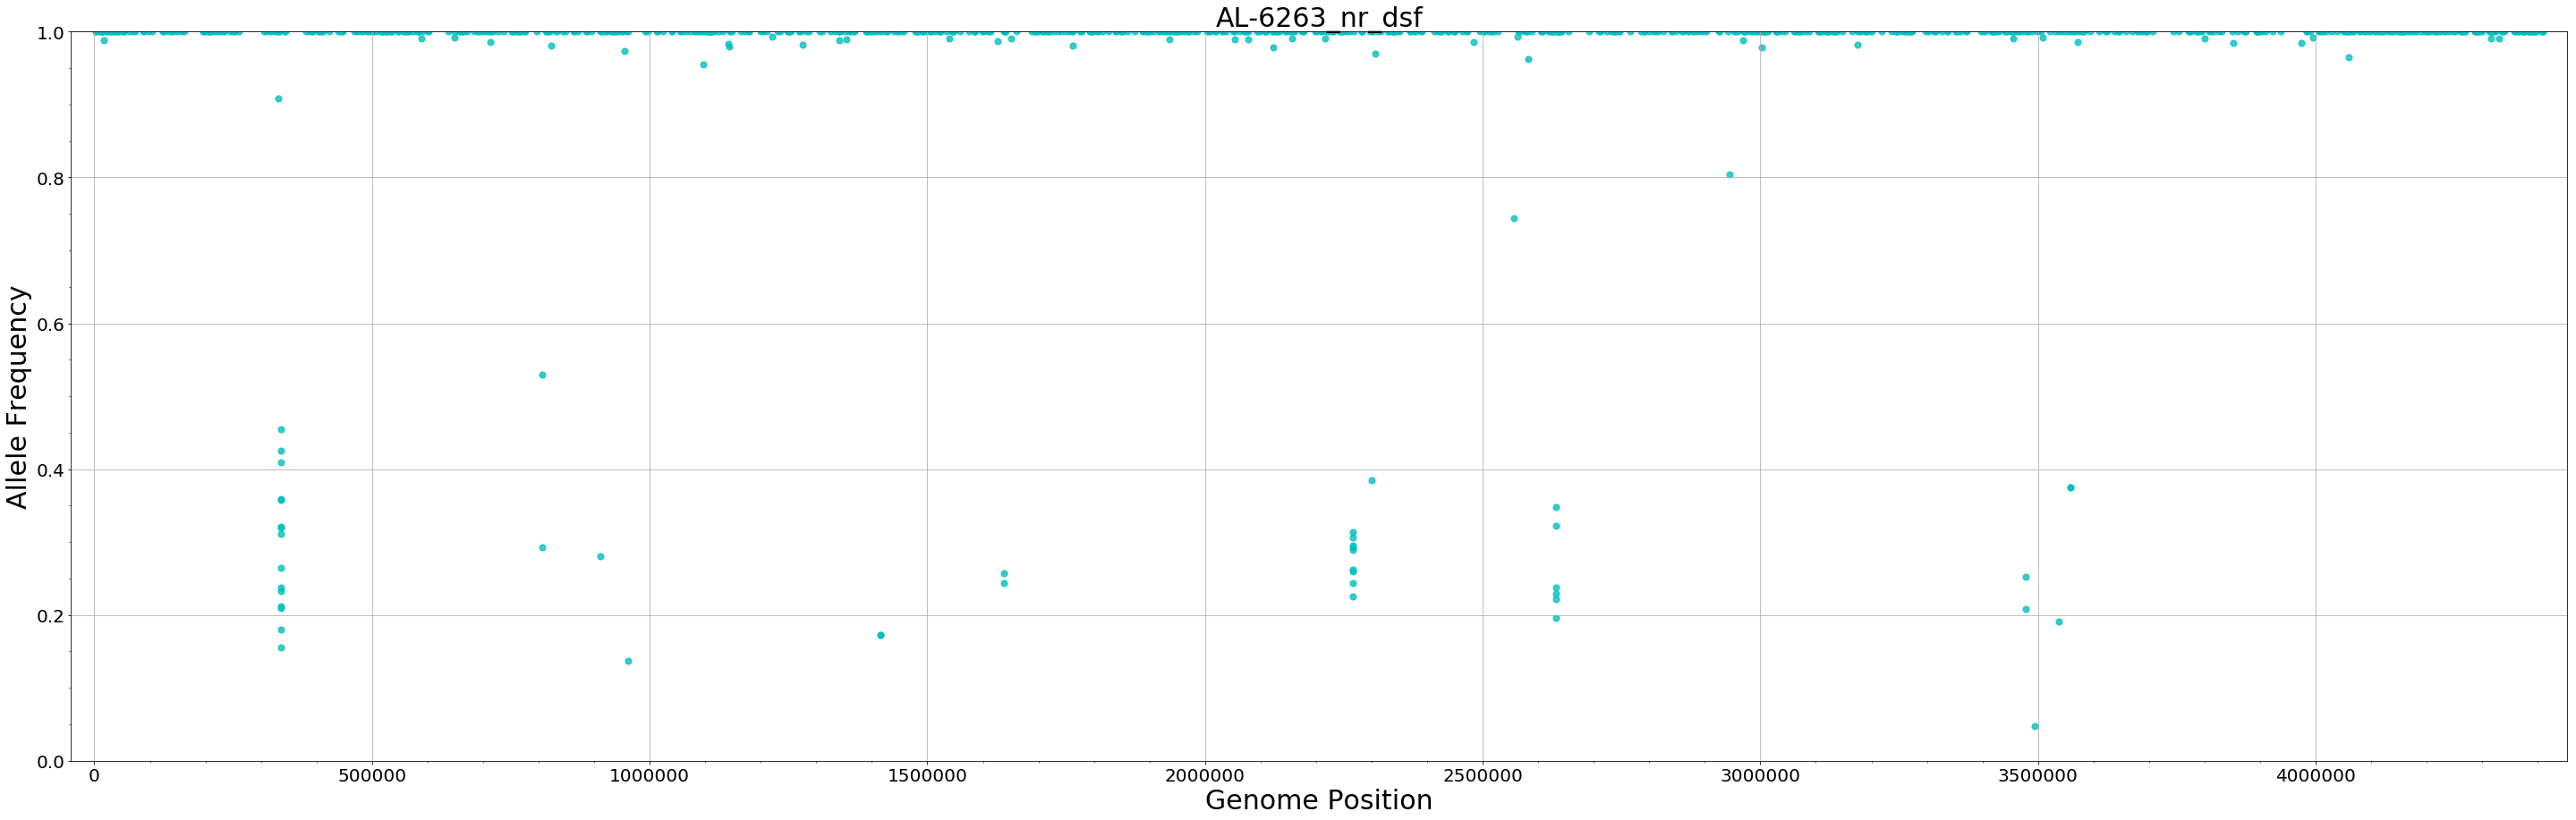

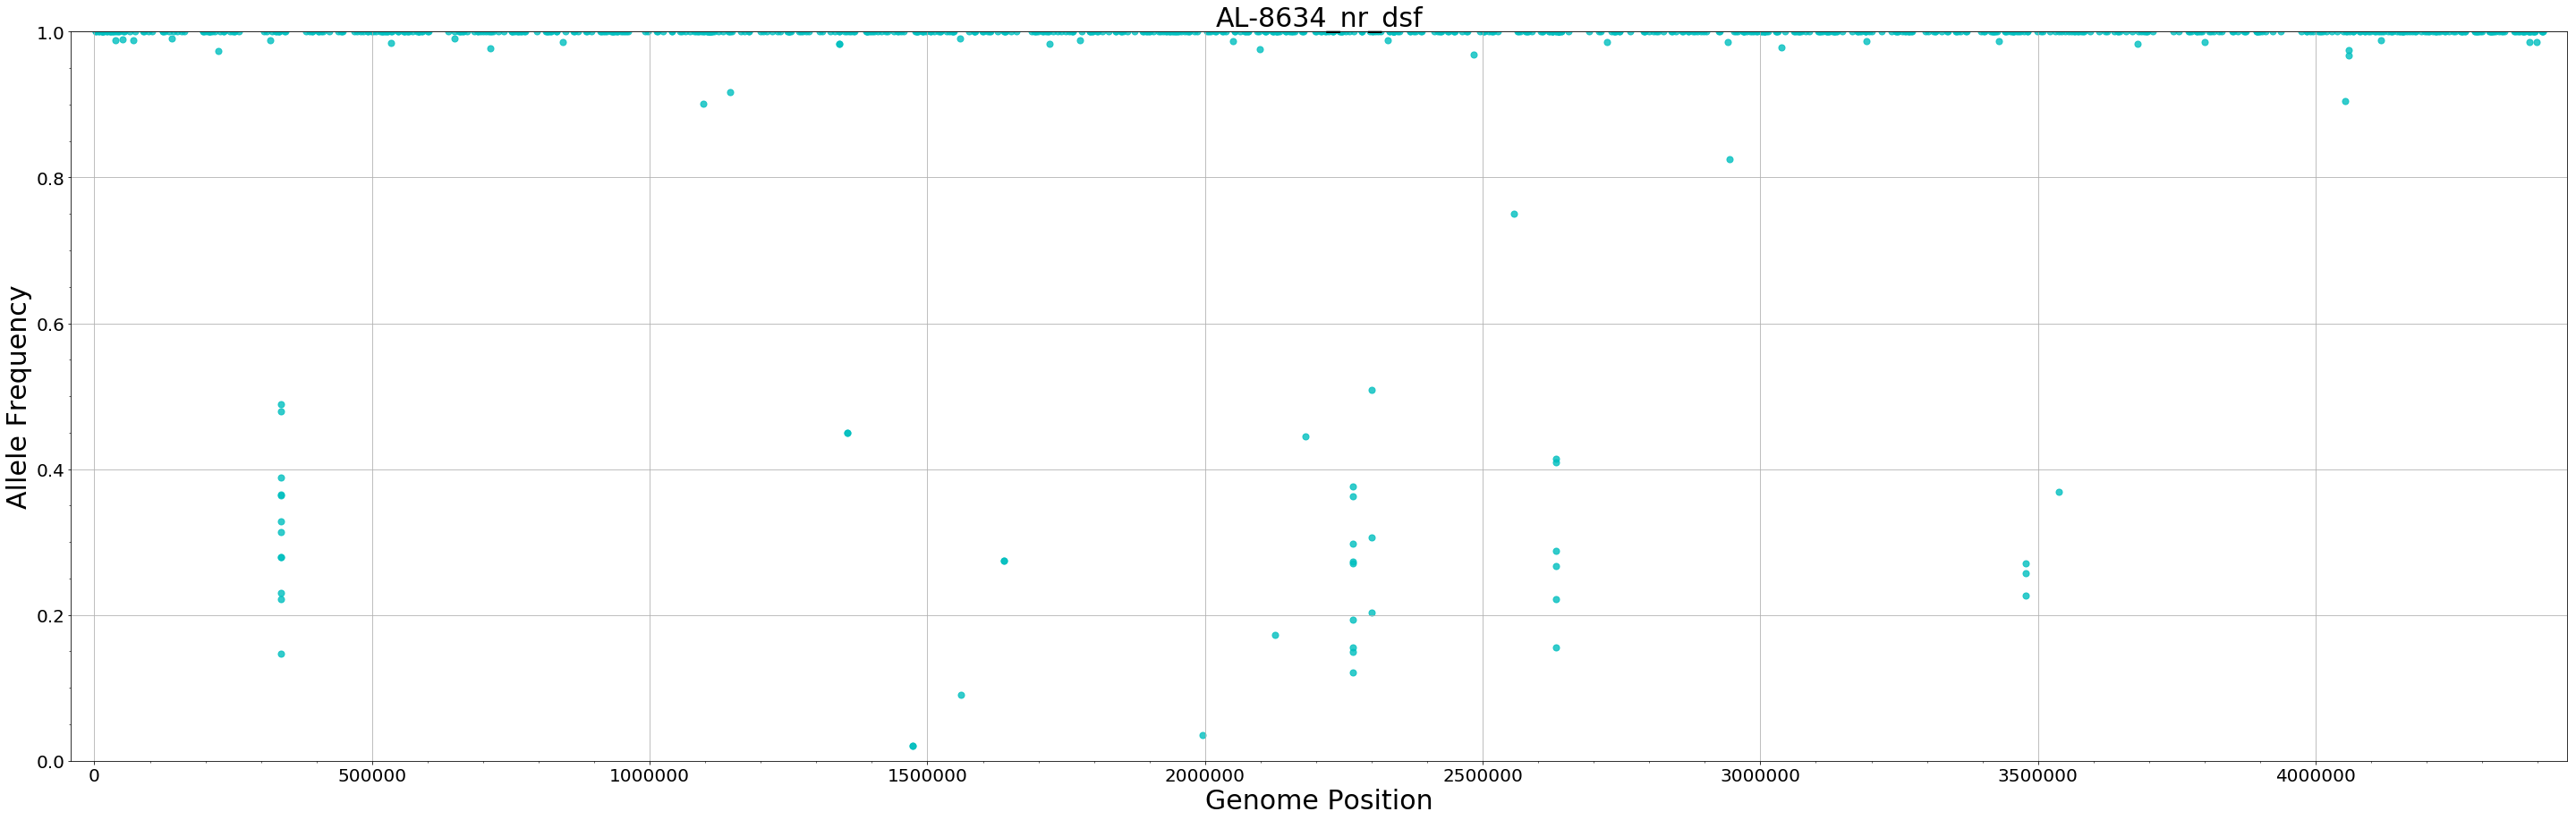

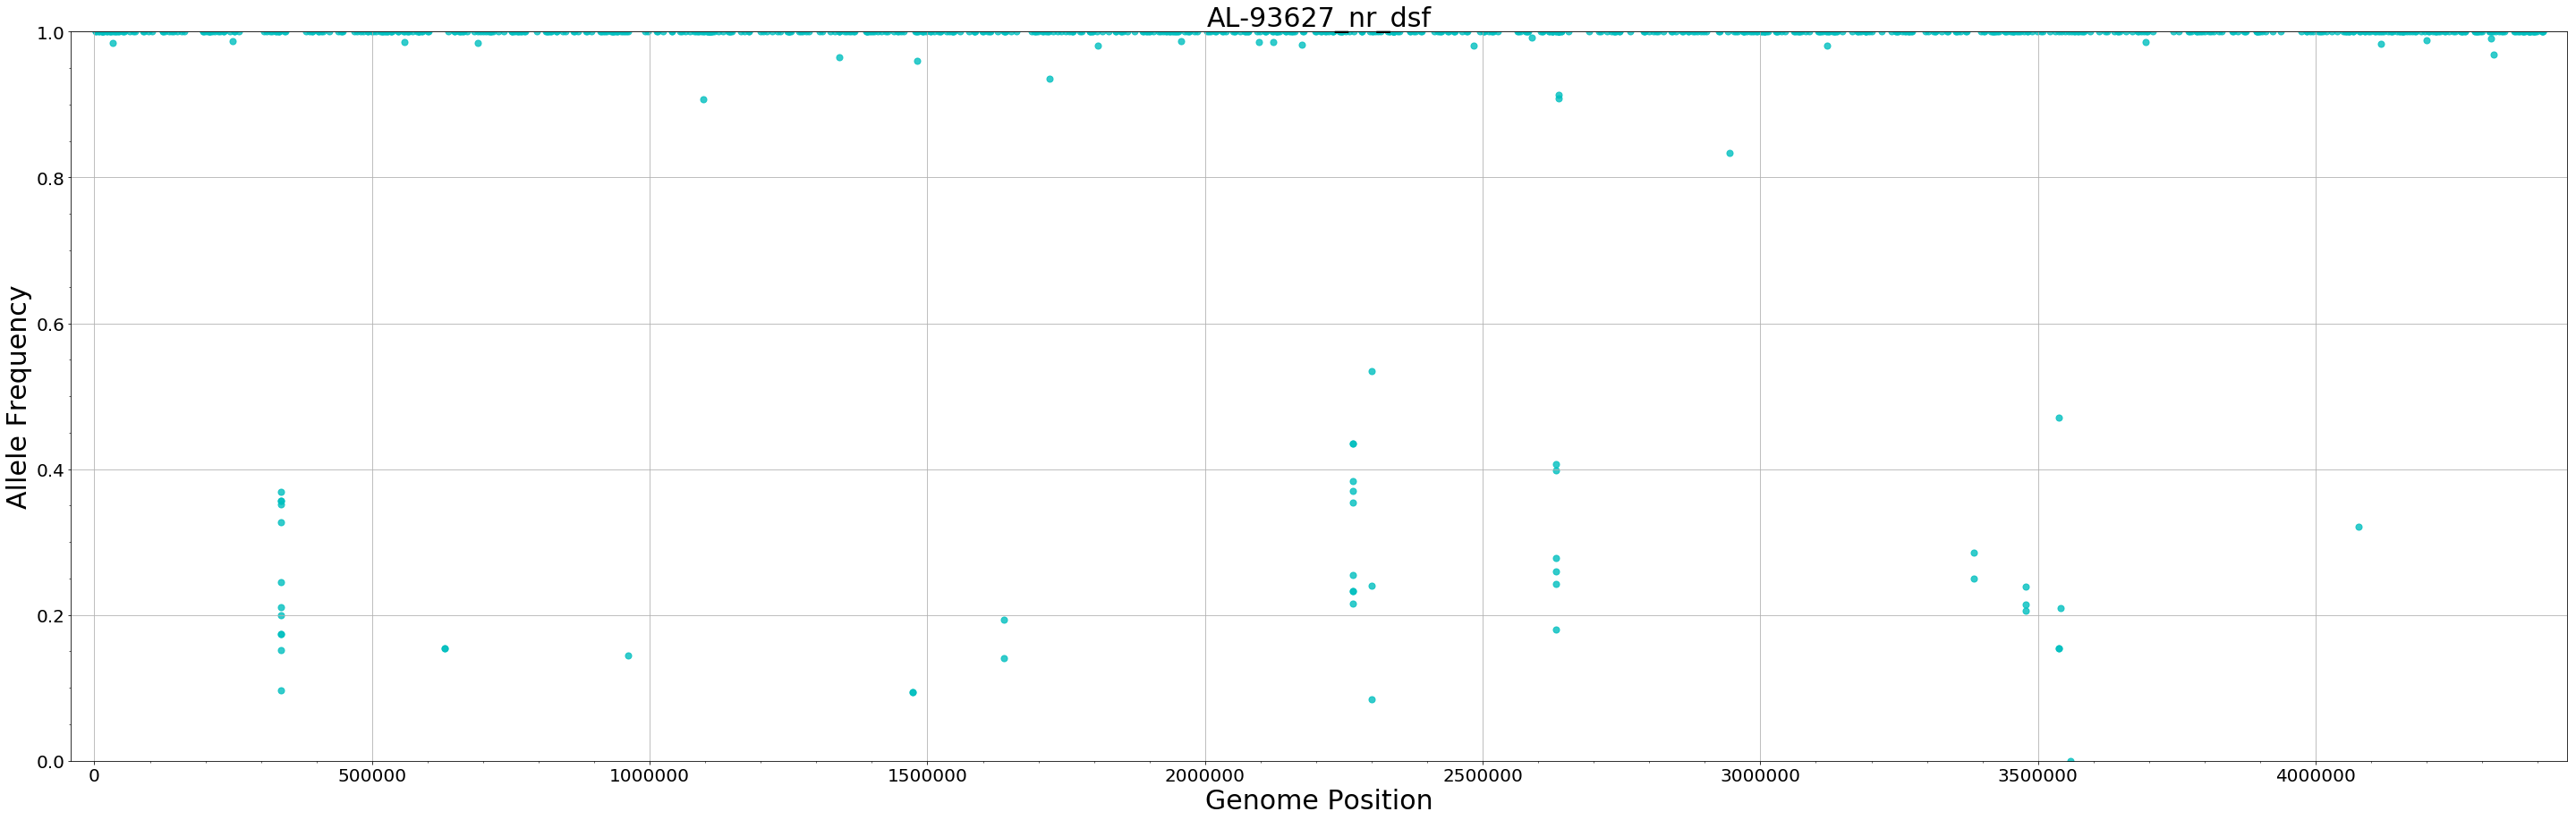

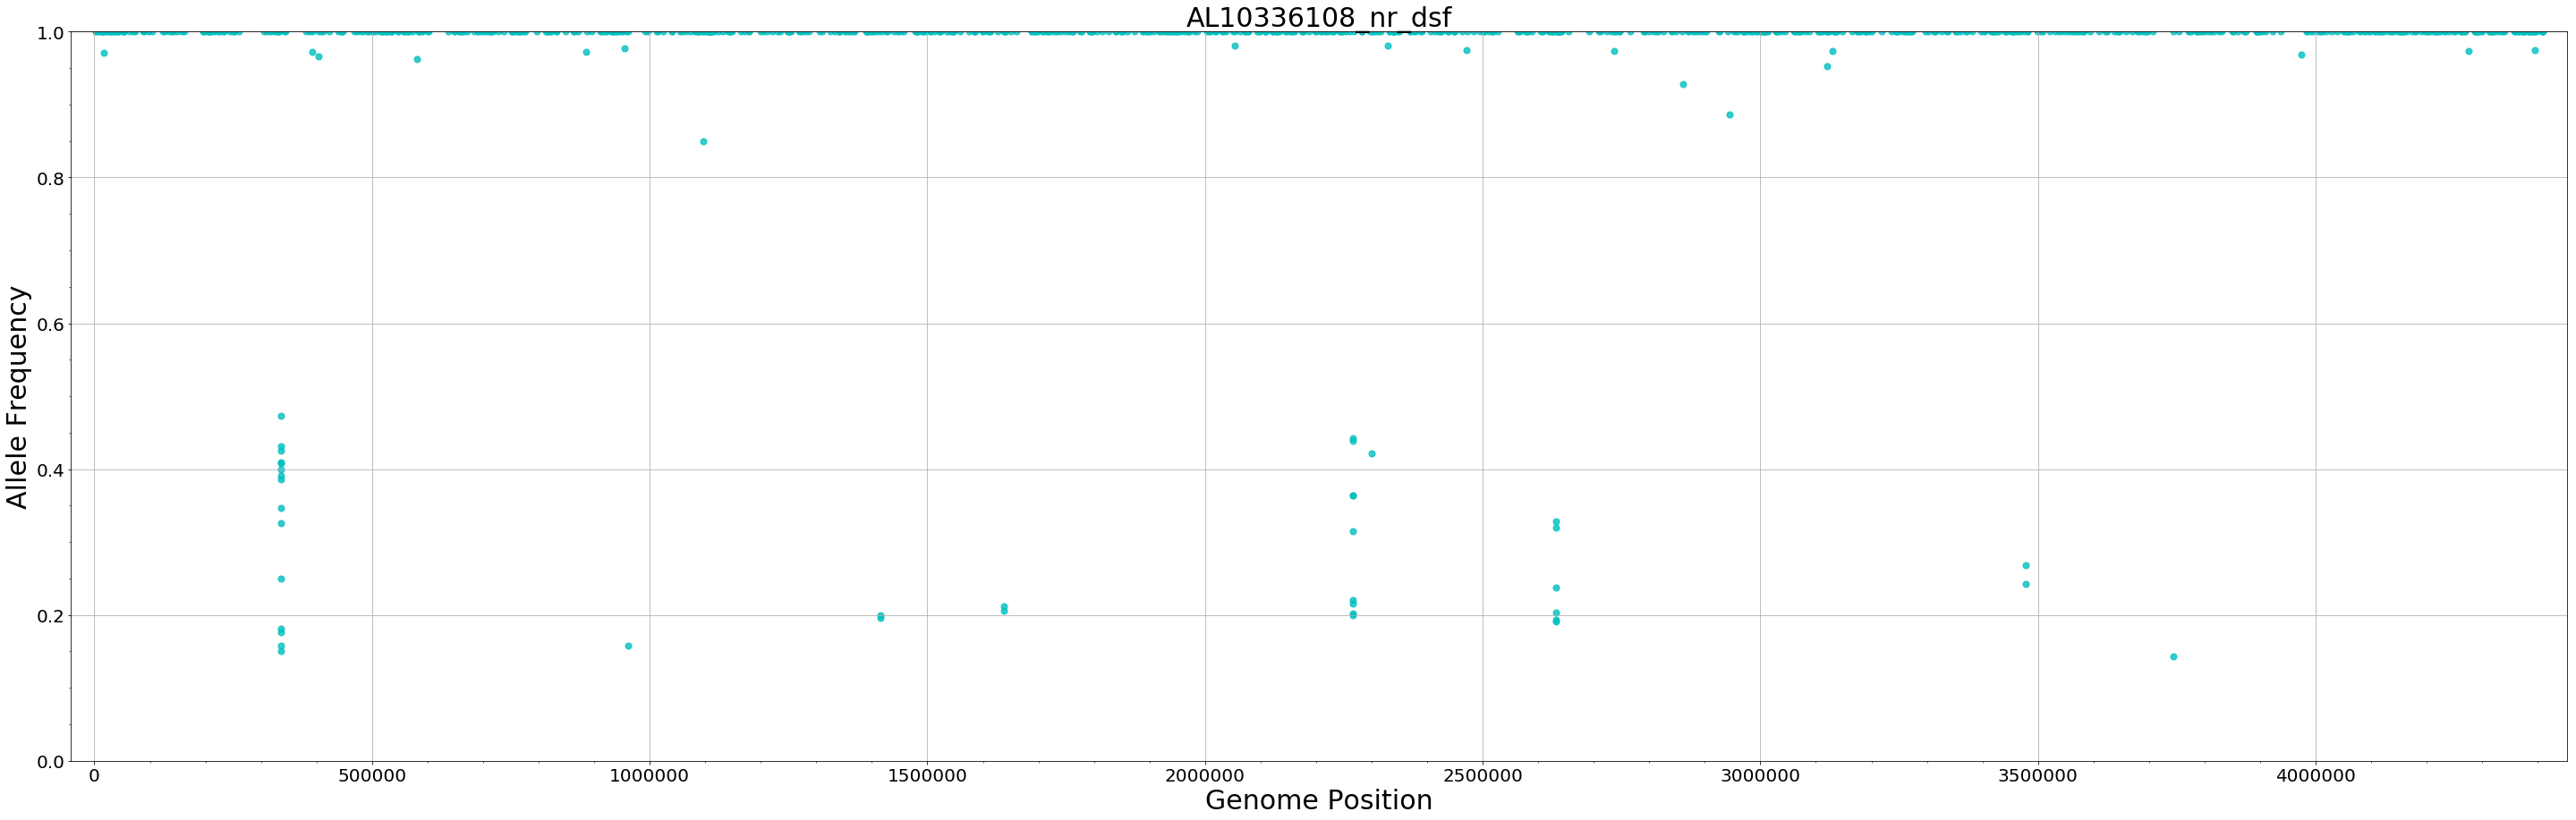

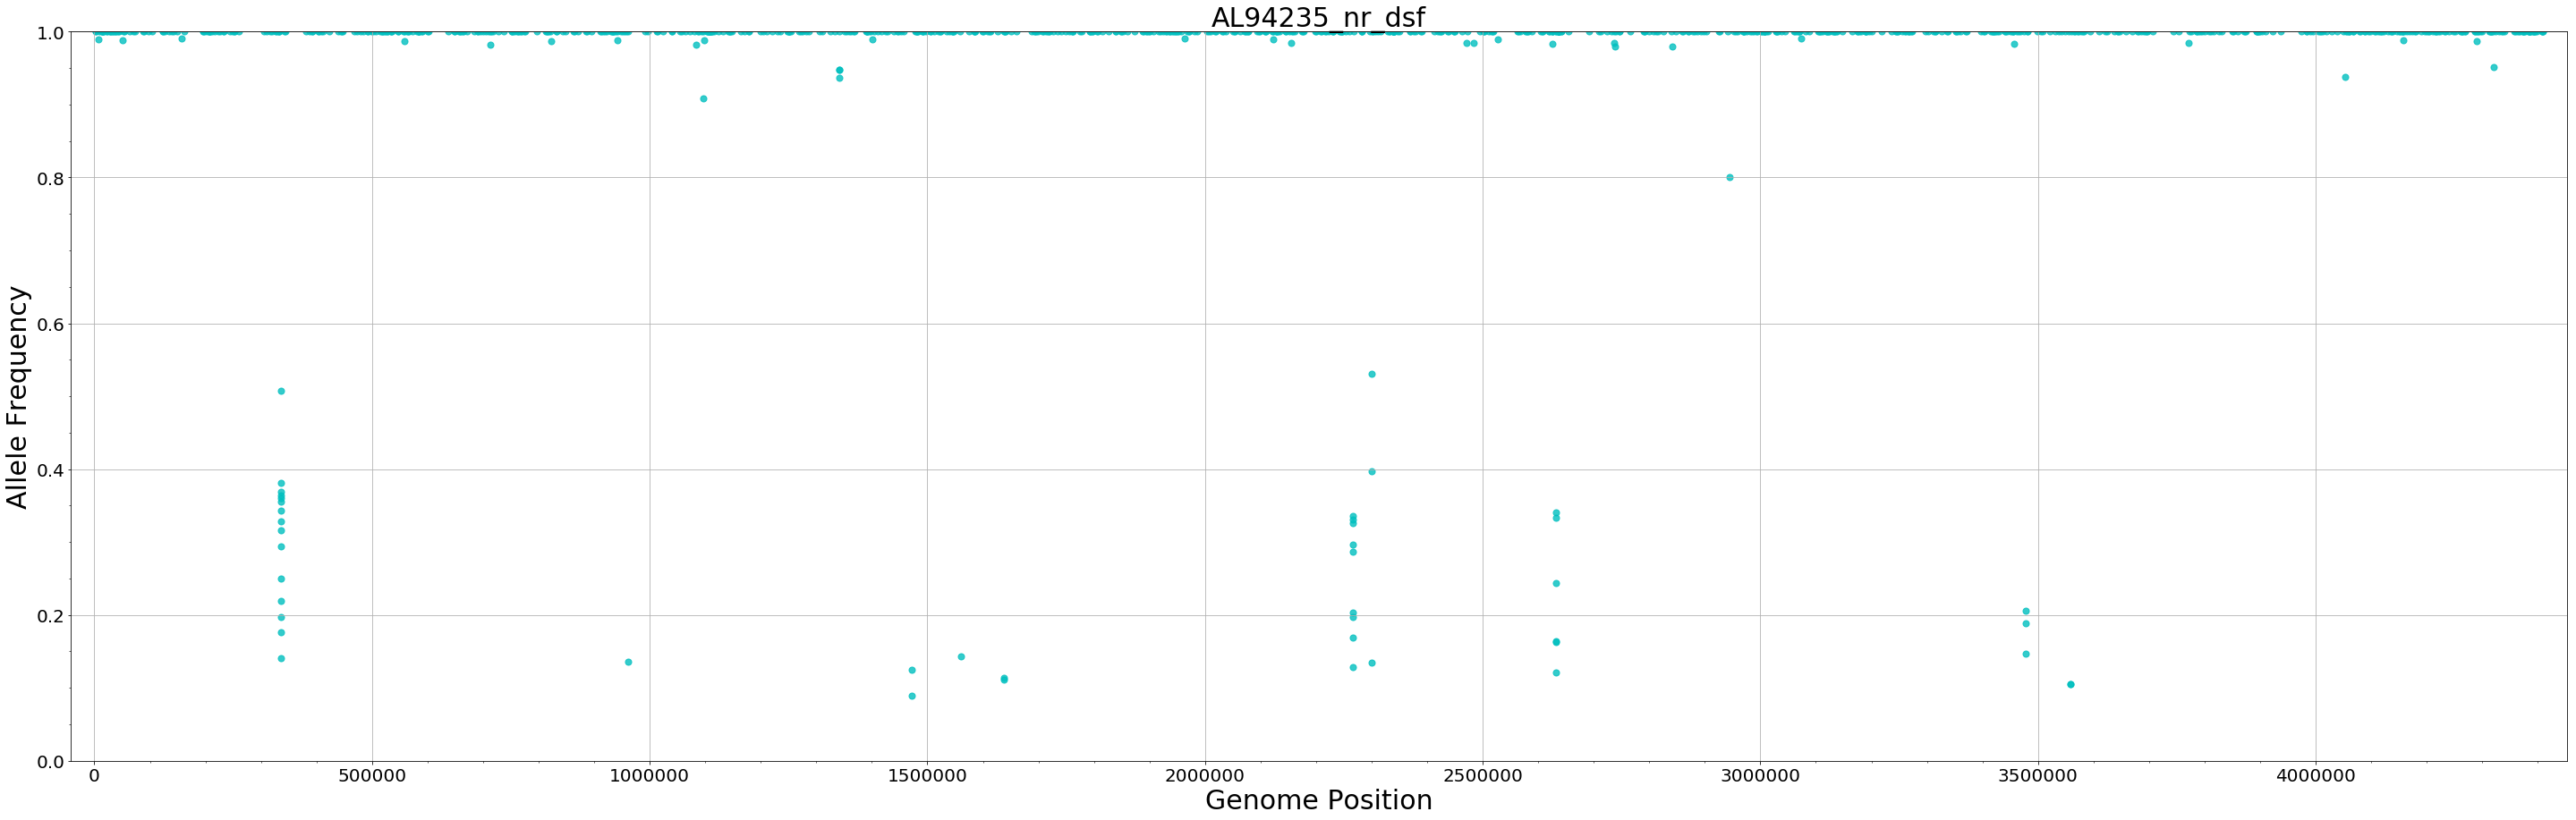

In [56]:
for name_nr_dsf, df_nr_dsf in dict_vcf_dsf.items():
    scatter_vcf_pos_vcf_test(df_nr_dsf, name_nr_dsf)

In [18]:
for name_nr, df_nr in dict_vcf_nr.items():
    print(df_nr.shape)

(1124, 36)
(1110, 36)
(1114, 36)
(1086, 36)
(1110, 36)
(1114, 36)
(1110, 36)
(1097, 36)
(1104, 36)


In [19]:
for name_nr_dsf, df_nr_dsf in dict_vcf_dsf.items():
    print(df_nr_dsf.shape)

(965, 36)
(960, 36)
(963, 36)
(955, 36)
(964, 36)
(964, 36)
(962, 36)
(950, 36)
(945, 36)


In [27]:
for df_name, df in dict_vcf.items():
    df['Is_repeat'] = df.apply(filter_repeats, axis=1)

In [28]:
dict_vcf_nr = {}
for vcf_name, df in dict_vcf.items():
    name = vcf_name + "_nr"
    dict_vcf_nr[name] = df[df['Is_repeat'] == False].reset_index(drop=True)

In [29]:
for name_nr, df_nr in dict_vcf_nr.items():
    print(df_nr.shape)

(958, 34)
(945, 34)
(945, 34)
(930, 34)
(955, 34)
(957, 34)
(962, 34)
(945, 34)
(960, 34)


In [79]:
df_vcf = import_VCF42_to_pandas("test/1008298.snp.hf.pass.vcf")



#Add repeat info (Phage, Transposon or PE/PPE regions)
df_vcf['Is_repeat'] = df_vcf.apply(filter_repeats, axis=1)

#Add info of nearby positions
add_snp_distance(df_vcf)

#output all raw info into a file
#new_out_file = tab_name + extend_raw
#output_raw_tab = os.path.join(table_outputt_dir, new_out_file)
#df_vcf.to_csv(output_raw_tab, sep='\t', index=False)
    
list_positions_to_filter = df_vcf['POS'][((df_vcf.AF < 0.75) &
                                 ((df_vcf.snp_left_distance <= 10) |
                                 (df_vcf.snp_right_distance <= 10)))].tolist()
print(list_positions_to_filter)
#final_vcf_name = tab_name + extend_final
#filter_vcf_list(vcf_path, list_positions_to_filter, final_vcf_name)

[338844, 338845, 338984, 338990, 338997, 338998, 1355896, 1355898, 1636944, 1636945, 1636946]


In [82]:
df_vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,BaseQRankSum,MQRankSum,ReadPosRankSum,REF_AD,ALT_AD,aF,AF,Is_repeat,snp_left_distance,snp_right_distance
0,MTB_anc,1701,.,T,C,32401.89,PASS,AC=1;AF=1.00;AN=1;DP=201;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,201:201:99:5692,0",...,NaN,NaN,NaN,0.0,201.0,0.0,1.0,False,1701.0,831.0
1,MTB_anc,2532,.,C,T,10020.89,PASS,AC=1;AF=1.00;AN=1;DP=84;FS=0.000;MQ=60.00;QD=3...,GT:AD:DP:GQ:PL,"1:0,84:84:99:2415,0",...,NaN,NaN,NaN,0.0,84.0,0.0,1.0,False,831.0,5508.0
2,MTB_anc,8040,.,G,A,31657.89,PASS,AC=1;AF=1.00;AN=1;BaseQRankSum=-1.731e+00;DP=2...,GT:AD:DP:GQ:PL,"1:0,223:223:99:6559,0",...,-1.731,0.0,-0.516,0.0,223.0,0.0,1.0,False,5508.0,1103.0
3,MTB_anc,9143,.,C,T,35793.89,PASS,AC=1;AF=1.00;AN=1;DP=210;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,210:210:99:6307,0",...,NaN,NaN,NaN,0.0,210.0,0.0,1.0,False,1103.0,4317.0
4,MTB_anc,13460,.,G,A,30003.89,PASS,AC=1;AF=1.00;AN=1;DP=195;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,195:195:99:5701,0",...,NaN,NaN,NaN,0.0,195.0,0.0,1.0,False,4317.0,791.0


In [91]:
df_vcf[((df_vcf.AF < 0.75) | 
        (df_vcf.snp_left_distance <= 10)|
        (df_vcf.snp_right_distance <= 10)|
       (df_vcf.Is_repeat == True))]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,...,BaseQRankSum,MQRankSum,ReadPosRankSum,REF_AD,ALT_AD,aF,AF,Is_repeat,snp_left_distance,snp_right_distance
12,MTB_anc,27463,.,C,G,40817.89,PASS,AC=1;AF=1.00;AN=1;DP=136;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,136:136:99:5987,0",...,NaN,NaN,NaN,0.0,136.0,0.000000,1.000000,False,4289.0,6.0
13,MTB_anc,27469,.,G,A,40751.89,PASS,AC=1;AF=1.00;AN=1;DP=133;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,133:133:99:6006,0",...,NaN,NaN,NaN,0.0,133.0,0.000000,1.000000,False,6.0,3027.0
32,MTB_anc,104915,.,T,C,9799.89,PASS,AC=1;AF=1.00;AN=1;BaseQRankSum=3.45;DP=143;FS=...,GT:AD:DP:GQ:PL,"1:65,78:143:99:1070,0",...,3.450,1.810,-0.928,65.0,78.0,0.454545,0.545455,True,1315.0,47.0
33,MTB_anc,104962,.,G,A,24148.89,PASS,AC=1;AF=1.00;AN=1;BaseQRankSum=0.926;DP=180;FS...,GT:AD:DP:GQ:PL,"1:2,178:180:99:4921,0",...,0.926,0.885,1.060,2.0,178.0,0.011111,0.988889,True,47.0,18038.0
43,MTB_anc,178941,.,G,T,22795.89,PASS,AC=1;AF=1.00;AN=1;DP=211;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,211:211:99:6224,0",...,NaN,NaN,NaN,0.0,211.0,0.000000,1.000000,True,16360.0,1084.0
44,MTB_anc,180025,.,C,T,27795.89,PASS,AC=1;AF=1.00;AN=1;DP=207;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,207:207:99:6135,0",...,NaN,NaN,NaN,0.0,207.0,0.000000,1.000000,True,1084.0,15335.0
49,MTB_anc,206481,.,G,C,14922.89,PASS,AC=1;AF=1.00;AN=1;DP=95;FS=0.000;MQ=60.00;QD=3...,GT:AD:DP:GQ:PL,"1:0,95:95:99:4152,0",...,NaN,NaN,NaN,0.0,95.0,0.000000,1.000000,False,3212.0,3.0
50,MTB_anc,206484,.,T,G,14751.89,PASS,AC=1;AF=1.00;AN=1;DP=93;FS=0.000;MQ=60.00;QD=2...,GT:AD:DP:GQ:PL,"1:0,93:93:99:4072,0",...,NaN,NaN,NaN,0.0,93.0,0.000000,1.000000,False,3.0,742.0
57,MTB_anc,233358,.,C,A,39527.89,PASS,AC=1;AF=1.00;AN=1;DP=199;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,199:199:99:8468,0",...,NaN,NaN,NaN,0.0,199.0,0.000000,1.000000,False,7690.0,6.0
58,MTB_anc,233364,.,C,G,37258.89,PASS,AC=1;AF=1.00;AN=1;DP=182;FS=0.000;MQ=60.00;QD=...,GT:AD:DP:GQ:PL,"1:0,182:182:99:8041,0",...,NaN,NaN,NaN,0.0,182.0,0.000000,1.000000,False,6.0,10234.0
